# CS440 Project: Classifying Digits and Faces


## Introduction

In this project, we were assigned to design three classifiers:
1. A Naive Bayes Classifier,
2. A Perceptron Classifier, and
3. A Classifier of our choice.
We were provided two image datasets but in text formate of a set of scanned handwritten digit images and a set of face images in which the edges have already been detected.

This ipython notebook goes through my approaches of implementing each classifier.

## Importing the necessary libraries

In [ ]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, utils
from tensorflow.keras.utils import Progbar
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Enables benchmark mode in cudnn.
torch.backends.cudnn.benchmark = True

C:\Users\nikhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preparation

I will be using PyTorch for building and training the classifier models (2) and (3). Defining a custom torch Dataset class enables us not to load the whole dataset at once, leading to memory efficiency and many more flexibilities over the Dataset pre-processing.

By observing the digits and face dataset, each image is encoded with space (' ') characters, plus characters ('+') and pound characters ('#'). But since machine learning models work with tensors of numbers rather than symbols, we need to decode these into numbers. I will be encoding space characters as zeros (defining the background of a digit), pound characters as 255 (defining the foreground of a digit, and an edge of a face), and plus characters as 128. Also, each digit is 28x28 size, and each face is 70x60 size. The Dataset class will first load the dataset encoded in the text file, decode them as images, extract features, and dump them as binary data for efficient loading of examples. The Dataset class will also allow random data augmentations to make the data pipeline look like an inifinite data stream to the machine learning model and preprocessing as well using the transforms argument.

In [ ]:
class TextDataset(Dataset):
    def __init__(self, data_text_path, data_labels_path, save_path, image_size, transforms=None):
        super().__init__()

        self.save_path = save_path
        self.transforms = transforms

        if not os.path.isdir(save_path):
            os.mkdir(save_path)

            with open(data_text_path, 'r') as f:
                all_imgs = [list(map(int, line.rstrip('\n').replace(' ', '0 ').replace('#', '255 ').replace('+', '128 ').split())) for line in f]
            all_imgs = np.asarray(all_imgs, np.uint8).reshape((-1, *image_size))

            for i, img in enumerate(all_imgs):
                np.save(f'{save_path}/{i}.npy', img)

        with open(data_labels_path, 'r') as f:
            self.data_labels = np.asarray([int(line.rstrip('\n')) for line in f], dtype=np.uint8)

    def __len__(self):
        return len(self.data_labels)

    def __getitem__(self, index):
        if isinstance(index, slice):
            index = list(range(0 if index.start is None else index.start, self.__len__() if index.stop is None else index.stop, 1 if index.step is None else index.step))
            imgs = np.asarray([np.load(f'{self.save_path}/{i}.npy') for i in index], dtype=np.uint8)
            sample = (imgs, self.data_labels[index])
        elif isinstance(index, list) or isinstance(index, np.ndarray):
            imgs = np.asarray([np.load(f'{self.save_path}/{i}.npy') for i in index], dtype=np.uint8)
            sample = (imgs, self.data_labels[index])
        else:
            img = np.load(f'{self.save_path}/{index}.npy')
            sample = (img, self.data_labels[index])

        if self.transforms:
            sample = self.transforms(sample)

        return sample

Let's visualize the digits data to test whether the above Dataset class is working as expected.

In [ ]:
digits_train_ds = TextDataset('./data/digitdata/trainingimages', './data/digitdata/traininglabels', './data/digitdata/train_data', image_size=(28, 28))
digits_val_ds = TextDataset('./data/digitdata/validationimages', './data/digitdata/validationlabels', './data/digitdata/val_data', image_size=(28, 28))
digits_test_ds = TextDataset('./data/digitdata/testimages', './data/digitdata/testlabels', './data/digitdata/test_data', image_size=(28, 28))

In [ ]:
print(f'Number of samples in the training set: {len(digits_train_ds)}')
print(f'Number of samples in the validation set: {len(digits_val_ds)}')
print(f'Number of samples in the test set: {len(digits_test_ds)}')

Number of samples in the training set: 5000
Number of samples in the validation set: 1000
Number of samples in the test set: 1000


<Figure size 1000x1500 with 0 Axes>

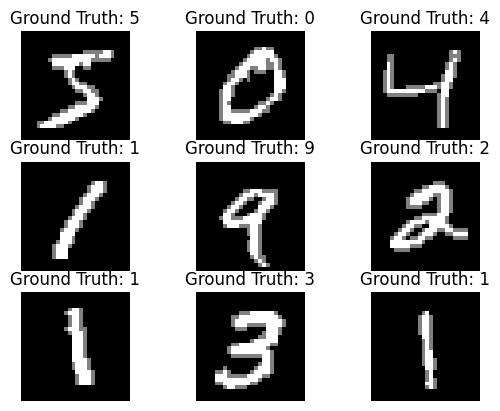

In [ ]:
plt.figure(figsize=(10, 15))
fig, ax = plt.subplots(3, 3)
(imgs, labels) = digits_train_ds[:9]
for i in range(9):
    ax[i // 3, i % 3].imshow(imgs[i], cmap='gray')
    ax[i // 3, i % 3].set_title(f'Ground Truth: {labels[i]}')
    ax[i // 3, i % 3].axis('off')

Let's visualize the face edge data to test whether the above Dataset class is working as expected.

In [ ]:
faces_train_ds = TextDataset('./data/facedata/facedatatrain', './data/facedata/facedatatrainlabels', './data/facedata/train_data', image_size=(70, 60))
faces_val_ds = TextDataset('./data/facedata/facedatavalidation', './data/facedata/facedatavalidationlabels', './data/facedata/val_data', image_size=(70, 60))
faces_test_ds = TextDataset('./data/facedata/facedatatest', './data/facedata/facedatatestlabels', './data/facedata/test_data', image_size=(70, 60))

In [ ]:
print(f'Number of samples in the training set: {len(faces_train_ds)}')
print(f'Number of samples in the validation set: {len(faces_val_ds)}')
print(f'Number of samples in the test set: {len(faces_test_ds)}')

Number of samples in the training set: 451
Number of samples in the validation set: 301
Number of samples in the test set: 150


<Figure size 1000x1500 with 0 Axes>

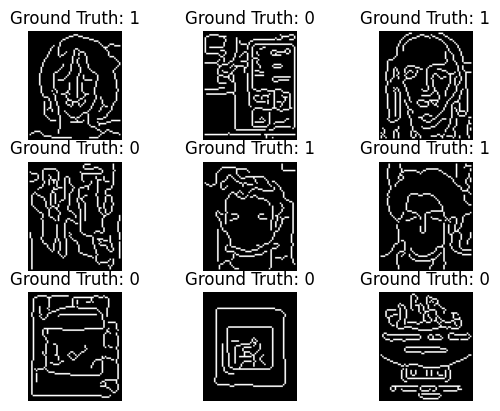

In [ ]:
plt.figure(figsize=(10, 15))
fig, ax = plt.subplots(3, 3)
(imgs, labels) = faces_train_ds[:9]
for i in range(9):
    ax[i // 3, i % 3].imshow(imgs[i], cmap='gray')
    ax[i // 3, i % 3].set_title(f'Ground Truth: {labels[i]}')
    ax[i // 3, i % 3].axis('off')

## Building the ML/DL Models

In [ ]:
BATCH_SIZE = 64

digits_train_dataloader = DataLoader(digits_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
digits_val_dataloader = DataLoader(digits_val_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

faces_train_dataloader = DataLoader(faces_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
faces_val_dataloader = DataLoader(faces_val_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = "cpu"
print("Device:", device)

Device: cpu


### (01). Naive Bayes Classifier

The problem of classification can be re-framed as finding the conditional probability of a class label given the data. Naive Bayes classifier is a probabilistic algorithm used for classification tasks. It is called naive because it makes a strong assumption that the features used to classify the data are conditionally independent given the class label. This assumption simplifies the computation of the joint probability of the features and the class, making the algorithm more computationally efficient and scalable.

The Naive Bayes classifier can be used for digit classification and face recognition tasks because these tasks involve high-dimensional data, and the algorithm is well-suited for such data. In digit classification, each digit image is represented as a high-dimensional vector of pixel values, and the algorithm can estimate the conditional probabilities of the pixel values given the class labels using the training data. In face recognition, each face image is represented as a high-dimensional vector of features, and the algorithm can estimate the conditional probabilities of the features given the class labels using the training data.

The algorithm works by computing the posterior probability of each class given the features of an input instance using Bayes' theorem. The posterior probability is proportional to the product of the prior probability of the class and the likelihood of the features given the class. The prior probability of each class is estimated from the training data, and the likelihood of the features given the class is assumed to follow a probability distribution. For example, in the case of digit classification, a multinomial distribution can be used to model the likelihood of the pixel values given the class label.

The Naive Bayes classifier is a simple yet effective algorithm that can achieve high accuracy in many classification tasks. It has been widely used in various domains, including text classification, spam filtering, and image classification, among others.

Following is my implementation of a general Naive Bayes Classifier to train and predict digit images as well as face images. **Note that PyTorch is only used for optimizing the data pipeline in order to utilize GPU and parallelize data loading for better performance and for nothing else. All the data loading, data pre-processing, training loop and the testing loop are written from scratch by myself. The data pipeline is implemented so that I can use it for any of the three tasks, thus avoiding myself from writing separate scripts for them.**

In [ ]:
class NaiveBayesClassifier:
    def __init__(self, possible_feature_vals, device, num_classes=10, num_features=784, alpha=1.0):
        self.device = device
        self.num_classes = num_classes
        self.num_features = num_features
        self.alpha = alpha

        self.log_class_priors = torch.zeros(num_classes).to(self.device)
        self.possible_feature_vals = torch.tensor(possible_feature_vals, dtype=torch.int32).to(self.device)
        self.log_pixel_likelihoods = torch.zeros((num_classes, self.num_features, len(self.possible_feature_vals))).to(self.device)

    def train(self, train_loader, val_loader=None):
        '''
        Compute class priors and pixel likelihoods from training data.
        '''
        total_samples = 0
        class_counts = torch.zeros(self.num_classes).to(self.device)
        pixel_counts = torch.zeros((self.num_classes, self.num_features, len(self.possible_feature_vals))).to(self.device)

        progbar = Progbar(target=len(train_loader), stateful_metrics=[])
        metrics = {}
        progbar.update(0, values=metrics.items(), finalize=False)

        train_ds = train_loader.dataset[:]
        if val_loader:
            val_ds = val_loader.dataset[:]

        for step, (images, labels) in enumerate(train_loader):
            images, labels = images.to(self.device), labels.to(self.device)
            total_samples += len(labels)
            # Each entry in the class_counts array stores the count of the number of times a particular class occurs throughout the dataset.
            class_counts += torch.sum(F.one_hot(labels.long(), num_classes=self.num_classes), dim=0)

            # Update pixel counts for each class where each feature pixel matches with a particular feature value.
            for c in range(self.num_classes):
                indices = torch.where(labels == c)
                pixel_counts[c, :, :] += torch.sum(images[indices].reshape(-1, self.num_features, 1) == self.possible_feature_vals, dim=0)

            # Update the class priors and pixel likelihoods after each iteration (so that validation receives the latest updated values).
            # The log values are pre-computed for efficiency.
            # The class priors are estimated as the probability of a random image in the dataset belonging to a particular class.
            self.log_class_priors = torch.log(class_counts + self.alpha) - np.log(total_samples + self.alpha * self.num_classes)
            # The pixel likelihoods are estimated.
            self.log_pixel_likelihoods = torch.log(pixel_counts + self.alpha) - torch.log(class_counts.reshape((-1, 1, 1)) + self.alpha * len(self.possible_feature_vals))

            metrics.update({'train_acc': self.predict(train_ds[0], train_ds[1], save_class_probs=True)[1]})

            if val_loader:
                metrics.update({'val_acc': self.predict(val_ds[0], val_ds[1])[1]})

            progbar.update(step, values=metrics.items(), finalize=False)

        progbar.update(step + 1, values=metrics.items(), finalize=True)

    def predict(self, images, gt_labels=None, save_class_probs=False):
        '''
        Compute class probabilities for each image in the batch using maximum a posteriori estimation.
        '''
        if isinstance(images, np.ndarray):
            images = torch.from_numpy(images)
        images = images.reshape(-1, self.num_features, 1).to(self.device)

        # Compute the mask tensor.
        mask = (images == self.possible_feature_vals).to(torch.float32)

        # Perform element-wise multiplication of mask and self.pixel_likelihoods to extract the relevant probabilities.
        likelihoods = torch.sum(torch.sum(mask[:, None, :, :] * self.log_pixel_likelihoods[None, :, :, :], dim=-1), dim=-1)

        # Compute the log class probabilities.
        class_probs = self.log_class_priors + likelihoods

        if save_class_probs:
            self.class_probs = torch.exp(class_probs)

        preds = class_probs.argmax(dim=1)

        # Return the class predictions and accuracies.
        if gt_labels is not None: return preds, (preds == torch.from_numpy(gt_labels).to(self.device)).sum().item() / images.shape[0]

        return preds

    def generate_image(self, target_class, image_size):
        pixel_values = np.zeros((self.num_features,), dtype=np.int32)

        for i in range(self.num_features):
            log_probs = self.log_pixel_likelihoods[target_class, i, :]
            probs = torch.exp(log_probs - torch.max(log_probs)) # Compute the probabilities by taking the exponential of the log probabilities and normalizing.
            probs = probs.cpu().numpy()
            probs /= np.sum(probs)
            # Sample a value for the pixel from the possible values using the model's learned pixel probability distribution.
            pixel_values[i] = np.random.choice(self.possible_feature_vals.cpu().numpy(), p=probs)

        # Reshape the pixel values to form the image.
        image = pixel_values.reshape(image_size)

        return image

Given a dataset of $N$ labeled images $({x_i, y_i})_{i=1}^N$, where each $x_i$ is an image and $y_i$ is its corresponding label, and assuming that the pixel intensities in each image follow a multinomial / binomial distribution (I am using the raw pixels as features which is simpler but works reasonably well in this case), we can train a Naive Bayes classifier by estimating the conditional probabilities $P(x|y)$ and prior probabilities $P(y)$.

Let $x = {x_1, x_2, \ldots, x_D}$ denote the $D$ pixel intensities in an image. Then, the Naive Bayes classifier assigns a label $\hat{y}$ to a test image $x^*$ by computing the posterior probability of each label given the test image:

$P(y=k|x^*)=\frac{P(x^*|y=k)P(y=k)}{P(x^*)}$

where $P(x^*)$ is the marginal probability of the test image, which is the same for all labels, and can be ignored for the purpose of classification. Therefore, we can simplify the above expression as follows:

$P(y=k|x^*) \propto P(x^*|y=k)P(y=k)$

The likelihood $P(x^*|y=k)$ represents the probability of observing the test image $x^*$ given that its label is $k$. We assume that the pixel intensities in each image are independent given its label, so we can express the likelihood as a product of individual pixel probabilities:

$P(x^*|y=k)=\prod_{j=1}^DP(x^*_j|y=k)$
where $x_j^*$ is the intensity of the $j$-th pixel in the test image.

The conditional probability $P(x^*_j|y=k)$ for a feature value $x^*_j$ given the class label $y=k$ can be estimated from the training data. Specifically, those data examples that belong to a given class, and one data distribution per variable. This means that if there are $K$ classes and $D$ variables, that $K * D$ different probability distributions must be created and maintained.

In the case of categorical variables, we can use a binomial distribution (if there're only two possible categories) or a multinomial distribution (if there're more than two possible categories). For our case, we will have to use a multinomial distribution to estimate $P(x^*_j|y=k)$ for digits dataset (since there're three possible values a pixel can get: 0, 128, or 255) and a binomial distribution for face dataset (since there're only two possible values a pixel can get: 0 and 255).

The calculation of the prior $P(y=k)$ is straightforward. It can be estimated by dividing the frequency of observations in the training dataset that have the class label by the total number of examples in the training dataset.

$P(y=k) = \frac{\text{\# of examples with y=k}}{\text{\# of total examples}}$

Once we have estimated the necessary parameters, we can classify a test image $x^*$ by computing the posterior probability $P(y=k|x^*).$ Given a new image $x^*$ with pixel values $x_1^*, x_2^*, ..., x_D^*$, the classifier predicts the label $\hat{y}$ that maximizes the posterior probability:

$\hat{y} = \text{argmax}_k\{P(y=k)\prod_{j=1}^DP(x^*_j|y=k)\}$

However, when multiplying a large number of probabilities, the result can quickly become very small, and computer arithmetic may round it to zero, which leads to the loss of information. Calculating class probabilities under log is a common technique used to avoid numerical underflow that can occur when multiplying small probabilities together. Taking the logarithm of the probabilities and adding them together, rather than multiplying the probabilities themselves, avoids this issue. Because log values are additive, the result can be expressed in a larger range, which is more computationally stable. Therefore, the computation of the maximum a posteriori looks like following in my above implementation:

$\hat{y} = \text{argmax}_k\{\sum_{j=1}^Dlog(P(x^*_j|y=k))+log(P(y=k))\}$

#### Training and Testing with the Digits dataset

10 different models are trained on 10 portions of data in order to compare and contrast the performance gains. i.e. 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, and 100% of the training data.

In [ ]:
nb_models = []
portion = 0.1

for i in range(10):
    digits_train_dataloader = DataLoader(torch.utils.data.Subset(digits_train_ds, list(range(int(len(digits_train_ds) * portion)))),
                                         batch_size=min(BATCH_SIZE, int(len(digits_train_ds) * portion)),
                                         shuffle=True,
                                         #num_workers=os.cpu_count(),
                                         drop_last=False)

    nb_model = NaiveBayesClassifier(possible_feature_vals=[0, 128, 255], device=device)
    print(f'Training on {int(round(portion * 100))}% of the training data...')
    nb_model.train(digits_train_dataloader, digits_val_dataloader)
    nb_models.append(nb_model)

    portion += 0.1

Training on 10% of the training data...
8/8 [==============================] - 1s 62ms/step - train_acc: 0.8491 - val_acc: 0.6696
Training on 20% of the training data...
16/16 [==============================] - 2s 85ms/step - train_acc: 0.8115 - val_acc: 0.7188
Training on 30% of the training data...
24/24 [==============================] - 3s 106ms/step - train_acc: 0.7994 - val_acc: 0.7208


The above implementation of naive bayes classifier achieves >80% accuracy on all the portions of the digits training set and ~80% accuracy on the digits validation set for models trained on >70% of the training data. Also, the training as well as batch inference is efficient because all the functions are optimized with matrix operations as possible as I can, instead of nested loop computations. It is obvious that model reaches it's capacity because, as number of training examples provided increases, the validation accuracy increases but the increment slowly drops. i.e. more training example than this will not improve the model significantly.

Now let's see how well will it perform on the test set. I've written the following function `evaluate()` which computes the metrics: accuracy, precision, recall, F1 score, and the confusion matrix. Accuracy measures the percentage of correctly classified samples out of the total number of samples. Precision measures the percentage of true positive predictions out of all the positive predictions, while recall measures the percentage of true positive predictions out of all the actual positive samples. F1 score is the harmonic mean of precision and recall. The confusion matrix gives us insight into how well the model is performing for each class.

In [ ]:
def evaluate(model, dataset, normalize=False):
    true_positives = torch.zeros(model.num_classes)
    false_positives = torch.zeros(model.num_classes)
    false_negatives = torch.zeros(model.num_classes)

    images, labels = dataset[:]
    if normalize:
        preds, accuracy = model.predict(images, labels, normalize)
    else:
        preds, accuracy = model.predict(images, labels)
    preds = preds.cpu()

    for i in range(model.num_classes):
        true_positives[i] += ((preds == i) & (labels == i)).sum().item()
        false_positives[i] += ((preds == i) & (labels != i)).sum().item()
        false_negatives[i] += ((preds != i) & (labels == i)).sum().item()

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return preds, accuracy, precision, recall, f1_score, confusion_matrix(labels, preds)

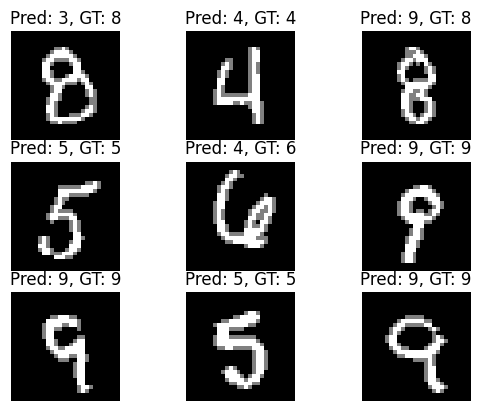

Classification report using the test set for the model trained on 10% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.84      0.81      0.82        90
           1       0.69      0.97      0.80       108
           2       0.80      0.64      0.71       103
           3       0.68      0.74      0.71       100
           4       0.67      0.65      0.66       107
           5       0.47      0.38      0.42        92
           6       0.72      0.59      0.65        91
           7       0.86      0.61      0.71       106
           8       0.67      0.38      0.48       103
           9       0.45      0.82      0.58       100

    accuracy                           0.66      1000
   macro avg       0.69      0.66      0.66      1000
weighted avg       0.69      0.66      0.66      1000



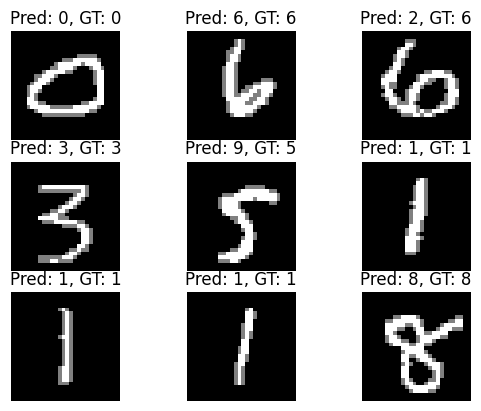

Classification report using the test set for the model trained on 20% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        90
           1       0.78      0.96      0.86       108
           2       0.82      0.69      0.75       103
           3       0.78      0.65      0.71       100
           4       0.66      0.65      0.66       107
           5       0.54      0.66      0.60        92
           6       0.76      0.64      0.69        91
           7       0.87      0.74      0.80       106
           8       0.75      0.48      0.58       103
           9       0.50      0.79      0.61       100

    accuracy                           0.71      1000
   macro avg       0.73      0.71      0.71      1000
weighted avg       0.74      0.71      0.71      1000



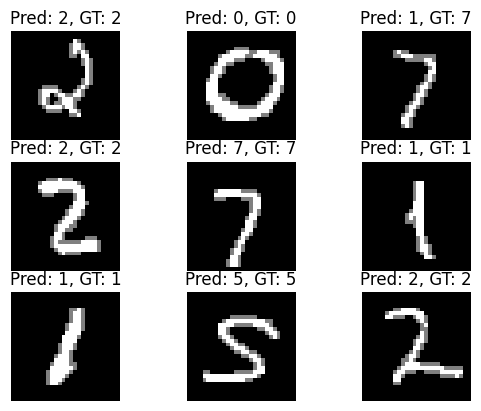

Classification report using the test set for the model trained on 30% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        90
           1       0.80      0.96      0.87       108
           2       0.83      0.72      0.77       103
           3       0.71      0.75      0.73       100
           4       0.67      0.71      0.69       107
           5       0.62      0.61      0.61        92
           6       0.78      0.65      0.71        91
           7       0.87      0.75      0.80       106
           8       0.72      0.50      0.59       103
           9       0.52      0.76      0.62       100

    accuracy                           0.73      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.74      0.73      0.73      1000



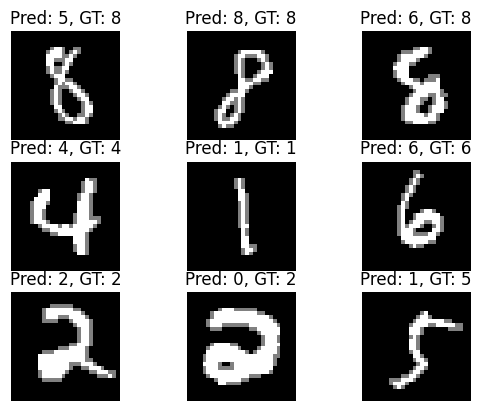

Classification report using the test set for the model trained on 40% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.90      0.87      0.88        90
           1       0.83      0.95      0.89       108
           2       0.85      0.76      0.80       103
           3       0.74      0.74      0.74       100
           4       0.67      0.70      0.68       107
           5       0.63      0.65      0.64        92
           6       0.78      0.69      0.73        91
           7       0.86      0.70      0.77       106
           8       0.76      0.50      0.61       103
           9       0.52      0.81      0.64       100

    accuracy                           0.74      1000
   macro avg       0.75      0.74      0.74      1000
weighted avg       0.75      0.74      0.74      1000



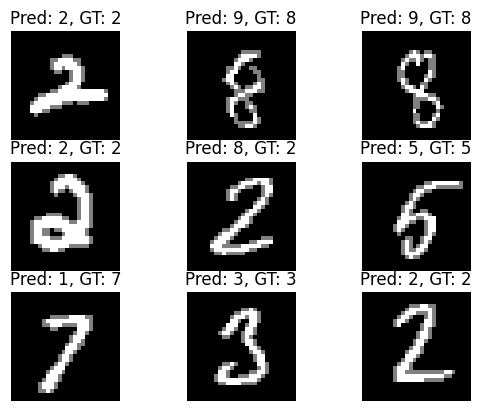

Classification report using the test set for the model trained on 50% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.90      0.84      0.87        90
           1       0.82      0.95      0.88       108
           2       0.85      0.76      0.80       103
           3       0.79      0.76      0.78       100
           4       0.71      0.74      0.72       107
           5       0.65      0.73      0.69        92
           6       0.79      0.71      0.75        91
           7       0.89      0.74      0.80       106
           8       0.75      0.56      0.64       103
           9       0.56      0.78      0.65       100

    accuracy                           0.76      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.77      0.76      0.76      1000



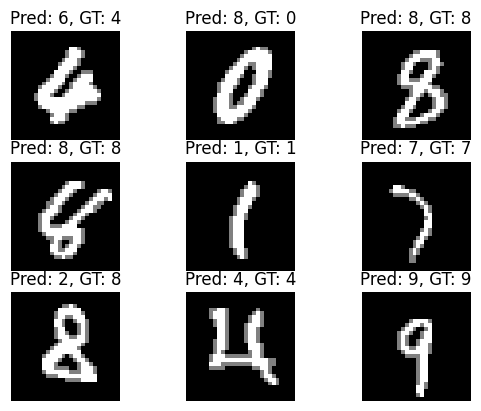

Classification report using the test set for the model trained on 60% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.91      0.86      0.88        90
           1       0.82      0.95      0.88       108
           2       0.85      0.76      0.80       103
           3       0.74      0.79      0.76       100
           4       0.70      0.78      0.74       107
           5       0.67      0.71      0.69        92
           6       0.80      0.69      0.74        91
           7       0.89      0.73      0.80       106
           8       0.76      0.54      0.63       103
           9       0.56      0.75      0.64       100

    accuracy                           0.76      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.77      0.76      0.76      1000



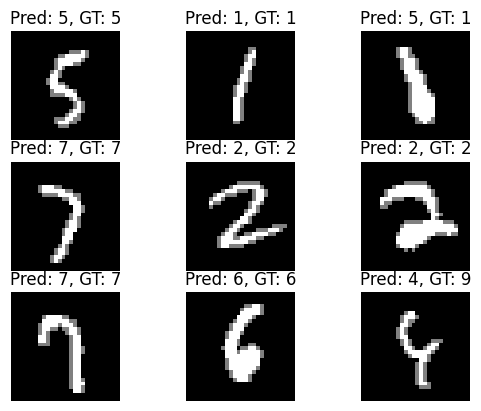

Classification report using the test set for the model trained on 70% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.91      0.88      0.89        90
           1       0.86      0.95      0.90       108
           2       0.85      0.76      0.80       103
           3       0.71      0.78      0.74       100
           4       0.72      0.79      0.76       107
           5       0.70      0.68      0.69        92
           6       0.79      0.74      0.76        91
           7       0.87      0.72      0.79       106
           8       0.75      0.56      0.64       103
           9       0.57      0.77      0.66       100

    accuracy                           0.76      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.77      0.76      0.76      1000



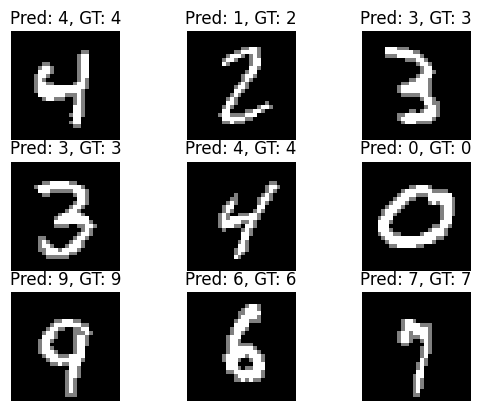

Classification report using the test set for the model trained on 80% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        90
           1       0.86      0.95      0.90       108
           2       0.86      0.77      0.81       103
           3       0.71      0.77      0.74       100
           4       0.76      0.77      0.76       107
           5       0.71      0.68      0.70        92
           6       0.80      0.75      0.77        91
           7       0.86      0.72      0.78       106
           8       0.74      0.59      0.66       103
           9       0.56      0.80      0.66       100

    accuracy                           0.77      1000
   macro avg       0.78      0.77      0.77      1000
weighted avg       0.78      0.77      0.77      1000



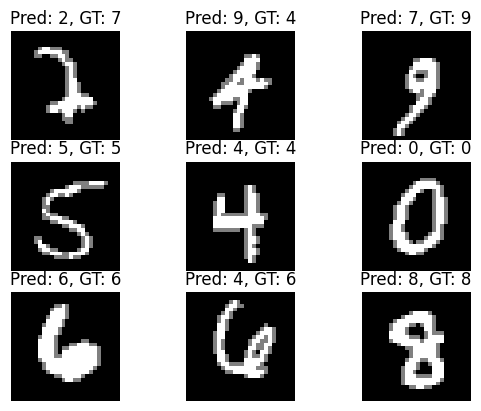

Classification report using the test set for the model trained on 90% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.93      0.86      0.89        90
           1       0.87      0.95      0.91       108
           2       0.86      0.77      0.81       103
           3       0.71      0.80      0.75       100
           4       0.76      0.79      0.77       107
           5       0.71      0.67      0.69        92
           6       0.81      0.77      0.79        91
           7       0.87      0.73      0.79       106
           8       0.74      0.60      0.66       103
           9       0.58      0.80      0.68       100

    accuracy                           0.77      1000
   macro avg       0.78      0.77      0.77      1000
weighted avg       0.78      0.77      0.77      1000



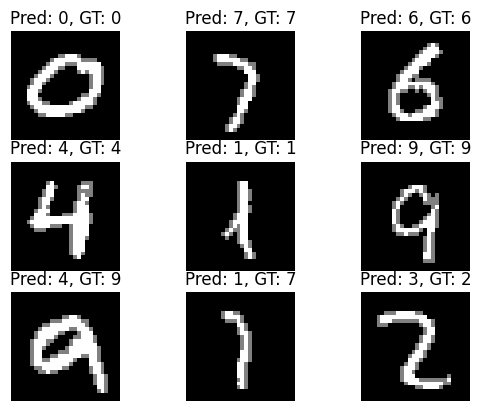

Classification report using the test set for the model trained on 100% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        90
           1       0.84      0.95      0.89       108
           2       0.87      0.75      0.80       103
           3       0.71      0.80      0.75       100
           4       0.77      0.78      0.77       107
           5       0.68      0.68      0.68        92
           6       0.81      0.76      0.78        91
           7       0.87      0.74      0.80       106
           8       0.72      0.62      0.67       103
           9       0.61      0.80      0.69       100

    accuracy                           0.77      1000
   macro avg       0.78      0.77      0.77      1000
weighted avg       0.78      0.77      0.77      1000



In [ ]:
portion = 10
cms = []

for nb_model in nb_models:
    fig, ax = plt.subplots(3, 3)
    ids = np.random.randint(size=9, low=0, high=len(digits_test_ds))
    imgs, labels = digits_test_ds[:]
    preds, acc, _, _, _, cm = evaluate(nb_model, digits_test_ds)
    cms.append(cm)
    for i in range(9):
        j = np.random.randint(low=0, high=len(digits_test_ds))
        ax[i // 3, i % 3].imshow(imgs[ids[i]], cmap='gray')
        ax[i // 3, i % 3].set_title(f'Pred: {preds[ids[i]]}, GT: {labels[ids[i]]}')
        ax[i // 3, i % 3].axis('off')
    plt.show()

    print(f'Classification report using the test set for the model trained on {portion}% of the training data:')
    print('###########################################################################################')
    print(classification_report(labels, preds))

    portion += 10

Confusion matrix for the model trained on 10% of the training data:


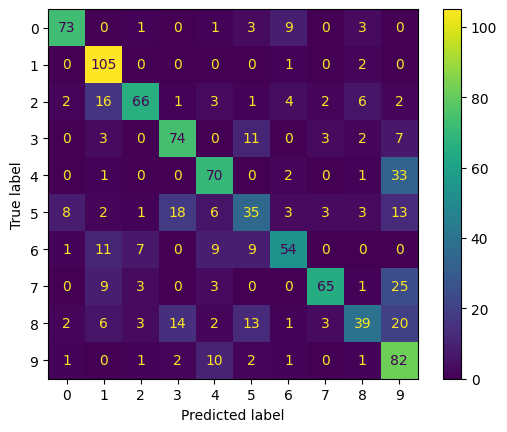

Confusion matrix for the model trained on 20% of the training data:


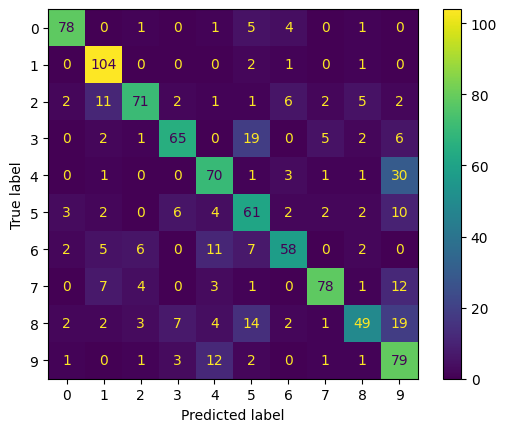

Confusion matrix for the model trained on 30% of the training data:


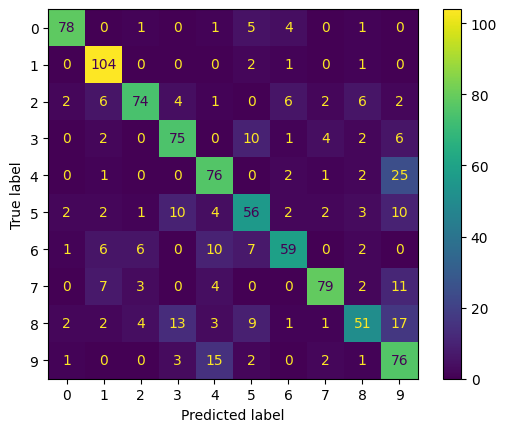

Confusion matrix for the model trained on 40% of the training data:


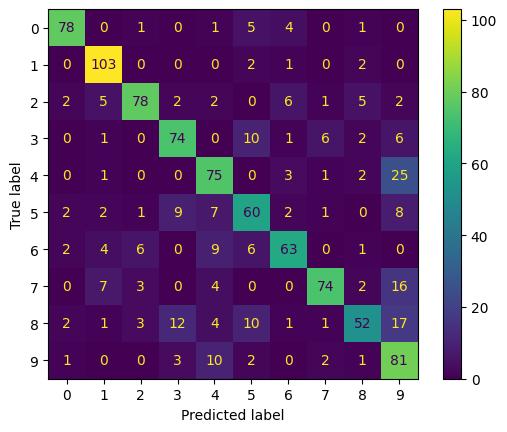

Confusion matrix for the model trained on 50% of the training data:


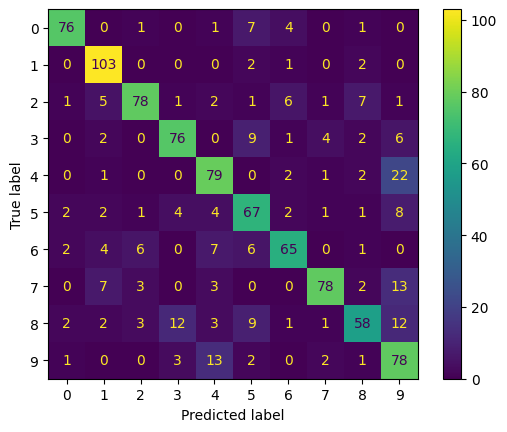

Confusion matrix for the model trained on 60% of the training data:


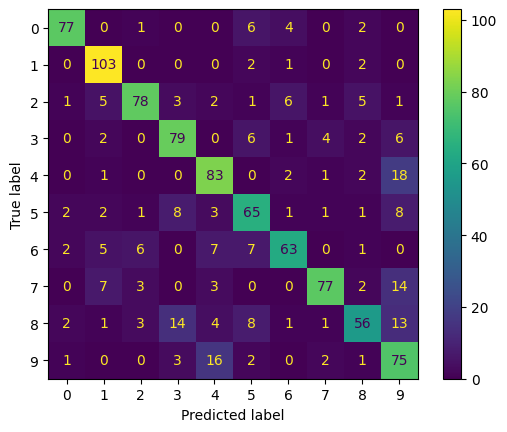

Confusion matrix for the model trained on 70% of the training data:


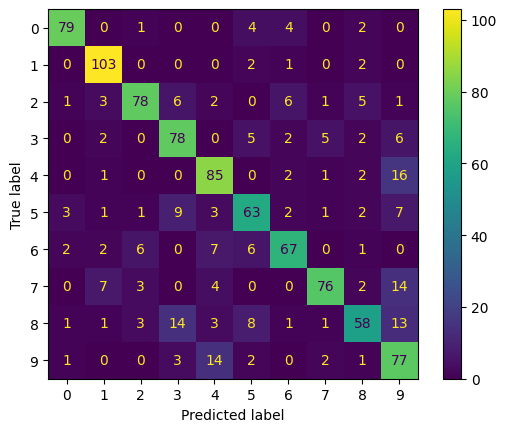

Confusion matrix for the model trained on 80% of the training data:


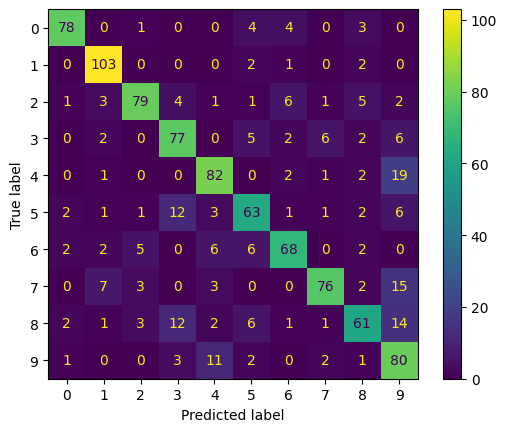

Confusion matrix for the model trained on 90% of the training data:


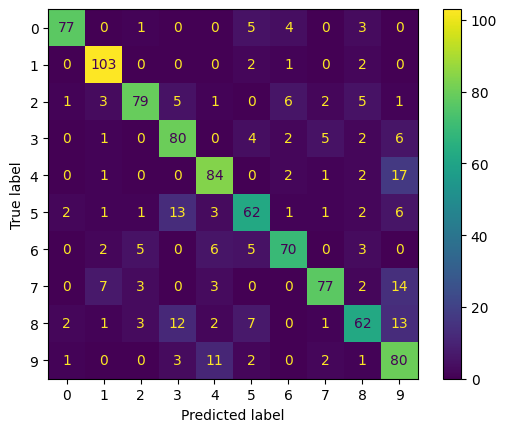

Confusion matrix for the model trained on 100% of the training data:


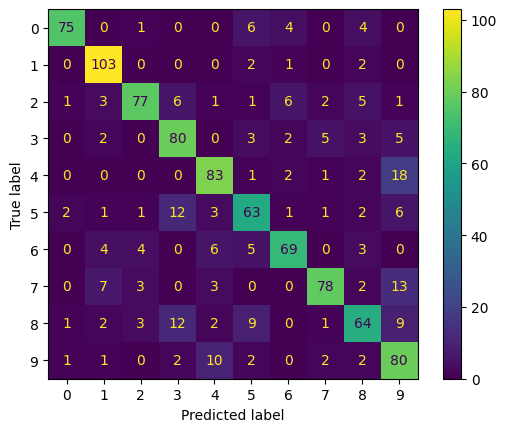

In [ ]:
portion = 10

for cm in cms:
    print(f'Confusion matrix for the model trained on {portion}% of the training data:')
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.show()
    portion += 10

Finally, to admire the fact that Navie Bayes Classifiers are generative models (i.e. they can generate new data using the learned data), as well as to intuitively understand how the model will perform on unknown data, let's generate images belonging to all classes with the model's learned probabilities (how does the model think about an image belonging to a class will look like).

Generated from the model trained on 10% of the training data:


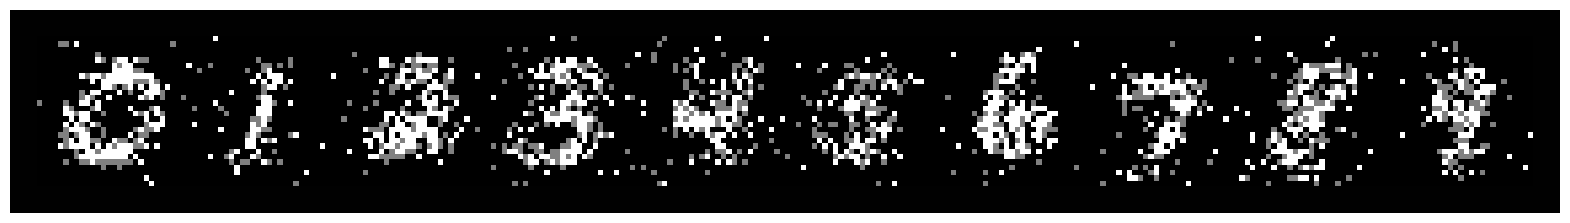

Generated from the model trained on 20% of the training data:


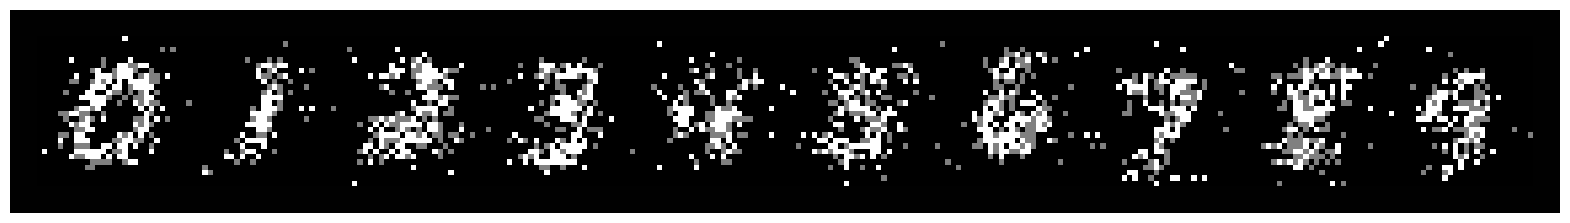

Generated from the model trained on 30% of the training data:


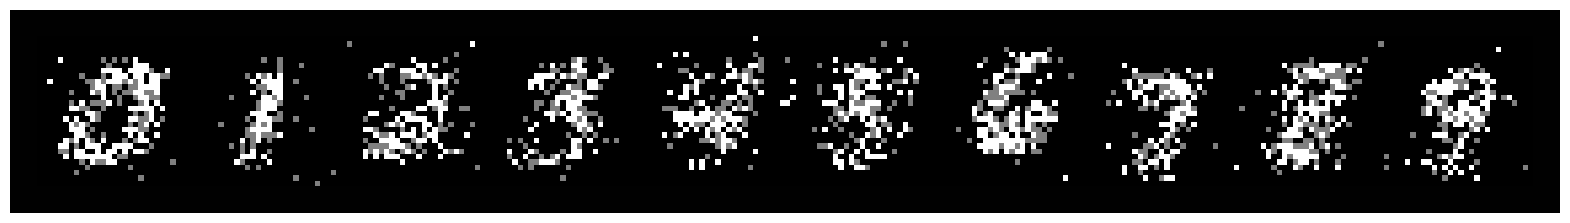

Generated from the model trained on 40% of the training data:


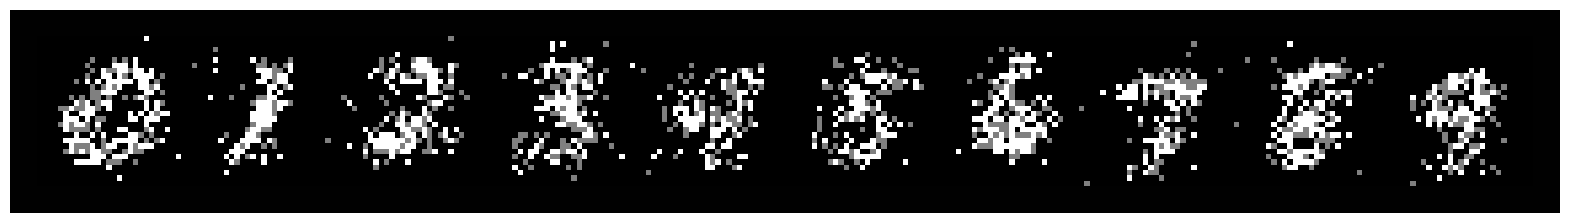

Generated from the model trained on 50% of the training data:


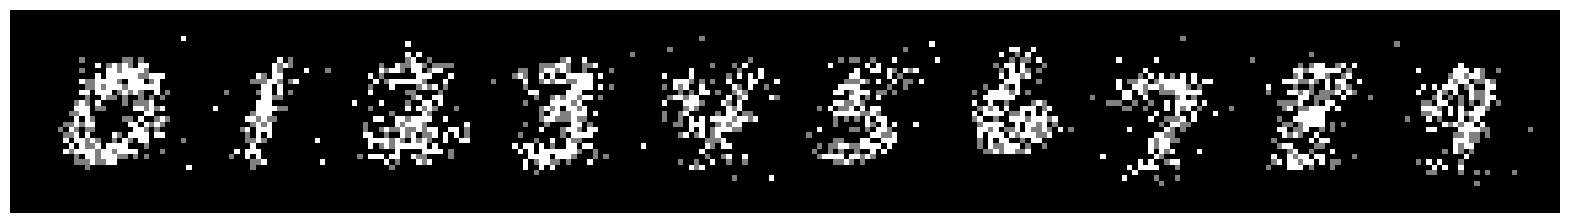

Generated from the model trained on 60% of the training data:


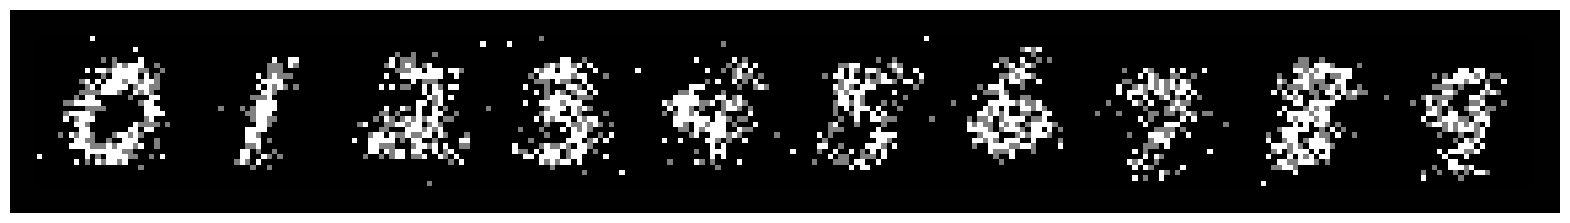

Generated from the model trained on 70% of the training data:


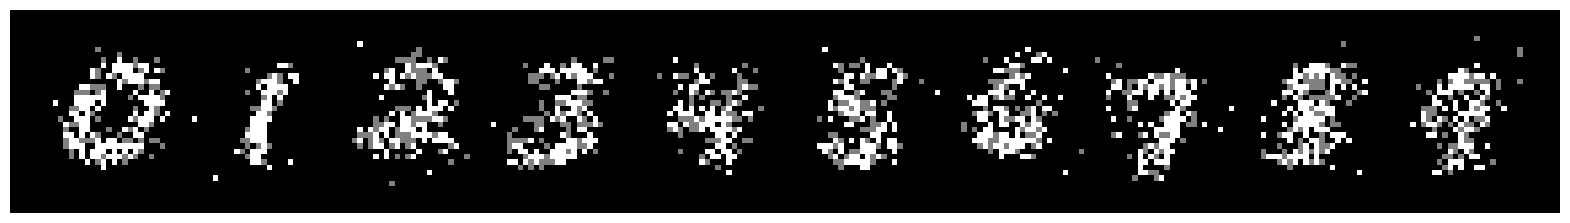

Generated from the model trained on 80% of the training data:


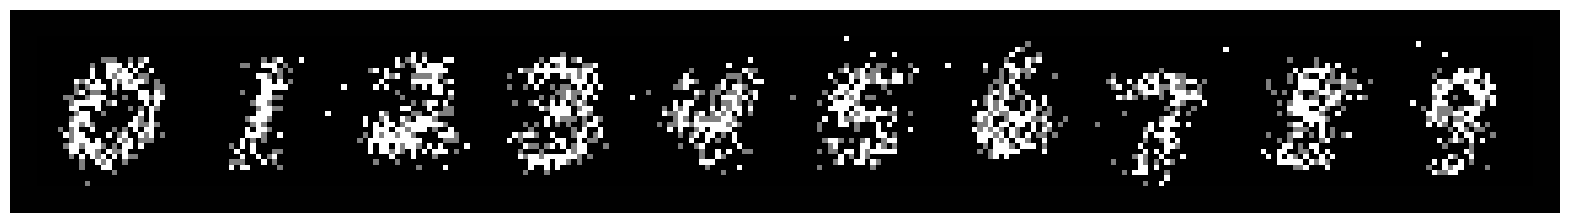

Generated from the model trained on 90% of the training data:


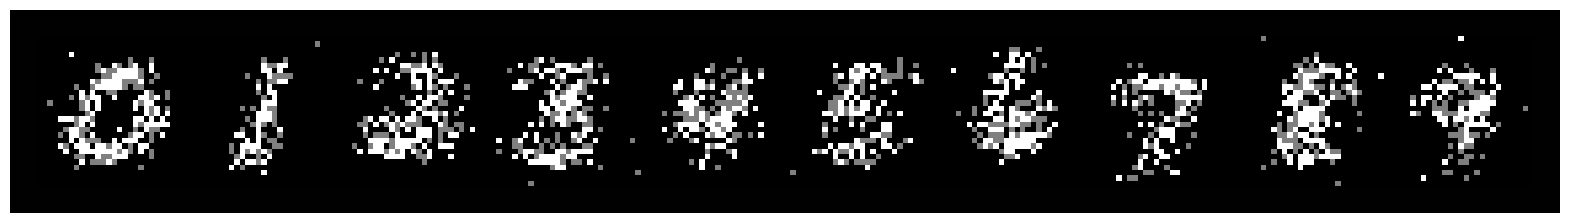

Generated from the model trained on 100% of the training data:


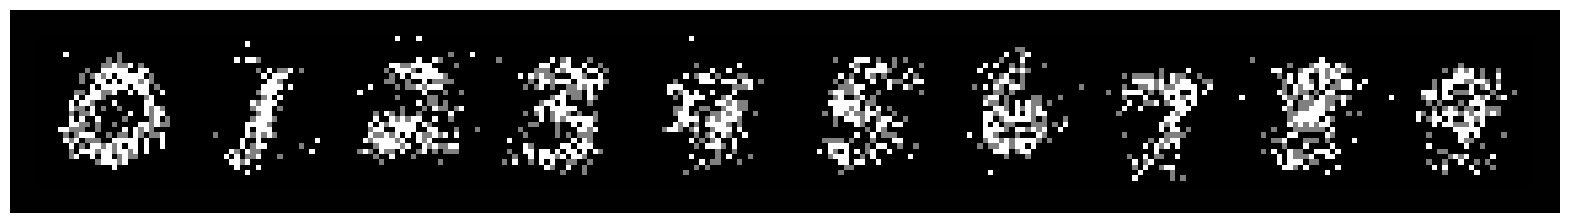

In [ ]:
portion = 10

for nb_model in nb_models:
    print(f'Generated from the model trained on {portion}% of the training data:')
    # Generate images for all digits.
    images = []
    for digit in range(nb_model.num_classes):
        gen_image = nb_model.generate_image(digit, (28, 28))
        images.append(gen_image)
    # Merge the images horizontally with padding.
    merged_image = np.concatenate(images, axis=1)
    merged_image_with_padding = np.pad(merged_image, pad_width=((5,5),(5,5)), mode='constant', constant_values=1)

    # Plot the merged image.
    plt.figure(figsize=(20, 4))
    plt.imshow(merged_image_with_padding, cmap='gray')
    plt.axis('off')
    plt.show()

    portion += 10

Looking at the above generated images, we can intuitively understand what the evaluation metrics meant. For example, we can say without looking at the evaluation metrics that the model's recall for the classes 0, 1, 3, and 9 are higher than the rest of the classes because the generated images for those classes have far less noise than the others and thus they are more recognizable. Also, we can intuitively understand why the 'recall' metric is called 'recall', which is becase it's the fraction of instances which the model recalls.

#### Training and Testing with the Faces dataset

In [ ]:
nb_models = []
portion = 0.1

for i in range(10):
    faces_train_dataloader = DataLoader(torch.utils.data.Subset(faces_train_ds, list(range(int(len(faces_train_ds) * portion)))), batch_size=min(BATCH_SIZE, int(len(faces_train_ds) * portion)), shuffle=True, num_workers=os.cpu_count(), drop_last=False)

    nb_model = NaiveBayesClassifier(num_classes=2, num_features=60 * 70, possible_feature_vals=[0, 255], device=device)
    nb_model.train(faces_train_dataloader, faces_val_dataloader)
    print(f'Training on {int(round(portion * 100))}% of the training data...')
    nb_models.append(nb_model)

    portion += 0.1

1/1 [==============================] - 1s 642ms/step - train_acc: 1.0000 - val_acc: 0.7608
Training on 10% of the training data...
2/2 [==============================] - 1s 317ms/step - train_acc: 0.9556 - val_acc: 0.7652
Training on 20% of the training data...
3/3 [==============================] - 1s 243ms/step - train_acc: 0.9593 - val_acc: 0.8106
Training on 30% of the training data...
3/3 [==============================] - 1s 232ms/step - train_acc: 0.9167 - val_acc: 0.8140
Training on 40% of the training data...
4/4 [==============================] - 1s 183ms/step - train_acc: 0.9262 - val_acc: 0.8432
Training on 50% of the training data...
5/5 [==============================] - 1s 160ms/step - train_acc: 0.9204 - val_acc: 0.8422
Training on 60% of the training data...
5/5 [==============================] - 1s 156ms/step - train_acc: 0.9201 - val_acc: 0.8583
Training on 70% of the training data...
6/6 [==============================] - 1s 137ms/step - train_acc: 0.9063 - val_acc:

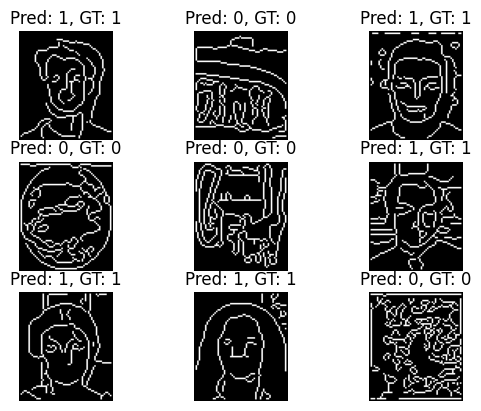

Classification report using the test set for the model trained on 10% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        77
           1       0.86      0.60      0.71        73

    accuracy                           0.76       150
   macro avg       0.78      0.76      0.75       150
weighted avg       0.78      0.76      0.75       150



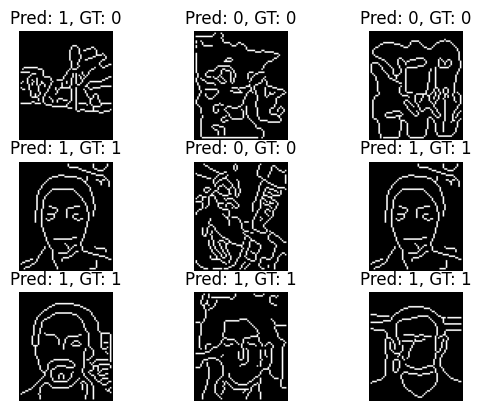

Classification report using the test set for the model trained on 20% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.87      0.71      0.79        77
           1       0.75      0.89      0.81        73

    accuracy                           0.80       150
   macro avg       0.81      0.80      0.80       150
weighted avg       0.81      0.80      0.80       150



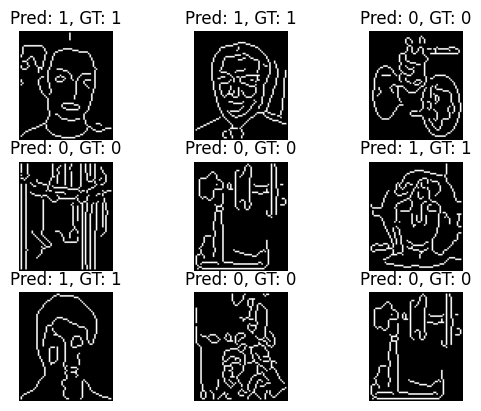

Classification report using the test set for the model trained on 30% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.90      0.79      0.84        77
           1       0.80      0.90      0.85        73

    accuracy                           0.85       150
   macro avg       0.85      0.85      0.85       150
weighted avg       0.85      0.85      0.85       150



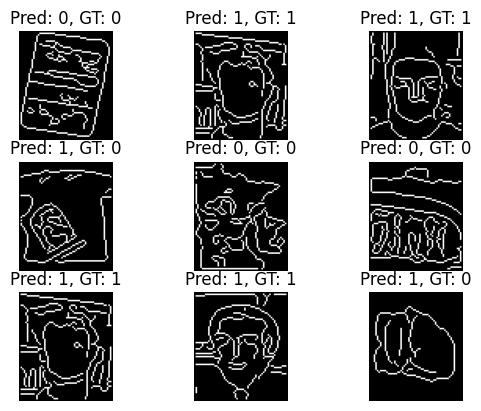

Classification report using the test set for the model trained on 40% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.93      0.86      0.89        77
           1       0.86      0.93      0.89        73

    accuracy                           0.89       150
   macro avg       0.90      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150



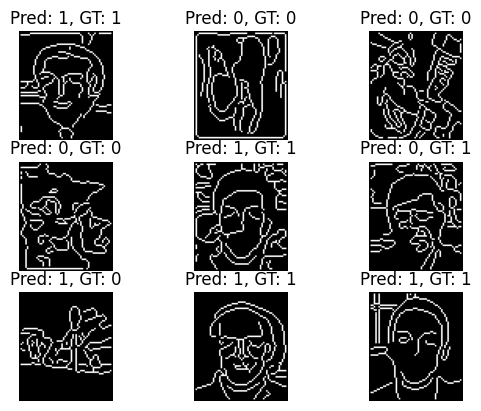

Classification report using the test set for the model trained on 50% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        77
           1       0.84      0.92      0.88        73

    accuracy                           0.87       150
   macro avg       0.88      0.87      0.87       150
weighted avg       0.88      0.87      0.87       150



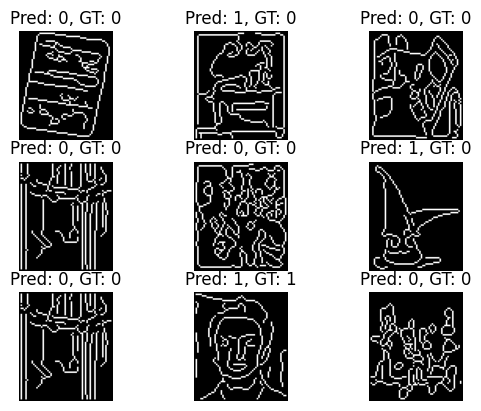

Classification report using the test set for the model trained on 60% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        77
           1       0.86      0.90      0.88        73

    accuracy                           0.88       150
   macro avg       0.88      0.88      0.88       150
weighted avg       0.88      0.88      0.88       150



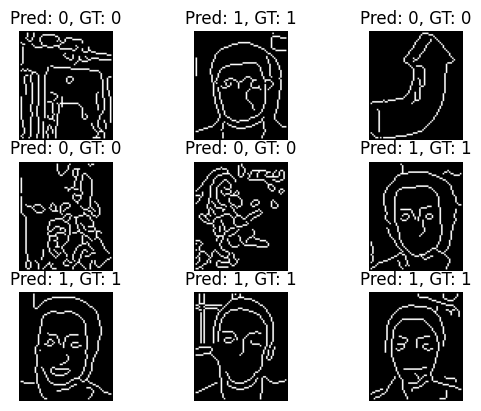

Classification report using the test set for the model trained on 70% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.93      0.86      0.89        77
           1       0.86      0.93      0.89        73

    accuracy                           0.89       150
   macro avg       0.90      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150



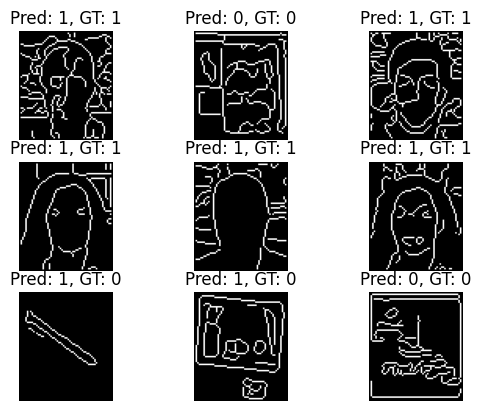

Classification report using the test set for the model trained on 80% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        77
           1       0.86      0.92      0.89        73

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150



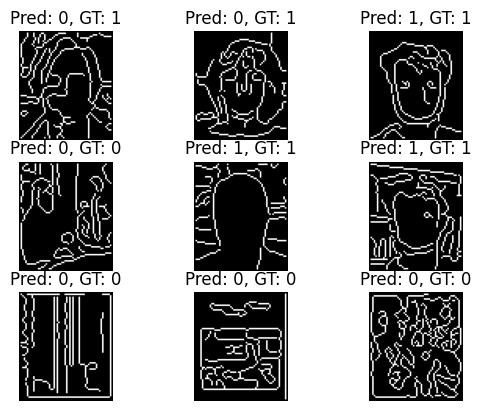

Classification report using the test set for the model trained on 90% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.92      0.87      0.89        77
           1       0.87      0.92      0.89        73

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150



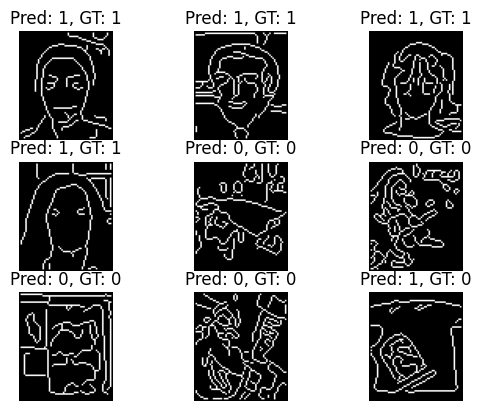

Classification report using the test set for the model trained on 100% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.93      0.88      0.91        77
           1       0.88      0.93      0.91        73

    accuracy                           0.91       150
   macro avg       0.91      0.91      0.91       150
weighted avg       0.91      0.91      0.91       150



In [ ]:
portion = 10
cms = []

for nb_model in nb_models:
    fig, ax = plt.subplots(3, 3)
    ids = np.random.randint(size=9, low=0, high=len(faces_test_ds))
    imgs, labels = faces_test_ds[:]
    preds, acc, _, _, _, cm = evaluate(nb_model, faces_test_ds)
    cms.append(cm)
    for i in range(9):
        j = np.random.randint(low=0, high=len(faces_test_ds))
        ax[i // 3, i % 3].imshow(imgs[ids[i]], cmap='gray')
        ax[i // 3, i % 3].set_title(f'Pred: {preds[ids[i]]}, GT: {labels[ids[i]]}')
        ax[i // 3, i % 3].axis('off')
    plt.show()

    print(f'Classification report using the test set for the model trained on {portion}% of the training data:')
    print('###########################################################################################')
    print(classification_report(labels, preds))

    portion += 10

Confusion matrix for the model trained on 10% of the training data:


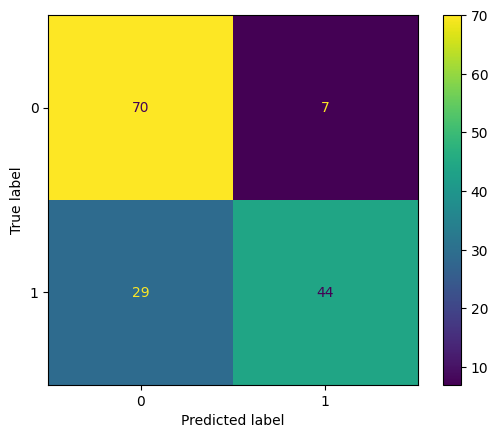

Confusion matrix for the model trained on 20% of the training data:


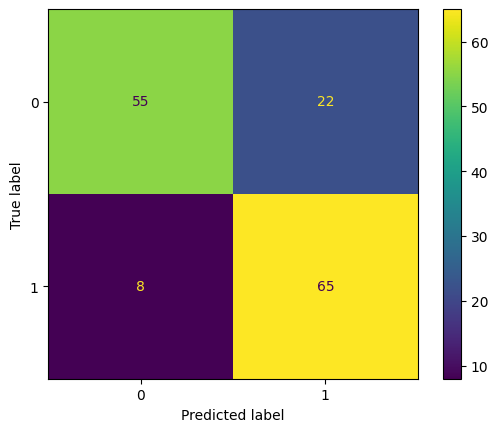

Confusion matrix for the model trained on 30% of the training data:


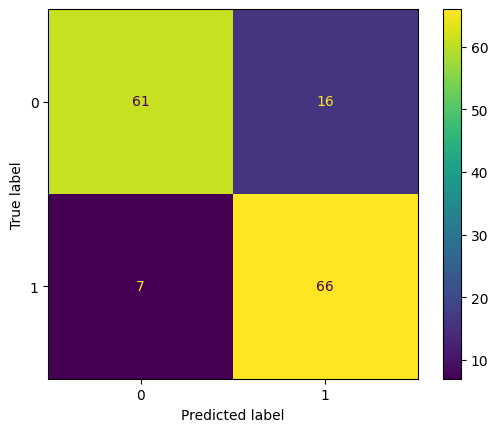

Confusion matrix for the model trained on 40% of the training data:


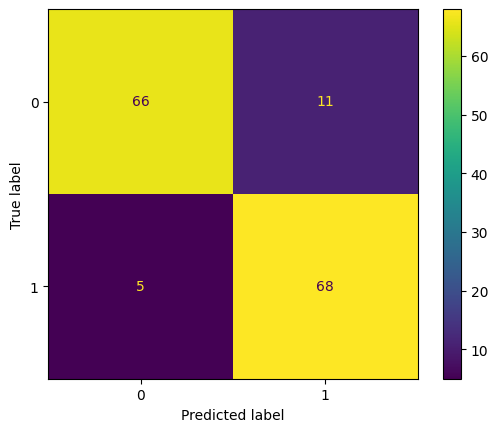

Confusion matrix for the model trained on 50% of the training data:


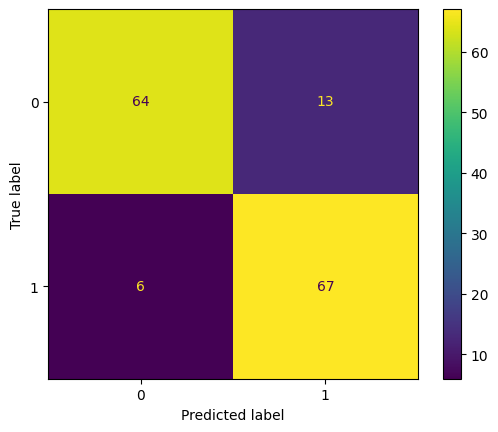

Confusion matrix for the model trained on 60% of the training data:


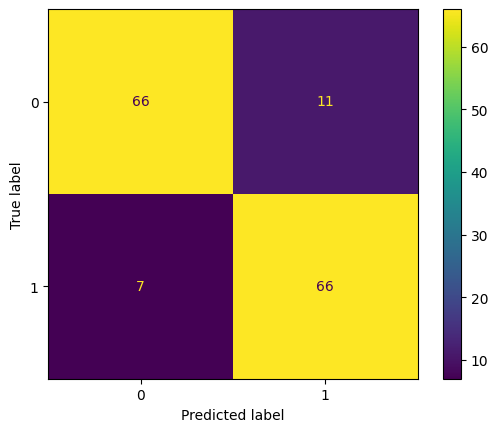

Confusion matrix for the model trained on 70% of the training data:


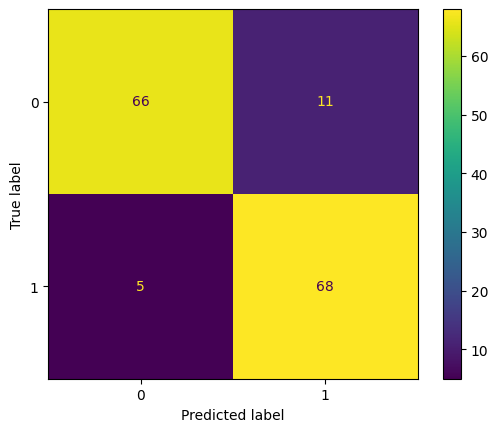

Confusion matrix for the model trained on 80% of the training data:


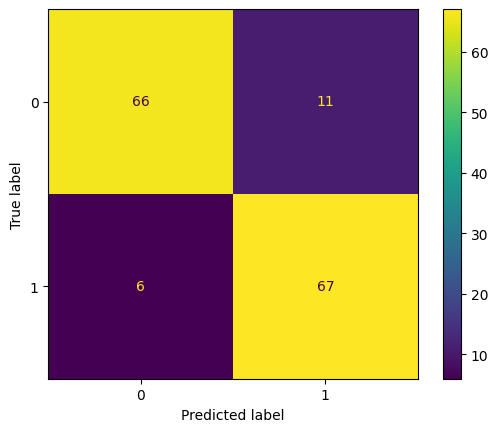

Confusion matrix for the model trained on 90% of the training data:


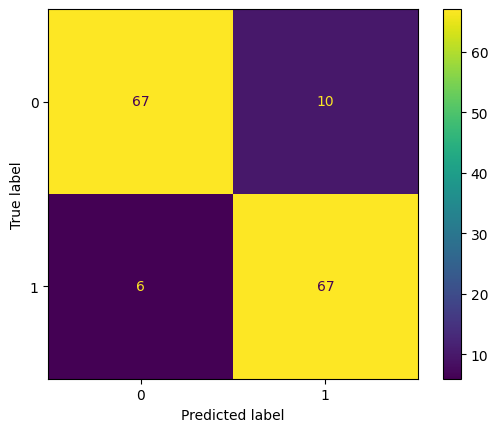

Confusion matrix for the model trained on 100% of the training data:


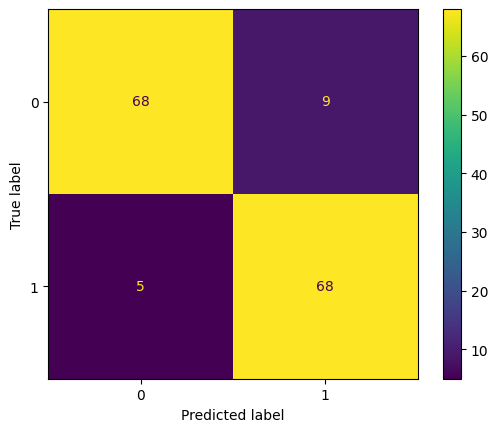

In [ ]:
portion = 10

for cm in cms:
    print(f'Confusion matrix for the model trained on {portion}% of the training data:')
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.show()
    portion += 10

Generated from the model trained on 10% of the training data:


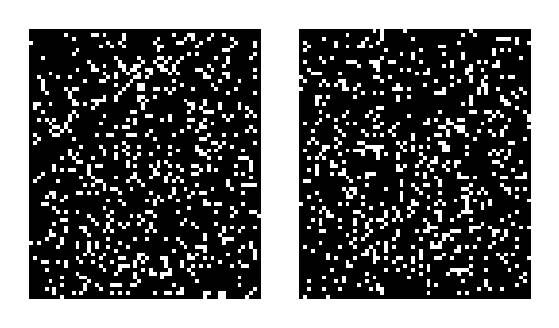

Generated from the model trained on 20% of the training data:


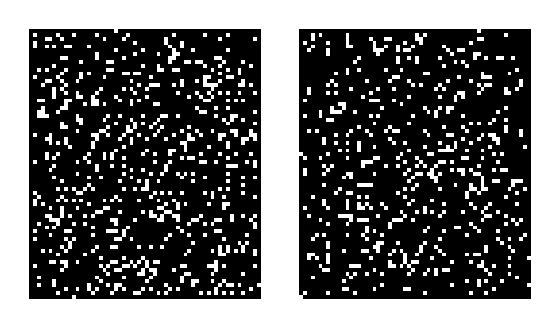

Generated from the model trained on 30% of the training data:


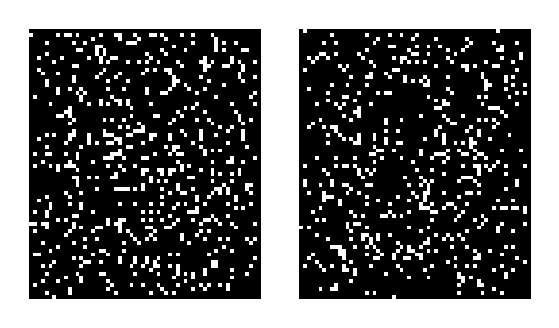

Generated from the model trained on 40% of the training data:


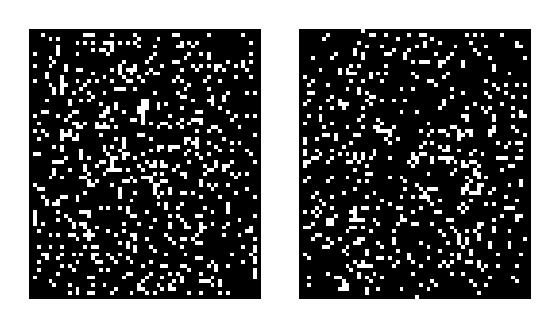

Generated from the model trained on 50% of the training data:


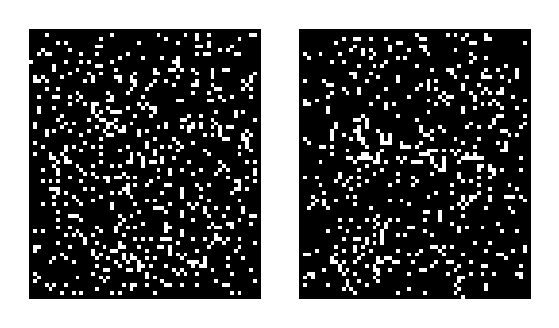

Generated from the model trained on 60% of the training data:


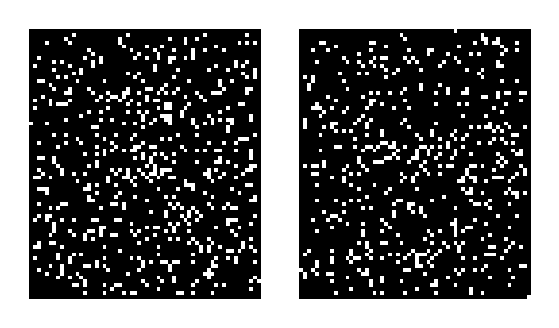

Generated from the model trained on 70% of the training data:


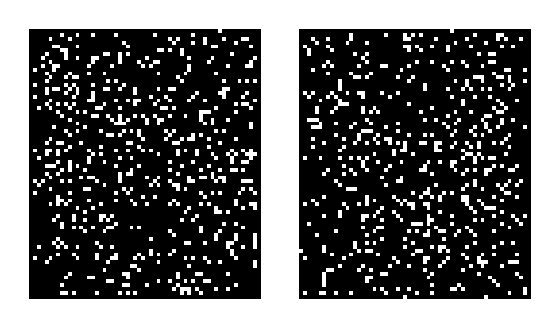

Generated from the model trained on 80% of the training data:


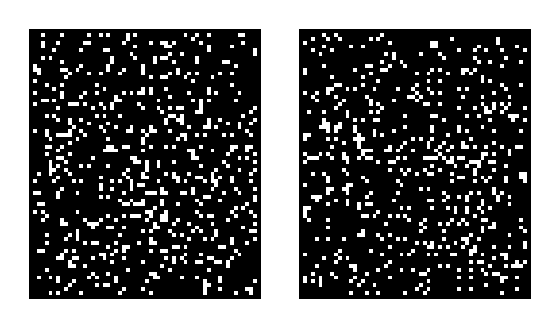

Generated from the model trained on 90% of the training data:


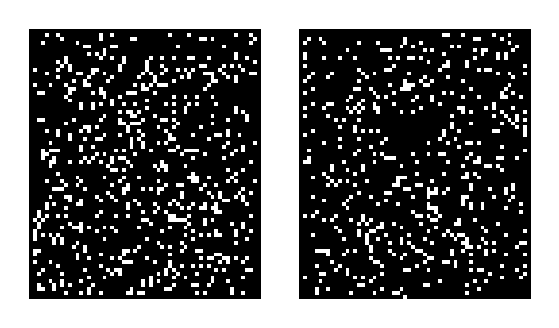

Generated from the model trained on 100% of the training data:


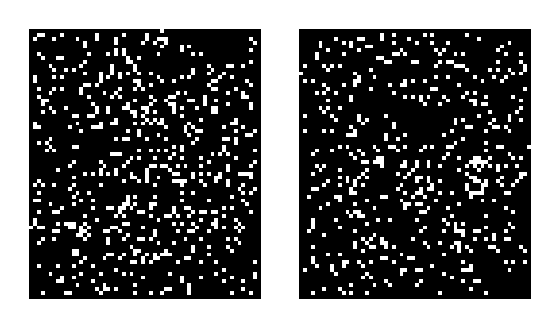

In [ ]:
portion = 10

for nb_model in nb_models:
    print(f'Generated from the model trained on {portion}% of the training data:')
    # Generate images for all digits
    images = []
    for digit in range(nb_model.num_classes):
        gen_image = nb_model.generate_image(digit, (70, 60))
        images.append(gen_image)
    # Merge the images horizontally with padding
    merged_image = np.hstack([np.pad(img, ((5, 5), (5, 5)), mode='constant', constant_values=255) for img in images])

    # Plot the merged image
    plt.figure(figsize=(20, 4))
    plt.imshow(merged_image, cmap='gray')
    plt.axis('off')
    plt.show()

    portion += 10

The above generated images doesn't seem to be pleasing! **This is an important observation** to compare both the datasets and what the model learns from the two different datasets. The model's accuracy for the digits dataset was much lower than for the faces dataset, but the model struggles to generate realistic looking face whereas it was able to generate reasonably recognizable images for the digits.

It is possible that the high accuracy for the faces dataset is due to the fact that the model is able to learn distinctive features of the faces such as eyes, nose, and mouth, rather than capturing the global structure of the face. Therefore, even though the model has a high accuracy in classifying the faces, it might still struggle to generate a realistic image given a specific class label.

In contrast, for the digits dataset, the global structure of the digits is more important in distinguishing between different classes. Therefore, the model might be able to capture this structure better and generate more realistic images for the digits dataset.

#### Evaluating Naive Bayes Classifier between the two Datasets

While the classifier performed reasonably well for the digits dataset in some classes (such as class 0 and class 1), it performed poorly in others (such as class 5 and class 8). However, the same classifier performed considerably well on the faces dataset with a training and testing accuracy of 91%.

This suggests that the Naive Bayes assumption of independence between pixels is not entirely accurate, and that there are correlations between neighboring pixels that should be taken into account. i.e. the Naive Bayes classifier assumes that the features are independent variables. But, for example, given a black pixel at one of the corners, the pixels around it are very likely to be black as well. This is significant in the digits dataset, but not very significant in the faces dataset since the images in that dataset are more general than the images in the digits dataset. Hence, we can see a slightly higher performance for the faces dataset than the digits one. This proves the fact that the Naive Bayes assumption is not always correct. Overall, the performance of the Naive Bayes classifier is limited by this assumption and it is likely that a more complex model would perform better on this task.

### (02). Perceptron Classifier

For this task, I will be using a shallow Multi-layer Perceptron (MLP) since it doesn't need to be too deep for such small datasets like ours. The MLP has only one hidden layer which will be the latent vector for the neural network that all the high-level information regarding the dataset are stored at. For this network too, I will be directly using the raw pixels as the features.

Each perceptron in a MLP layer is connected to all perceptrons in the previous layer, and each connection has a weight associated with it. The MLP is a feedforward network, meaning that the input flows from the input layer to the output layer through the hidden layers, with no feedback connections. During training, the network is fed with input examples and the output is compared to the expected output using a loss function. The weights are then adjusted to minimize the loss function using gradient descent or other optimization techniques.

The MLP is suitable for classifying digit or face datasets because it can learn complex non-linear mappings between the input features and the output classes. For example, in the case of digit classification, the MLP can learn to recognize the shapes of the digits and differentiate between them based on their distinctive features. Similarly, for face recognition, the MLP can learn to recognize facial features such as eyes, nose, and mouth, and use them to differentiate between different individuals.

The following PyTorch module is written from scratch using Pytorch layers.

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, device, keep_prob=0.5):
        super(MLPClassifier, self).__init__()

        self.input_size = input_size
        self.device = device
        self.num_classes = num_classes

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(keep_prob)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.reshape((-1, self.input_size))
        out = self.fc1(x)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

    def train_mlp(self, train_loader, loss_fn, optimizer, num_epochs, val_loader=None, verbose=True):
        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []

        for epoch in range(num_epochs):
            batch_loss = 0
            batch_acc = 0
            total_samples = 0

            progbar = Progbar(len(train_loader))
            metrics = {}
            if verbose or epoch == num_epochs - 1:
                print(f"Epoch [{epoch + 1}/{num_epochs}]")
            if verbose:
                progbar.update(0, metrics.items(), finalize=False)

            self.train()

            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()

                outputs = self(inputs)
                loss = loss_fn(outputs, labels)

                loss.backward()
                optimizer.step()

                total_samples += inputs.shape[0]
                batch_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                batch_acc += (predicted == labels).sum().item()

                metrics.update({"loss": batch_loss / (i + 1), "acc": batch_acc / total_samples})
                if verbose:
                    progbar.update(i + 1, metrics.items(), finalize=False)

            train_loss.append(batch_loss / len(train_loader))
            train_acc.append(batch_acc / len(train_loader.dataset))

            # Validation
            if val_loader is not None:
                val_batch_loss = 0
                val_batch_acc = 0

                with torch.no_grad():
                    self.eval()

                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(self.device), labels.to(self.device)

                        outputs = self(inputs)
                        loss = loss_fn(outputs, labels)

                        val_batch_loss += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        val_batch_acc += (predicted == labels).sum().item()

                val_loss.append(val_batch_loss / len(val_loader))
                val_acc.append(val_batch_acc / len(val_loader.dataset))

                metrics.update({"val_loss": val_loss[-1], "val_acc": val_acc[-1]})
                if verbose:
                    progbar.update(i + 1, metrics.items(), finalize=False)

            if verbose or epoch == num_epochs - 1:
                progbar.update(i + 1, metrics.items(), finalize=True)

        return train_loss, train_acc, val_loss, val_acc

    def predict(self, images, gt_labels=None, normalize=False):
        '''
        Compute class probabilities for each image in the batch.
        '''
        self.eval()

        if isinstance(images, np.ndarray):
            images = torch.from_numpy(images)
        images = images.to(self.device)

        if normalize:
            images = images.to(torch.float32)
            images = (images - images.min()) / (images.max() - images.min())

        # Forward pass through the model.
        output = self(images.view(images.shape[0], -1))

        # Compute the class probabilities and predictions.
        class_probs = F.softmax(output, dim=1)
        preds = class_probs.argmax(dim=1)

        # Return the class predictions and accuracies.
        if gt_labels is not None:
            if isinstance(gt_labels, np.ndarray):
                gt_labels = torch.from_numpy(gt_labels)
            return preds, (preds == gt_labels.to(self.device)).sum().item() / images.shape[0]

        return preds

I'll be adding a random augmentation to the dataset which is to rotate the images a few degrees clockwise and anti-clockwise, which will hopefully help improve learning different features in the image. I'm also normalizing the images into the (-1, 1) range because it helps the model converge faster and more reliably during training.

In [ ]:
class RandomRotate(object):
    """Randomly Rotate the image between a given range of degrees."""
    def __init__(self, prob=0.6, degrees=(-50, 50)):
        self.prob = prob
        self.degrees = degrees

    def __call__(self, sample):
        img, label = sample
        img = torch.from_numpy(np.expand_dims(img, axis=0))
        label = torch.from_numpy(np.asarray(label))
        if np.random.uniform() > self.prob:
            img = transforms.RandomRotation(degrees=self.degrees)(img)
        return img, label

In [ ]:
class Normalize(object):
    """Normalize the image to the range (-1, 1)."""

    def __call__(self, sample):
        image, label = sample
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image.astype(np.float32))
            label = torch.from_numpy(np.asarray(label))
        image = image.to(torch.float32)
        image = (image - image.min()) / (image.max() - image.min())
        return image, label

Re-instantiating the datasets with the transforms applied:

In [ ]:
digits_train_ds = TextDataset('./data/digitdata/trainingimages',
                              './data/digitdata/traininglabels',
                              './data/digitdata/train_data',
                              image_size=(28, 28),
                              transforms=transforms.Compose([
                                  RandomRotate(),
                                  Normalize()
                              ]))
digits_val_ds = TextDataset('./data/digitdata/validationimages',
                            './data/digitdata/validationlabels',
                            './data/digitdata/val_data',
                            image_size=(28, 28),
                            transforms=transforms.Compose([
                                Normalize()
                            ]))

In [ ]:
digits_val_dataloader = DataLoader(digits_val_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), drop_last=False)

#### Training and Testing with the Digits Dataset

The MLP network is trained for all the 10 portions of training data, each of which is trained for 30 epochs using cross-entropy loss and Adam optimizer as the optimization algorithm. All the hyperparameters were chosen experimentally.

In [ ]:
num_epochs = 30
learning_rate = 2.0e-4

mlp_models = []
histories = []

portion = 0.1

for i in range(10):
    digits_train_dataloader = DataLoader(torch.utils.data.Subset(digits_train_ds, list(range(int(len(digits_train_ds) * portion)))),
                                         batch_size=min(BATCH_SIZE, int(len(digits_train_ds) * portion)),
                                         shuffle=True,
                                        #  num_workers=5,
                                         drop_last=False)

    mlp_model = MLPClassifier(input_size=784, hidden_size=512, num_classes=10, device=device).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(mlp_model.parameters(), lr=learning_rate)
    print(f'Training on {int(round(portion * 100))}% of the training data...')
    histories.append(mlp_model.train_mlp(digits_train_dataloader, criterion, optimizer, num_epochs, val_loader=digits_val_dataloader, verbose=False))
    mlp_models.append(mlp_model)

    portion += 0.1

Training on 10% of the training data...


RuntimeError: DataLoader worker (pid(s) 19248, 10224, 39852, 40672, 35904) exited unexpectedly

It is quite obvious that even if the MLP is so shallow (has only one hidden layer of 512 neurons), it outperforms the Naive Bayes classifier with a huge margin. With 10% of the training data, the accuracy of the Naive Bayes model was in the order of 60%, whereas the MLP has accuracies in the order of 80%.

The MLP trained using the full dataset reached a validation accuracy of 92% which is quite impressive for such a small network. If more time was given (in terms of number of epochs), the models might improve their performances more. But, I decided to cut-off training from 30 epochs. Indeed the random rotation augmentations might have helped the networks generalize more on the data too, because a digit image can possibly be in any orientation and the network must recognize it regardless of the orientation. Note that in my MLP architecture, I also added a dropout layer after apply the ReLU activation to the hidden layer. I added a dropout layer for overfitting-safety, knowing that MLP's are high capacity functions, and given that our data are quite small in size, the MLPs may overfit to the training data. The dropout layer acts as an L2 regularization, preventing the network from overfitting. This makes the validation loss curves to be smooth and be well-below the training losses, which is obvious by looking at the following learning curves.

Training Loss vs. Validation Loss for the model trained on 10% of the training data


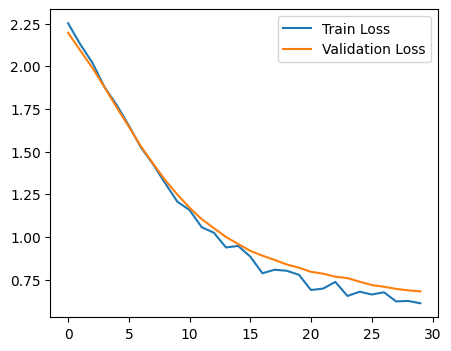

Training Loss vs. Validation Loss for the model trained on 20% of the training data


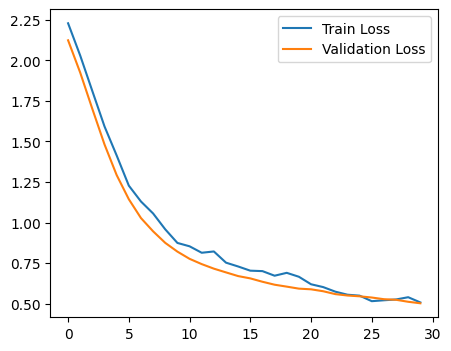

Training Loss vs. Validation Loss for the model trained on 30% of the training data


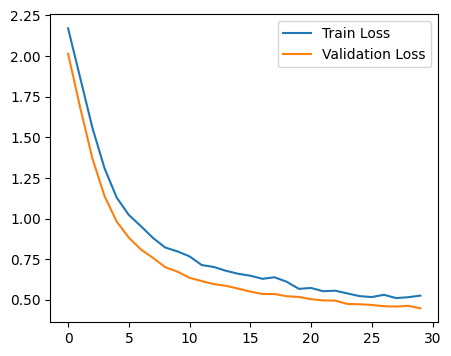

Training Loss vs. Validation Loss for the model trained on 40% of the training data


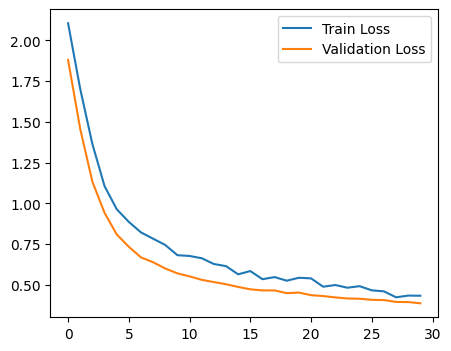

Training Loss vs. Validation Loss for the model trained on 50% of the training data


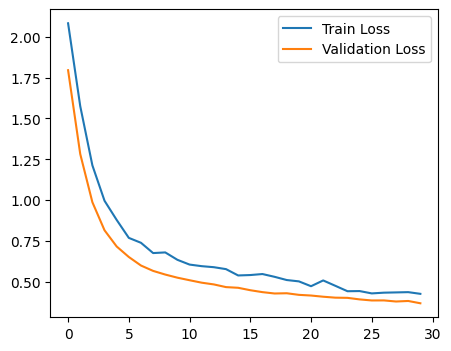

Training Loss vs. Validation Loss for the model trained on 60% of the training data


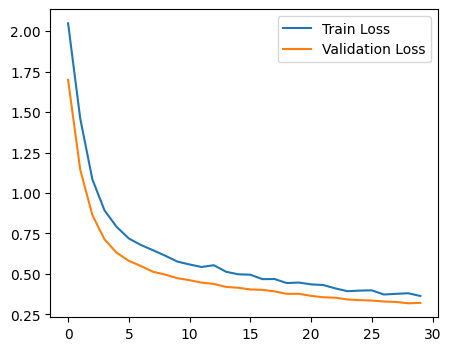

Training Loss vs. Validation Loss for the model trained on 70% of the training data


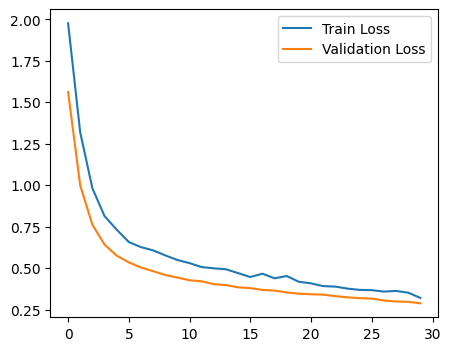

Training Loss vs. Validation Loss for the model trained on 80% of the training data


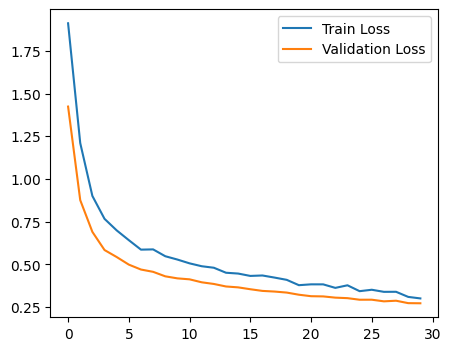

Training Loss vs. Validation Loss for the model trained on 90% of the training data


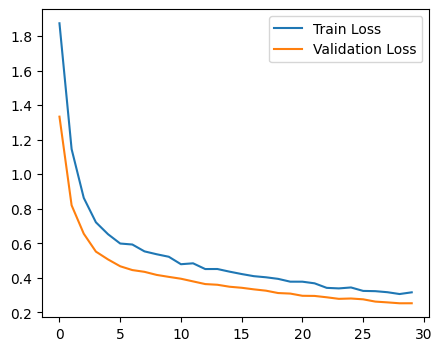

Training Loss vs. Validation Loss for the model trained on 100% of the training data


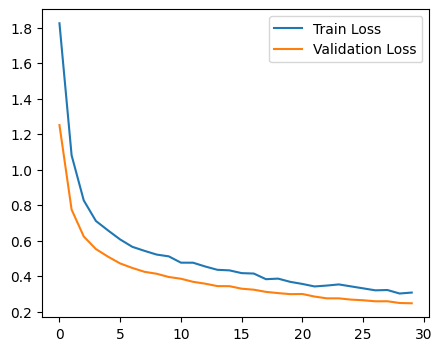

In [ ]:
portion = 10

for i in range(10):
    train_loss, _, val_loss, _ = histories[i]
    plt.figure(figsize=(5, 4))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    print(f'Training Loss vs. Validation Loss for the model trained on {portion}% of the training data')
    plt.show()

    portion += 10

Now, let's look at how the accuracies got improved over time.

Training Accuracy vs. Validation Accuracy for the model trained on 10% of the training data


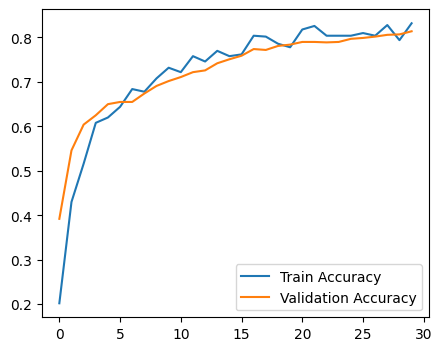

Training Accuracy vs. Validation Accuracy for the model trained on 20% of the training data


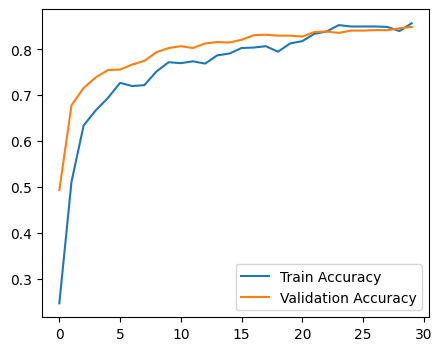

Training Accuracy vs. Validation Accuracy for the model trained on 30% of the training data


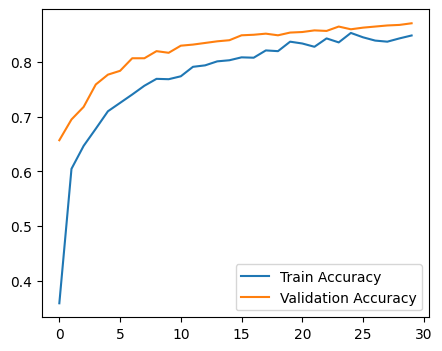

Training Accuracy vs. Validation Accuracy for the model trained on 40% of the training data


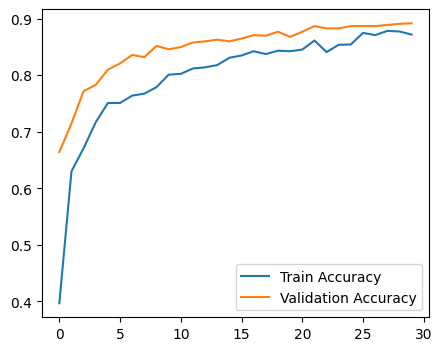

Training Accuracy vs. Validation Accuracy for the model trained on 50% of the training data


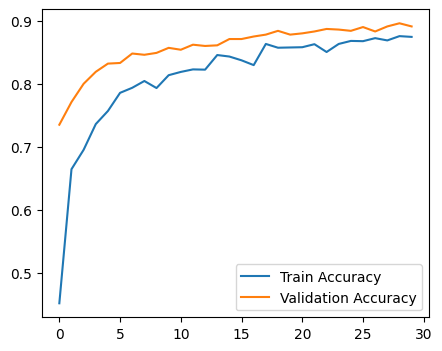

Training Accuracy vs. Validation Accuracy for the model trained on 60% of the training data


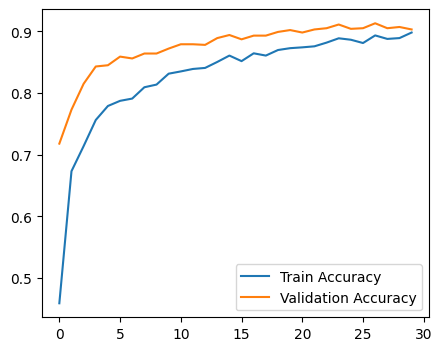

Training Accuracy vs. Validation Accuracy for the model trained on 70% of the training data


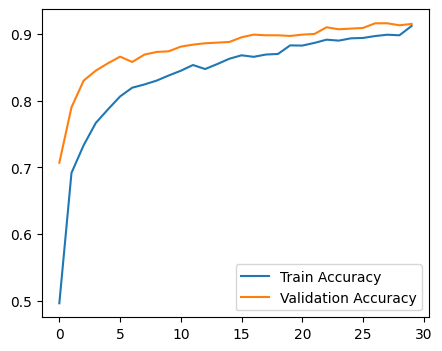

Training Accuracy vs. Validation Accuracy for the model trained on 80% of the training data


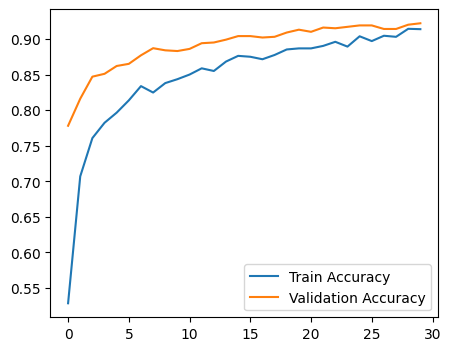

Training Accuracy vs. Validation Accuracy for the model trained on 90% of the training data


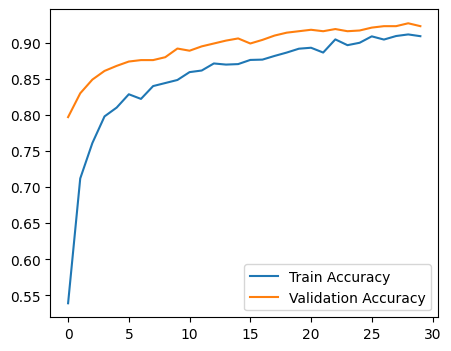

Training Accuracy vs. Validation Accuracy for the model trained on 100% of the training data


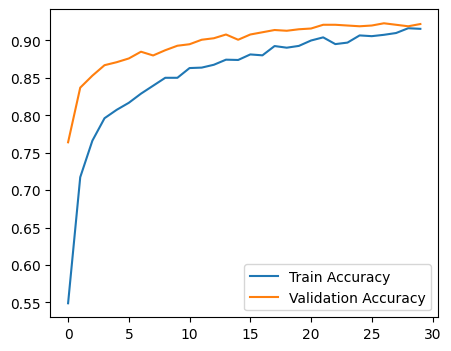

In [ ]:
portion = 10

for i in range(10):
    _, train_acc, _, val_acc = histories[i]
    plt.figure(figsize=(5, 4))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    print(f'Training Accuracy vs. Validation Accuracy for the model trained on {portion}% of the training data')
    plt.show()

    portion += 10

The following codes evaluate the MLPs on the test set.

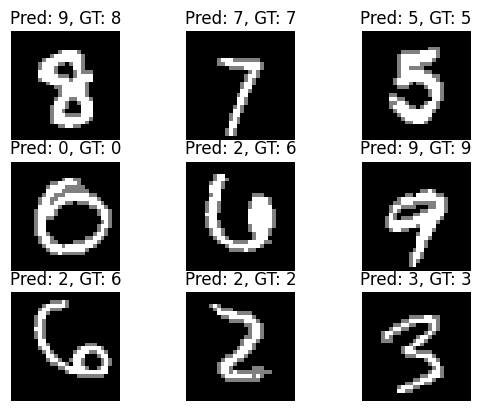

Classification report using the test set for the model trained on 10% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.92      0.87      0.89        90
           1       0.84      0.99      0.91       108
           2       0.75      0.80      0.77       103
           3       0.79      0.79      0.79       100
           4       0.82      0.70      0.75       107
           5       0.64      0.61      0.63        92
           6       0.79      0.76      0.78        91
           7       0.85      0.79      0.82       106
           8       0.78      0.50      0.61       103
           9       0.57      0.83      0.67       100

    accuracy                           0.77      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.77      0.77      0.76      1000



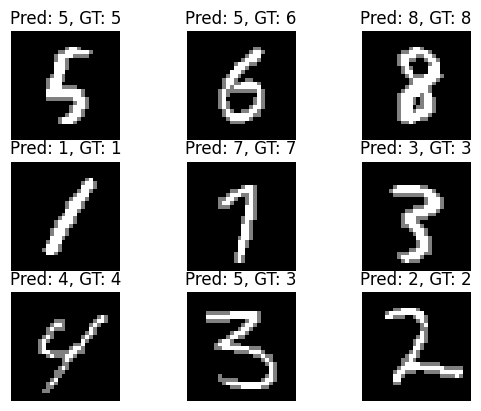

Classification report using the test set for the model trained on 20% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        90
           1       0.92      0.99      0.96       108
           2       0.83      0.83      0.83       103
           3       0.82      0.74      0.78       100
           4       0.83      0.73      0.78       107
           5       0.69      0.72      0.71        92
           6       0.81      0.86      0.83        91
           7       0.85      0.81      0.83       106
           8       0.85      0.73      0.79       103
           9       0.67      0.82      0.74       100

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000



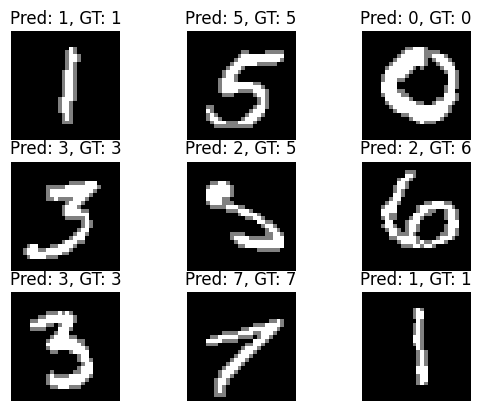

Classification report using the test set for the model trained on 30% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        90
           1       0.94      0.99      0.96       108
           2       0.78      0.86      0.82       103
           3       0.85      0.78      0.81       100
           4       0.85      0.80      0.83       107
           5       0.73      0.75      0.74        92
           6       0.86      0.85      0.85        91
           7       0.85      0.80      0.83       106
           8       0.87      0.73      0.79       103
           9       0.72      0.81      0.76       100

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



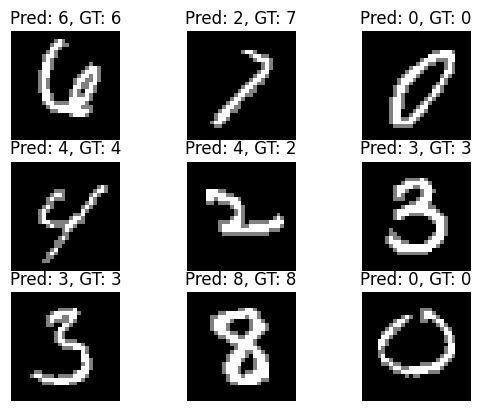

Classification report using the test set for the model trained on 40% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        90
           1       0.95      0.99      0.97       108
           2       0.80      0.86      0.83       103
           3       0.84      0.78      0.81       100
           4       0.83      0.84      0.84       107
           5       0.76      0.80      0.78        92
           6       0.87      0.87      0.87        91
           7       0.85      0.79      0.82       106
           8       0.91      0.66      0.76       103
           9       0.72      0.84      0.78       100

    accuracy                           0.84      1000
   macro avg       0.85      0.84      0.84      1000
weighted avg       0.85      0.84      0.84      1000



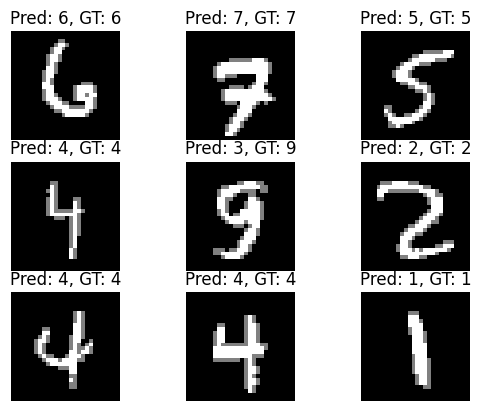

Classification report using the test set for the model trained on 50% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        90
           1       0.96      0.99      0.97       108
           2       0.85      0.85      0.85       103
           3       0.87      0.80      0.83       100
           4       0.89      0.87      0.88       107
           5       0.79      0.84      0.81        92
           6       0.88      0.93      0.90        91
           7       0.83      0.84      0.84       106
           8       0.90      0.75      0.81       103
           9       0.78      0.82      0.80       100

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



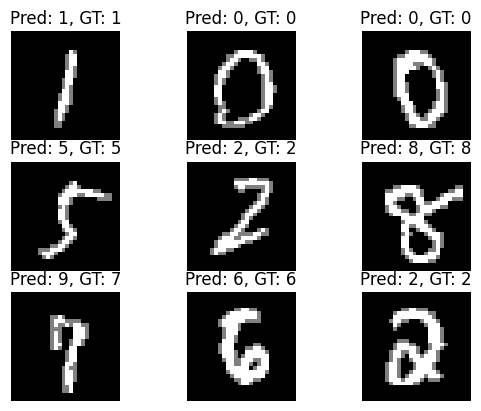

Classification report using the test set for the model trained on 60% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        90
           1       0.96      0.99      0.98       108
           2       0.82      0.88      0.85       103
           3       0.88      0.82      0.85       100
           4       0.87      0.90      0.88       107
           5       0.84      0.85      0.84        92
           6       0.88      0.92      0.90        91
           7       0.85      0.83      0.84       106
           8       0.91      0.71      0.80       103
           9       0.81      0.86      0.83       100

    accuracy                           0.87      1000
   macro avg       0.87      0.88      0.87      1000
weighted avg       0.88      0.87      0.87      1000



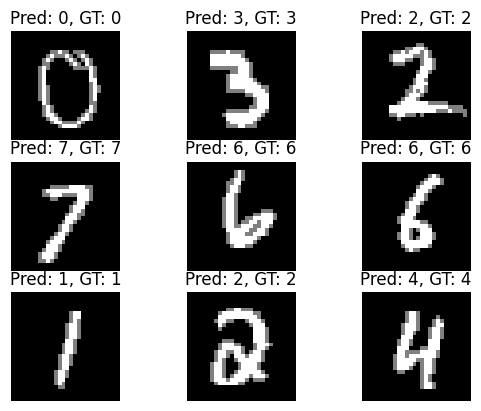

Classification report using the test set for the model trained on 70% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        90
           1       0.96      0.99      0.97       108
           2       0.86      0.87      0.87       103
           3       0.87      0.84      0.85       100
           4       0.89      0.90      0.89       107
           5       0.84      0.89      0.86        92
           6       0.88      0.90      0.89        91
           7       0.89      0.85      0.87       106
           8       0.91      0.80      0.85       103
           9       0.86      0.87      0.87       100

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



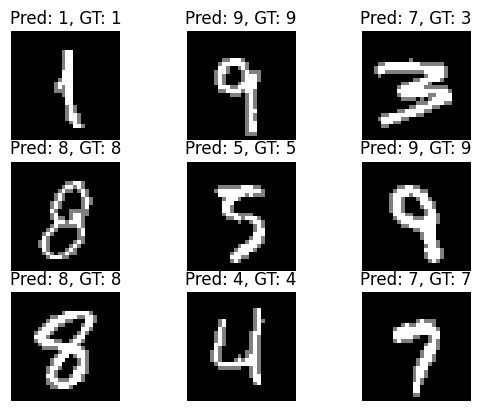

Classification report using the test set for the model trained on 80% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        90
           1       0.96      0.99      0.98       108
           2       0.90      0.90      0.90       103
           3       0.84      0.85      0.85       100
           4       0.93      0.89      0.91       107
           5       0.86      0.90      0.88        92
           6       0.88      0.92      0.90        91
           7       0.89      0.87      0.88       106
           8       0.92      0.81      0.86       103
           9       0.84      0.89      0.86       100

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



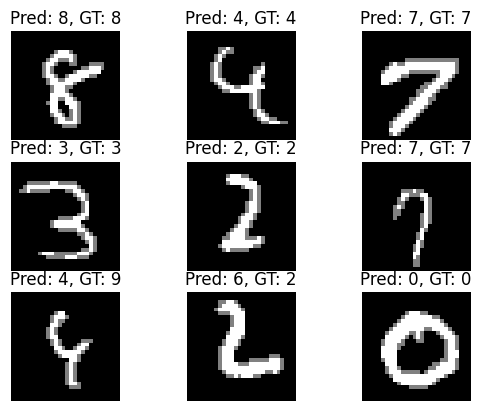

Classification report using the test set for the model trained on 90% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        90
           1       0.96      0.98      0.97       108
           2       0.91      0.89      0.90       103
           3       0.84      0.87      0.86       100
           4       0.92      0.91      0.91       107
           5       0.87      0.88      0.88        92
           6       0.88      0.93      0.90        91
           7       0.89      0.85      0.87       106
           8       0.92      0.82      0.87       103
           9       0.87      0.90      0.88       100

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



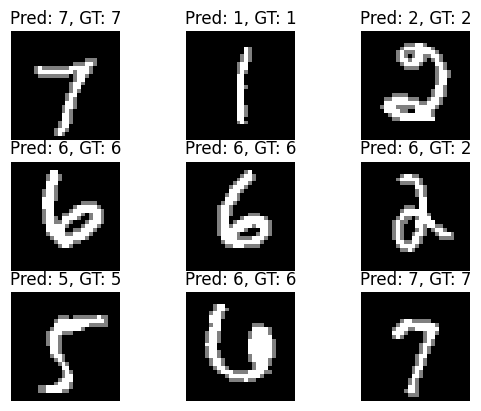

Classification report using the test set for the model trained on 100% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        90
           1       0.96      0.99      0.98       108
           2       0.89      0.91      0.90       103
           3       0.85      0.88      0.86       100
           4       0.91      0.91      0.91       107
           5       0.91      0.87      0.89        92
           6       0.89      0.95      0.91        91
           7       0.91      0.85      0.88       106
           8       0.93      0.83      0.88       103
           9       0.85      0.88      0.87       100

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.90      1000
weighted avg       0.91      0.91      0.90      1000



In [ ]:
portion = 10
cms = []

for mlp_model in mlp_models:
    fig, ax = plt.subplots(3, 3)
    ids = np.random.randint(size=9, low=0, high=len(digits_test_ds))
    imgs, labels = digits_test_ds[:]
    preds, acc, _, _, _, cm = evaluate(mlp_model, digits_test_ds, normalize=True)
    cms.append(cm)

    for i in range(9):
        j = np.random.randint(low=0, high=len(digits_test_ds))
        ax[i // 3, i % 3].imshow(imgs[ids[i]], cmap='gray')
        ax[i // 3, i % 3].set_title(f'Pred: {preds[ids[i]]}, GT: {labels[ids[i]]}')
        ax[i // 3, i % 3].axis('off')
    plt.show()

    print(f'Classification report using the test set for the model trained on {portion}% of the training data:')
    print('###########################################################################################')
    print(classification_report(labels, preds))

    portion += 10

Confusion matrix for the model trained on 10% of the training data:


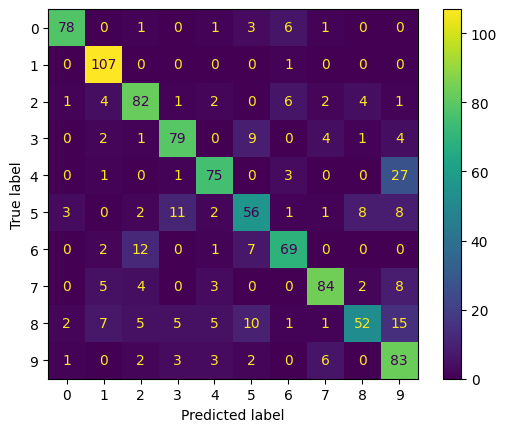

Confusion matrix for the model trained on 20% of the training data:


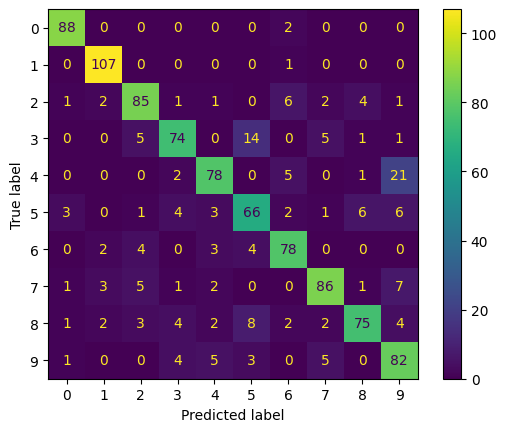

Confusion matrix for the model trained on 30% of the training data:


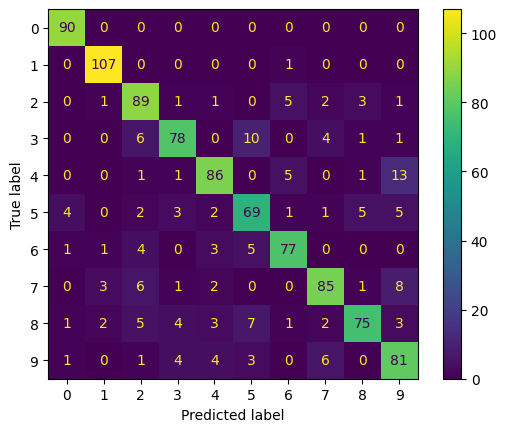

Confusion matrix for the model trained on 40% of the training data:


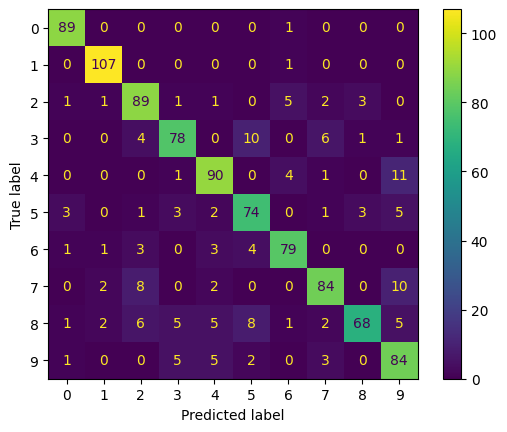

Confusion matrix for the model trained on 50% of the training data:


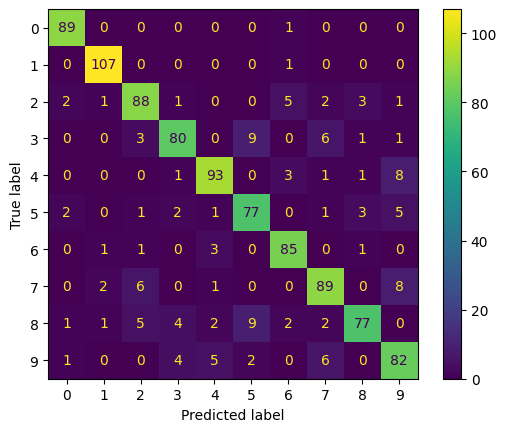

Confusion matrix for the model trained on 60% of the training data:


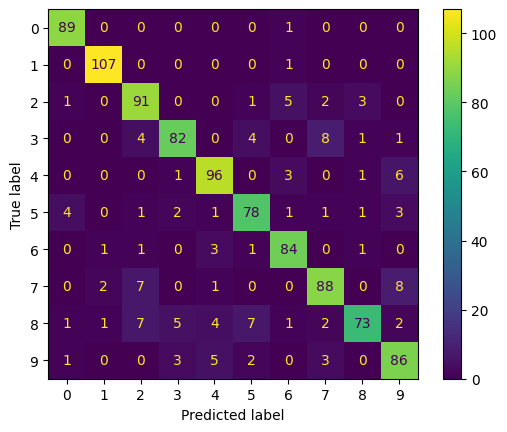

Confusion matrix for the model trained on 70% of the training data:


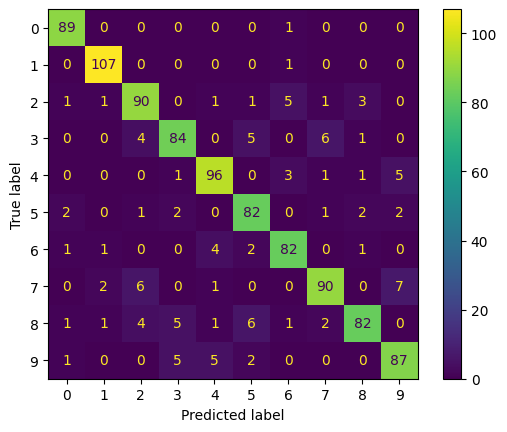

Confusion matrix for the model trained on 80% of the training data:


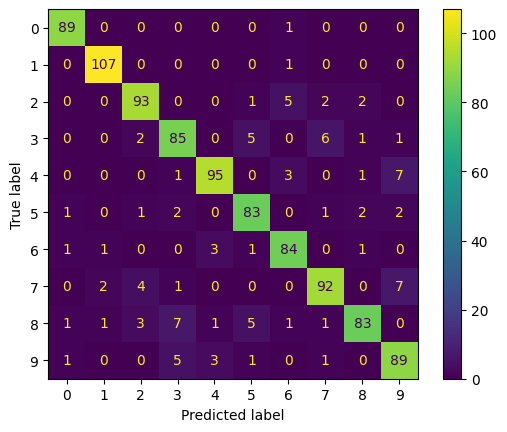

Confusion matrix for the model trained on 90% of the training data:


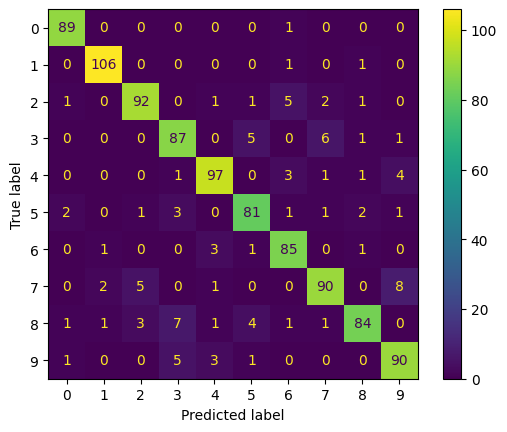

Confusion matrix for the model trained on 100% of the training data:


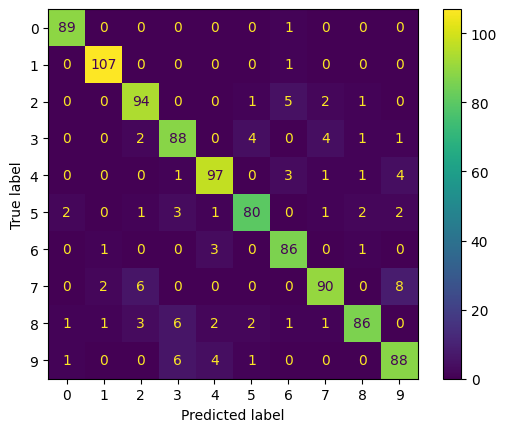

In [ ]:
portion = 10

for cm in cms:
    print(f'Confusion matrix for the model trained on {portion}% of the training data:')
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.show()
    portion += 10

It seems that the more data is provided, the more the models have learned about the data, which again proves the capability of MLPs compared to the Naive Bayes model. The highest accuracy on the test data is 91% using an MLP.

#### Training and Testing with the Faces Dataset

It was quite hard to train the faces dataset with an MLP, which I assume is because of the smaller size of the dataset. When the previous MLP was used, the model tried to overfit to the training data all the time. So, I added two hidden layers with dropouts in between. A dropout was added following the first hidden layer because the number of features 4200 are reduced to 1024 and this will add noise to the network. Another dropout is added after the second hidden layer in order to prevent from overfitting.

I also increased the probability of random rotations and the range of rotations so that the model can generalize more on the data due to the added randomness. I've used LeakyReLU instead of ReLU activation because LeakyReLU activation is well-known to reduce overfitting and improve the generalization performance of the network.

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, num_classes, device, keep_prob=0.5):
        super(MLPClassifier, self).__init__()

        self.input_size = input_size
        self.device = device
        self.num_classes = num_classes

        self.fc1 = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.Dropout(keep_prob),
            nn.LeakyReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.Dropout(0.25),
            nn.LeakyReLU()
        )
        self.fc3 = nn.Linear(512, 2)

    def forward(self, x):
        x = x.reshape((-1, self.input_size))
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

    def train_mlp(self, train_loader, loss_fn, optimizer, num_epochs, val_loader=None, verbose=True):
        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []

        for epoch in range(num_epochs):
            batch_loss = 0
            batch_acc = 0
            total_samples = 0

            progbar = Progbar(len(train_loader))
            metrics = {}
            if verbose or epoch == num_epochs - 1:
                print(f"Epoch [{epoch + 1}/{num_epochs}]")
            if verbose:
                progbar.update(0, metrics.items(), finalize=False)

            self.train()

            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()

                outputs = self(inputs)
                loss = loss_fn(outputs, labels)

                loss.backward()
                optimizer.step()

                total_samples += inputs.shape[0]
                batch_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                batch_acc += (predicted == labels).sum().item()

                metrics.update({"loss": batch_loss / (i + 1), "acc": batch_acc / total_samples})
                if verbose:
                    progbar.update(i + 1, metrics.items(), finalize=False)

            train_loss.append(batch_loss / len(train_loader))
            train_acc.append(batch_acc / len(train_loader.dataset))

            # Validation
            if val_loader is not None:
                val_batch_loss = 0
                val_batch_acc = 0

                with torch.no_grad():
                    self.eval()

                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(self.device), labels.to(self.device)

                        outputs = self(inputs)
                        loss = loss_fn(outputs, labels)

                        val_batch_loss += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        val_batch_acc += (predicted == labels).sum().item()

                val_loss.append(val_batch_loss / len(val_loader))
                val_acc.append(val_batch_acc / len(val_loader.dataset))

                metrics.update({"val_loss": val_loss[-1], "val_acc": val_acc[-1]})
                if verbose:
                    progbar.update(i + 1, metrics.items(), finalize=False)

            if verbose or epoch == num_epochs - 1:
                progbar.update(i + 1, metrics.items(), finalize=True)

        return train_loss, train_acc, val_loss, val_acc

    def predict(self, images, gt_labels=None, normalize=False):
        '''
        Compute class probabilities for each image in the batch.
        '''
        self.eval()

        if isinstance(images, np.ndarray):
            images = torch.from_numpy(images)
        images = images.to(self.device)

        if normalize:
            images = images.to(torch.float32)
            images = (images - images.min()) / (images.max() - images.min())

        # Forward pass through the model.
        output = self(images.view(images.shape[0], -1))

        # Compute the class probabilities and predictions.
        class_probs = F.softmax(output, dim=1)
        preds = class_probs.argmax(dim=1)

        # Return the class predictions and accuracies.
        if gt_labels is not None:
            if isinstance(gt_labels, np.ndarray):
                gt_labels = torch.from_numpy(gt_labels)
            return preds, (preds == gt_labels.to(self.device)).sum().item() / images.shape[0]

        return preds

In [ ]:
faces_train_ds = TextDataset('./data/facedata/facedatatrain',
                             './data/facedata/facedatatrainlabels',
                             './data/facedata/train_data',
                             image_size=(70, 60),
                             transforms=transforms.Compose([
                                RandomRotate(prob=0.4, degrees=(-45, 45)),
                                Normalize()
                            ]))
faces_val_ds = TextDataset('./data/facedata/facedatavalidation',
                           './data/facedata/facedatavalidationlabels',
                           './data/facedata/val_data',
                           image_size=(70, 60),
                           transforms=transforms.Compose([
                                Normalize()
                           ]))

In [ ]:
faces_val_dataloader = DataLoader(faces_val_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), drop_last=False)

In [ ]:
num_epochs = 25
learning_rate = 1.0e-4

mlp_models = []
histories = []

portion = 0.1

for i in range(10):
    faces_train_dataloader = DataLoader(torch.utils.data.Subset(faces_train_ds, list(range(int(len(faces_train_ds) * portion)))),
                                         batch_size=min(BATCH_SIZE, int(len(faces_train_ds) * portion)),
                                         shuffle=True,
                                         num_workers=os.cpu_count(),
                                         drop_last=False)

    mlp_model = MLPClassifier(input_size=70 * 60, num_classes=2, keep_prob=0.8, device=device).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(mlp_model.parameters(), lr=learning_rate)
    print(f'Training on {int(round(portion * 100))}% of the training data...')
    histories.append(mlp_model.train_mlp(faces_train_dataloader, criterion, optimizer, num_epochs, val_loader=faces_val_dataloader, verbose=False))
    mlp_models.append(mlp_model)

    portion += 0.1

Training on 10% of the training data...
Epoch [25/25]
1/1 [==============================] - 1s 1s/step - loss: 0.5772 - acc: 0.6222 - val_loss: 0.7097 - val_acc: 0.5183
Training on 20% of the training data...
Epoch [25/25]
2/2 [==============================] - 1s 667ms/step - loss: 0.5517 - acc: 0.7556 - val_loss: 0.6189 - val_acc: 0.6146
Training on 30% of the training data...
Epoch [25/25]
3/3 [==============================] - 1s 466ms/step - loss: 0.5141 - acc: 0.8222 - val_loss: 0.5644 - val_acc: 0.8505
Training on 40% of the training data...
Epoch [25/25]
3/3 [==============================] - 2s 508ms/step - loss: 0.4629 - acc: 0.8333 - val_loss: 0.4586 - val_acc: 0.8472
Training on 50% of the training data...
Epoch [25/25]
4/4 [==============================] - 2s 421ms/step - loss: 0.3865 - acc: 0.8711 - val_loss: 0.3968 - val_acc: 0.8505
Training on 60% of the training data...
Epoch [25/25]
5/5 [==============================] - 2s 330ms/step - loss: 0.3375 - acc: 0.8407 - 

By observing the above training statistics, it is obvious that the model has struggled to train with less number of data. With the full training set, it was able to achieve near 90% accuracy and I didn't try to optimize the network any further. The following plots show how the model struggled to capture the features in the data.

Training Loss vs. Validation Loss for the model trained on 10% of the training data


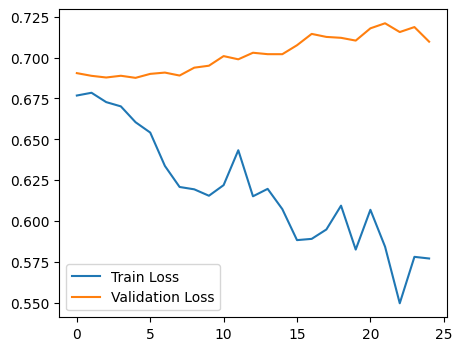

Training Loss vs. Validation Loss for the model trained on 20% of the training data


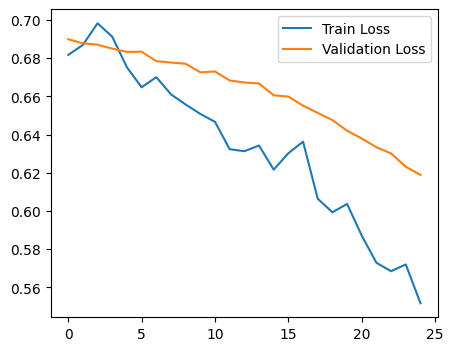

Training Loss vs. Validation Loss for the model trained on 30% of the training data


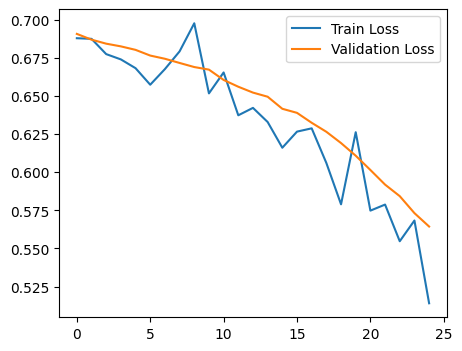

Training Loss vs. Validation Loss for the model trained on 40% of the training data


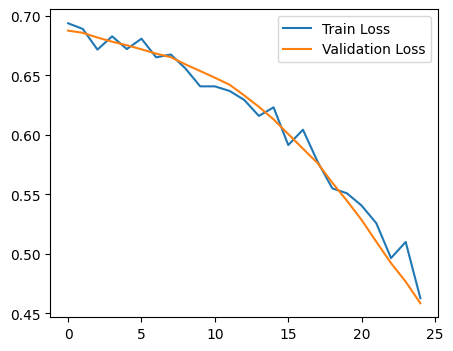

Training Loss vs. Validation Loss for the model trained on 50% of the training data


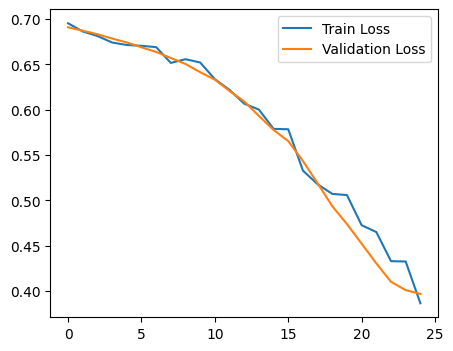

Training Loss vs. Validation Loss for the model trained on 60% of the training data


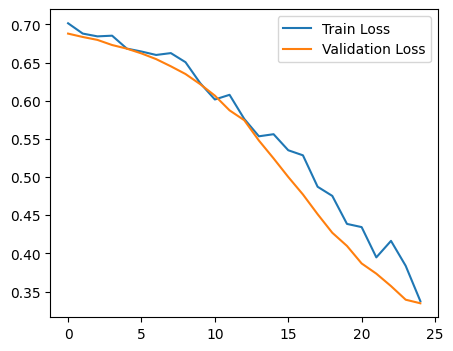

Training Loss vs. Validation Loss for the model trained on 70% of the training data


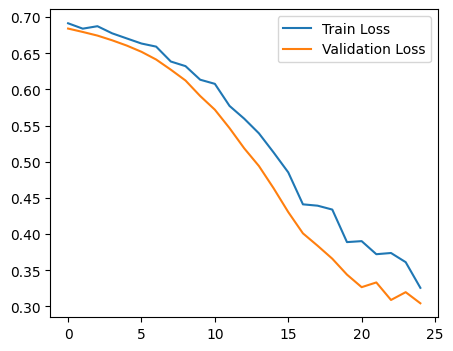

Training Loss vs. Validation Loss for the model trained on 80% of the training data


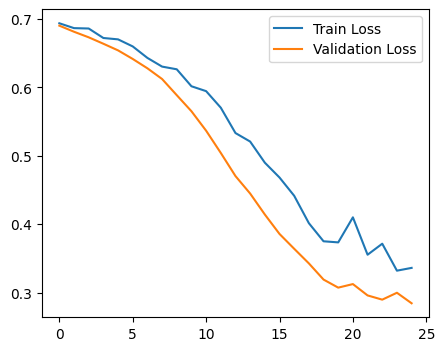

Training Loss vs. Validation Loss for the model trained on 90% of the training data


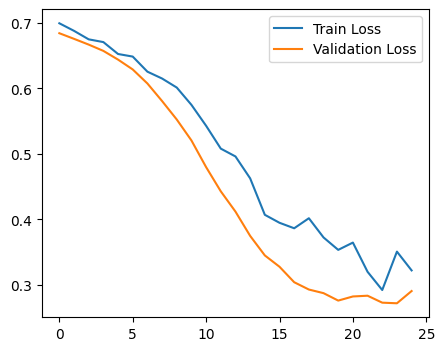

Training Loss vs. Validation Loss for the model trained on 100% of the training data


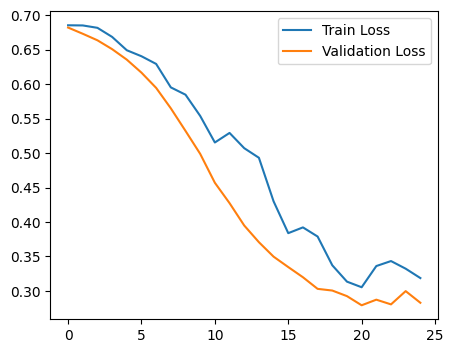

In [ ]:
portion = 10

for i in range(10):
    train_loss, _, val_loss, _ = histories[i]
    plt.figure(figsize=(5, 4))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    print(f'Training Loss vs. Validation Loss for the model trained on {portion}% of the training data')
    plt.show()

    portion += 10

Training Accuracy vs. Validation Accuracy for the model trained on 10% of the training data


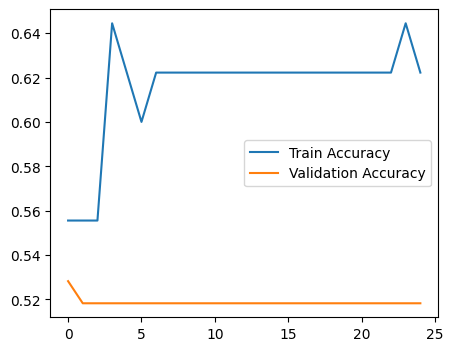

Training Accuracy vs. Validation Accuracy for the model trained on 20% of the training data


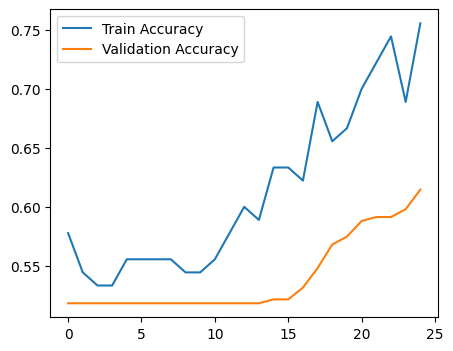

Training Accuracy vs. Validation Accuracy for the model trained on 30% of the training data


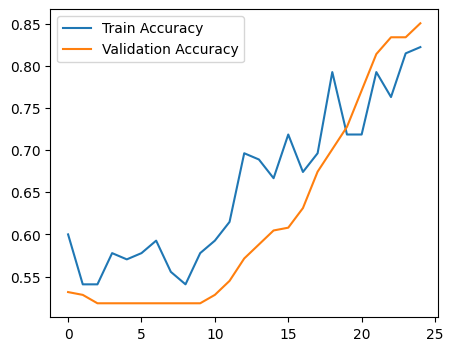

Training Accuracy vs. Validation Accuracy for the model trained on 40% of the training data


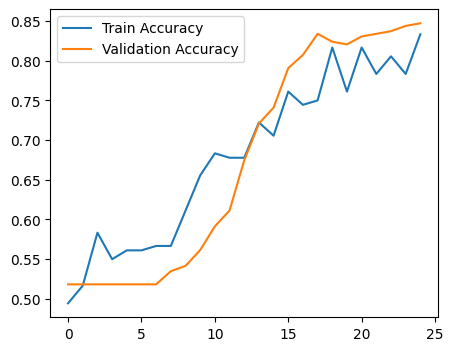

Training Accuracy vs. Validation Accuracy for the model trained on 50% of the training data


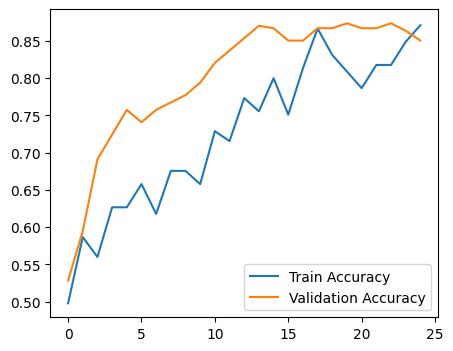

Training Accuracy vs. Validation Accuracy for the model trained on 60% of the training data


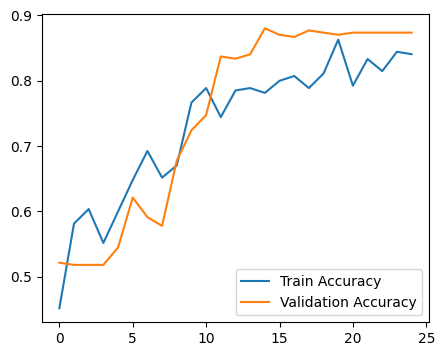

Training Accuracy vs. Validation Accuracy for the model trained on 70% of the training data


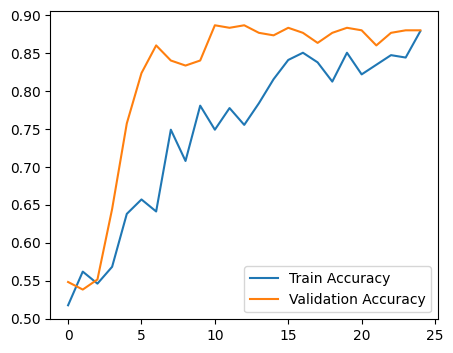

Training Accuracy vs. Validation Accuracy for the model trained on 80% of the training data


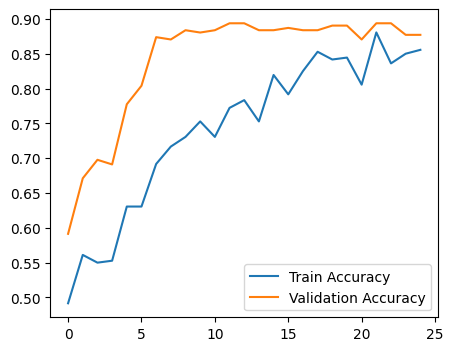

Training Accuracy vs. Validation Accuracy for the model trained on 90% of the training data


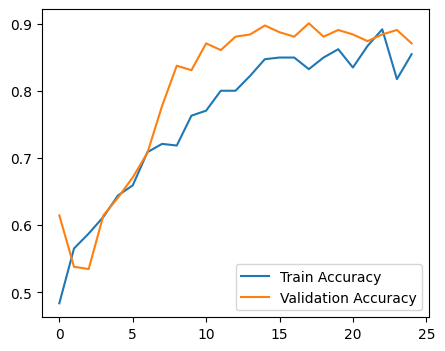

Training Accuracy vs. Validation Accuracy for the model trained on 100% of the training data


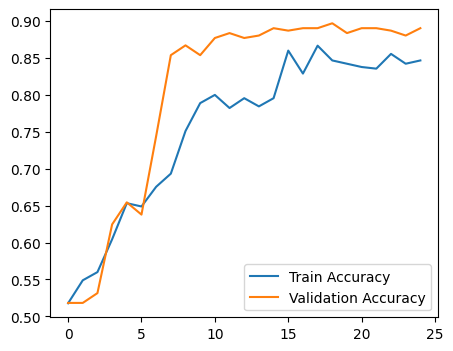

In [ ]:
portion = 10

for i in range(10):
    _, train_acc, _, val_acc = histories[i]
    plt.figure(figsize=(5, 4))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    print(f'Training Accuracy vs. Validation Accuracy for the model trained on {portion}% of the training data')
    plt.show()

    portion += 10

The reason why an MLP may struggle to train on the faces dataset compared to the digits dataset is due to the complexity and variability of the images in the faces dataset. Faces are highly complex and contain a large amount of variation in terms of facial features, and other factors. As a result, training an MLP to accurately classify faces can be difficult due to the large number of possible variations and the need for the network to be able to generalize well to new examples.

On the other hand, the digits dataset is much simpler and contains relatively little variability compared to the faces dataset.

Now let's evaluate the models with the test data.

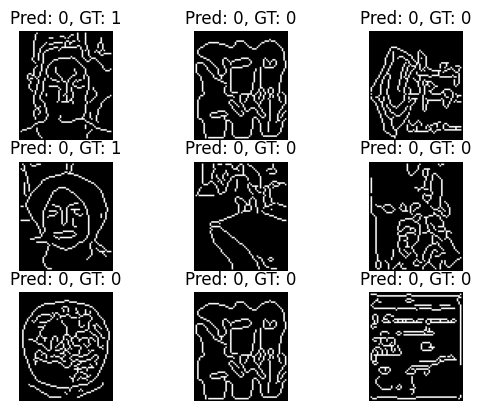

Classification report using the test set for the model trained on 10% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.51      1.00      0.68        77
           1       0.00      0.00      0.00        73

    accuracy                           0.51       150
   macro avg       0.26      0.50      0.34       150
weighted avg       0.26      0.51      0.35       150



/home/sathiiii/.conda/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sathiiii/.conda/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sathiiii/.conda/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

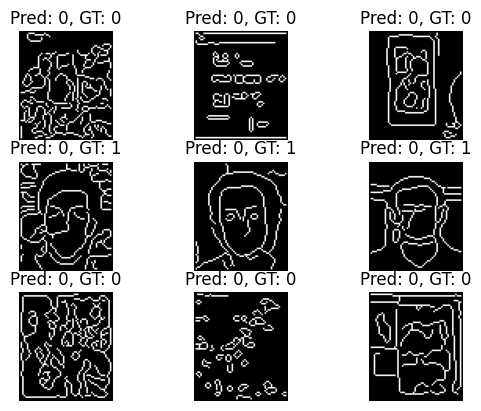

Classification report using the test set for the model trained on 20% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.57      0.96      0.71        77
           1       0.85      0.23      0.37        73

    accuracy                           0.61       150
   macro avg       0.71      0.60      0.54       150
weighted avg       0.71      0.61      0.54       150



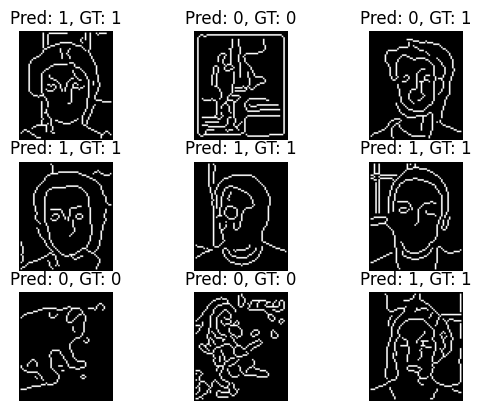

Classification report using the test set for the model trained on 30% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.83      0.88      0.86        77
           1       0.87      0.81      0.84        73

    accuracy                           0.85       150
   macro avg       0.85      0.85      0.85       150
weighted avg       0.85      0.85      0.85       150



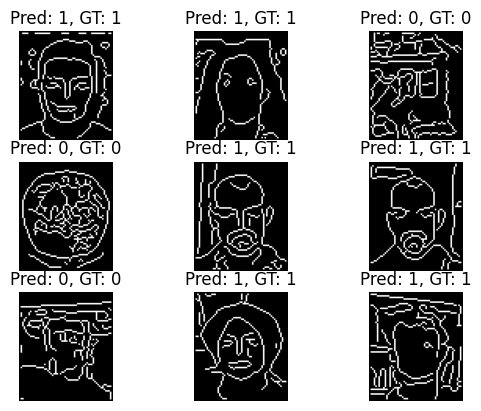

Classification report using the test set for the model trained on 40% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        77
           1       0.87      0.85      0.86        73

    accuracy                           0.87       150
   macro avg       0.87      0.87      0.87       150
weighted avg       0.87      0.87      0.87       150



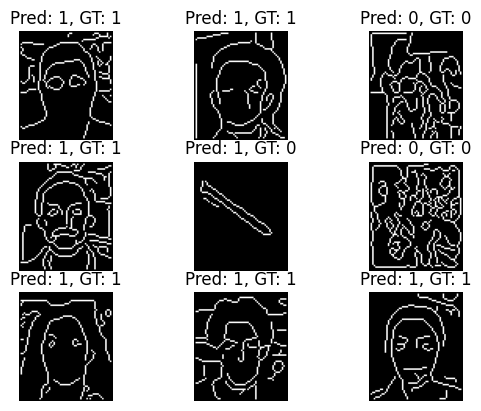

Classification report using the test set for the model trained on 50% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.95      0.77      0.85        77
           1       0.80      0.96      0.87        73

    accuracy                           0.86       150
   macro avg       0.87      0.86      0.86       150
weighted avg       0.88      0.86      0.86       150



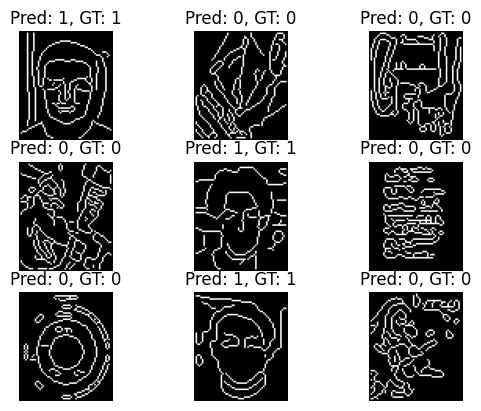

Classification report using the test set for the model trained on 60% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        77
           1       0.91      0.84      0.87        73

    accuracy                           0.88       150
   macro avg       0.88      0.88      0.88       150
weighted avg       0.88      0.88      0.88       150



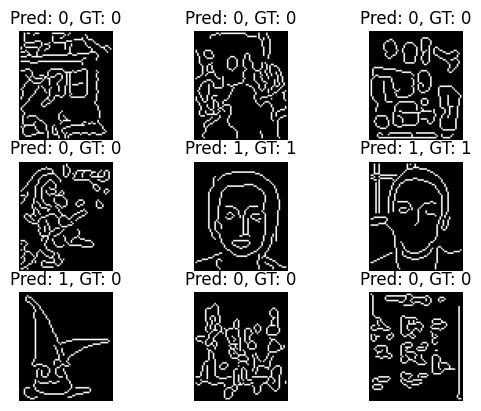

Classification report using the test set for the model trained on 70% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        77
           1       0.89      0.88      0.88        73

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150



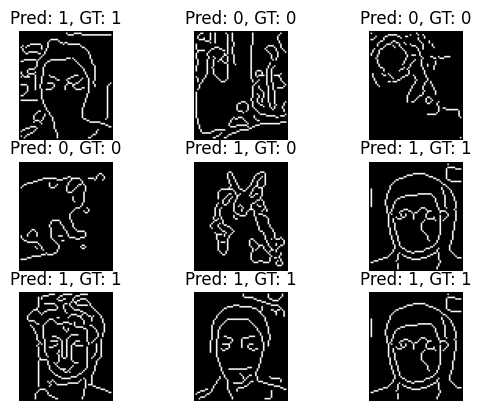

Classification report using the test set for the model trained on 80% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        77
           1       0.89      0.89      0.89        73

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150



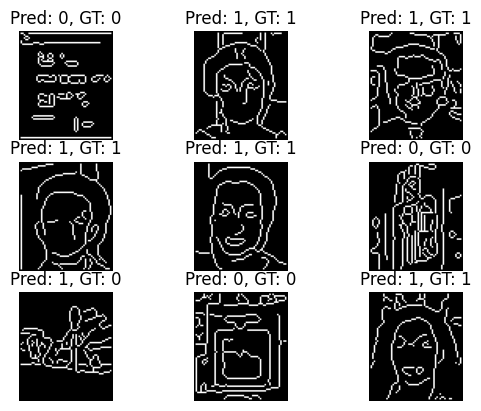

Classification report using the test set for the model trained on 90% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        77
           1       0.91      0.86      0.89        73

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150



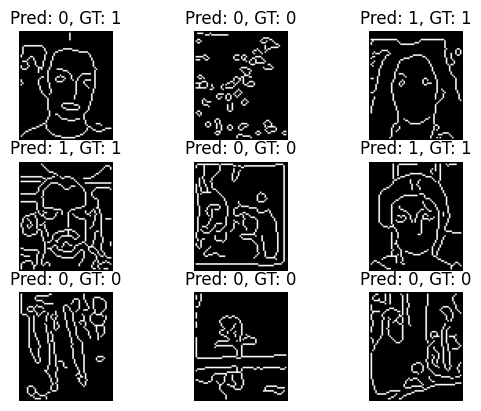

Classification report using the test set for the model trained on 100% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.89      0.88      0.89        77
           1       0.88      0.89      0.88        73

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150



In [ ]:
portion = 10
cms = []

for mlp_model in mlp_models:
    mlp_model.num_classes = 2

    fig, ax = plt.subplots(3, 3)
    ids = np.random.randint(size=9, low=0, high=len(faces_test_ds))
    imgs, labels = faces_test_ds[:]
    preds, acc, _, _, _, cm = evaluate(mlp_model, faces_test_ds, normalize=True)
    cms.append(cm)

    for i in range(9):
        j = np.random.randint(low=0, high=len(faces_test_ds))
        ax[i // 3, i % 3].imshow(imgs[ids[i]], cmap='gray')
        ax[i // 3, i % 3].set_title(f'Pred: {preds[ids[i]]}, GT: {labels[ids[i]]}')
        ax[i // 3, i % 3].axis('off')
    plt.show()

    print(f'Classification report using the test set for the model trained on {portion}% of the training data:')
    print('###########################################################################################')
    print(classification_report(labels, preds))

    portion += 10

Confusion matrix for the model trained on 10% of the training data:


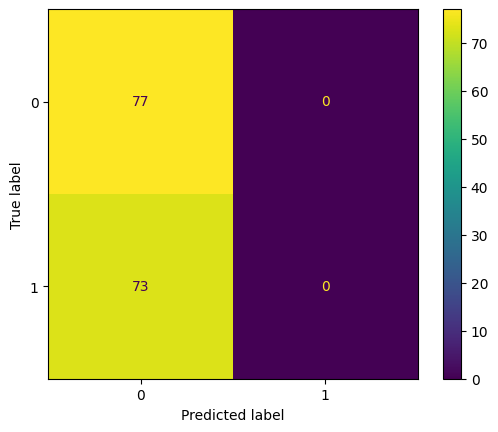

Confusion matrix for the model trained on 20% of the training data:


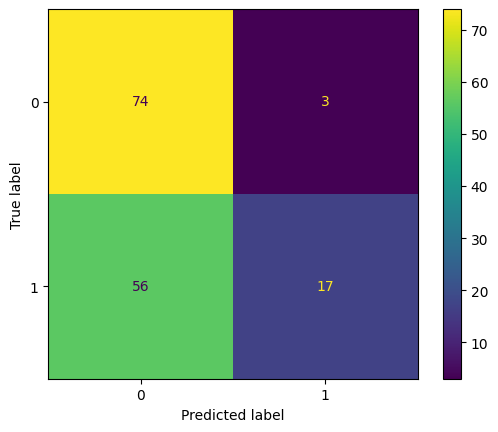

Confusion matrix for the model trained on 30% of the training data:


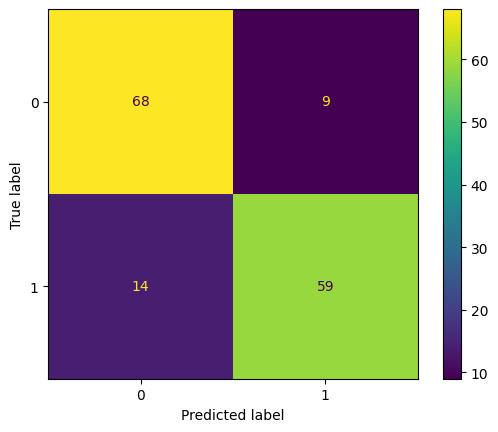

Confusion matrix for the model trained on 40% of the training data:


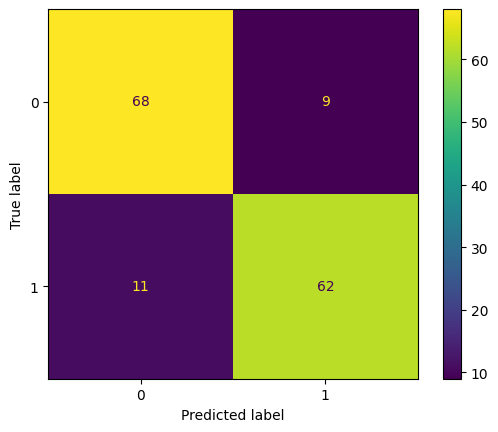

Confusion matrix for the model trained on 50% of the training data:


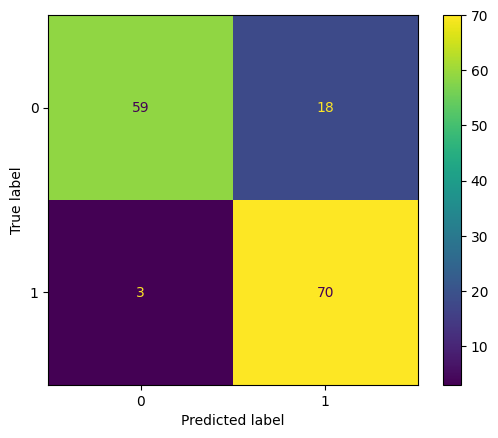

Confusion matrix for the model trained on 60% of the training data:


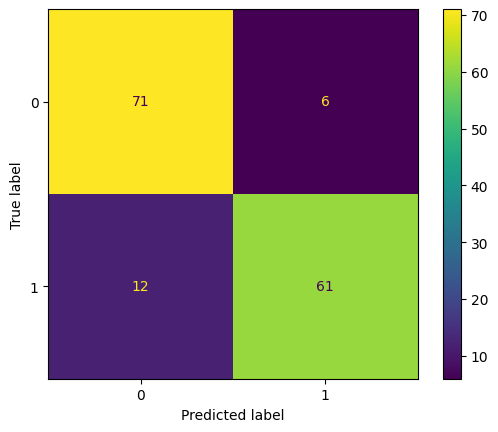

Confusion matrix for the model trained on 70% of the training data:


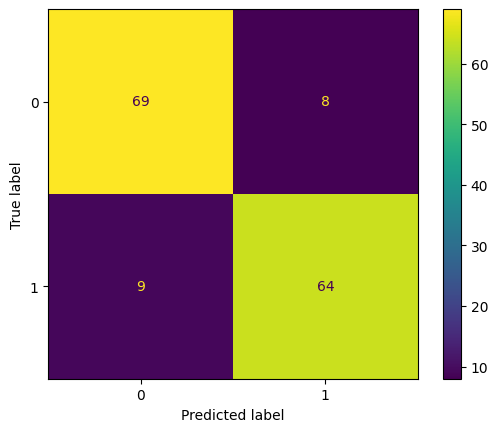

Confusion matrix for the model trained on 80% of the training data:


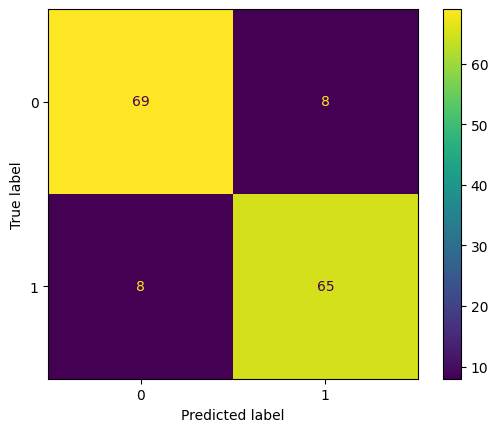

Confusion matrix for the model trained on 90% of the training data:


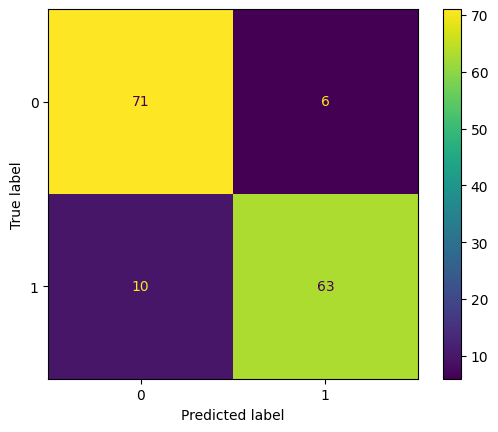

Confusion matrix for the model trained on 100% of the training data:


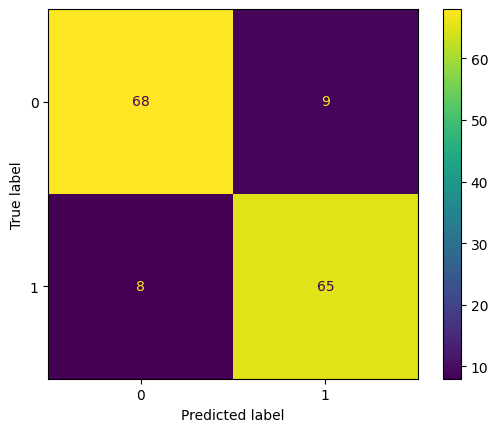

In [ ]:
portion = 10

for cm in cms:
    print(f'Confusion matrix for the model trained on {portion}% of the training data:')
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.show()
    portion += 10

It is interesting to note that the model trained on the 50% of the training data has learned to predict a face when it is a face so well compared to the others. i.e. it has the lowest false positive rate. However, the false negative rate is much higher. The model trained with 100% of the dataset has low and balanced false positive and false negative rate compared to the others, **which means it is not biased towards a specific class**. This is a good sign showing that the model has generalized well.

### (03). CNN Classifier

For the custom model, I will be implementing a simple convolutional neural network (CNN). The model consists of 2 convolutional layers and 3 fully-connected linear layers. The last linear layer is the the classification layer, so logsoftmax is applied to it to get probablity of a certain label being the correct classification.

The following PyTorch module is written from scratch using Pytorch layers.

In [ ]:
import sys

class CNNClassifier(nn.Module):
    def __init__(self, inputSize, num_classes, device):
        super(CNNClassifier, self).__init__()
        self.num_classes = num_classes
        self.device = device
        self.inputSize = inputSize
        # self.c1 = nn.Conv2d(in_channels=1, out_channels = 5, kernel_size=4)

        self.network = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(4, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16*self.inputSize, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        # x = x.reshape((-1, self.input_size))

        x = x.unsqueeze(1)
        # print(x.shape)
        t = self.network(x)
        # print(t.shape)
        return t

    def trainCNN(self, train_loader, loss_fn, optimizer, num_epochs, val_loader=None, verbose=True):
        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []

        for epoch in range(num_epochs):
            batch_loss = 0
            batch_acc = 0
            total_samples = 0

            progbar = Progbar(len(train_loader))
            metrics = {}
            if verbose or epoch == num_epochs - 1:
                print(f"Epoch [{epoch + 1}/{num_epochs}]")
            if verbose:
                progbar.update(0, metrics.items(), finalize=False)

            self.train()

            for i, (inputs, labels) in enumerate(train_loader):
                # print(inputs)
                # print(labels)
                # sys.exit()
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()

                outputs = self.forward(inputs)
                loss = loss_fn(outputs, labels)

                loss.backward()
                optimizer.step()

                total_samples += inputs.shape[0]
                batch_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                batch_acc += (predicted == labels).sum().item()

                metrics.update({"loss": batch_loss / (i + 1), "acc": batch_acc / total_samples})
                if verbose:
                    progbar.update(i + 1, metrics.items(), finalize=False)

            train_loss.append(batch_loss / len(train_loader))
            train_acc.append(batch_acc / len(train_loader.dataset))

            # Validation
            if val_loader is not None:
                val_batch_loss = 0
                val_batch_acc = 0

                with torch.no_grad():
                    self.eval()

                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(self.device), labels.to(self.device)

                        outputs = self.forward(inputs)
                        loss = loss_fn(outputs, labels)

                        val_batch_loss += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        val_batch_acc += (predicted == labels).sum().item()

                val_loss.append(val_batch_loss / len(val_loader))
                val_acc.append(val_batch_acc / len(val_loader.dataset))

                metrics.update({"val_loss": val_loss[-1], "val_acc": val_acc[-1]})
                if verbose:
                    progbar.update(i + 1, metrics.items(), finalize=False)

            if verbose or epoch == num_epochs - 1:
                progbar.update(i + 1, metrics.items(), finalize=True)

        return train_loss, train_acc, val_loss, val_acc
    def predict(self, images, gt_labels=None, normalize=False):
        '''
        Compute class probabilities for each image in the batch.
        '''
        self.eval()

        if isinstance(images, np.ndarray):
            images = torch.from_numpy(images)
        images = images.to(self.device)

        if normalize:
            images = images.to(torch.float32)
            images = (images - images.min()) / (images.max() - images.min())

        # Forward pass through the model.
        # output = self(images.view(images.shape[0], -1))
        output = self.forward(images)

        # Compute the class probabilities and predictions.
        # class_probs = F.softmax(output, dim=1)
        preds = output.argmax(dim=1)

        # Return the class predictions and accuracies.
        if gt_labels is not None:
            if isinstance(gt_labels, np.ndarray):
                gt_labels = torch.from_numpy(gt_labels)
            return preds, (preds == gt_labels.to(self.device)).sum().item() / images.shape[0]

        return preds

#### Training and Testing with the Digits Dataset

I'm normalizing the images to (0,1) because it helps th emodel converge quicker. The convolutional neural network is trained on the 10 different portions of the training dataset for 30 epochs. All the hyperparameters were chosen experimentally.

In [ ]:
digits_train_ds = TextDataset('./data/digitdata/trainingimages',
                              './data/digitdata/traininglabels',
                              './data/digitdata/train_data',
                              image_size=(28, 28),
                              transforms=transforms.Compose([

                                  Normalize(),

                              ]))
digits_val_ds = TextDataset('./data/digitdata/validationimages',
                            './data/digitdata/validationlabels',
                            './data/digitdata/val_data',
                            image_size=(28, 28),
                            transforms=transforms.Compose([
                                Normalize()
                            ]))

digits_val_dataloader = DataLoader(digits_val_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
num_epochs = 30
learning_rate = 2.0e-4
portion = 0.1
cnnModels = []
histories = []

for i in range(10):
    digits_train_dataloader = DataLoader(torch.utils.data.Subset(digits_train_ds, list(range(int(len(digits_train_ds) * portion)))),
                                            batch_size=min(BATCH_SIZE, int(len(digits_train_ds) * portion)),
                                            shuffle=True,
                                            #num_workers=os.cpu_count(),
                                            drop_last=False)


    m = CNNClassifier(28*28, 10, device).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(m.parameters(), lr=learning_rate)
    # print(m)
    # t = np.array(digits_test_ds[0])
    # print(t[1])
    # print(t.shape)
    # print(m.forward(t))
    histories.append(m.trainCNN(digits_train_dataloader, criterion, optimizer, num_epochs, digits_val_dataloader, verbose=False))
    cnnModels.append(m)
    portion = portion + 0.1
    #histories.append(m.trainCNN(digits_train_dataloader, criterion, optimizer, num_epochs, val_loader=digits_val_dataloader, verbose=False))


Epoch [30/30]
8/8 [==============================] - 1s 119ms/step - loss: 0.0943 - acc: 0.9800 - val_loss: 0.5646 - val_acc: 0.8310
Epoch [30/30]
16/16 [==============================] - 2s 96ms/step - loss: 0.0467 - acc: 0.9950 - val_loss: 0.3803 - val_acc: 0.8790
Epoch [30/30]
24/24 [==============================] - 3s 106ms/step - loss: 0.1438 - acc: 0.9567 - val_loss: 0.4145 - val_acc: 0.8830
Epoch [30/30]
32/32 [==============================] - 3s 104ms/step - loss: 0.0074 - acc: 1.0000 - val_loss: 0.3746 - val_acc: 0.9100
Epoch [30/30]
40/40 [==============================] - 4s 100ms/step - loss: 0.0480 - acc: 0.9936 - val_loss: 0.4274 - val_acc: 0.8920
Epoch [30/30]
47/47 [==============================] - 5s 110ms/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.3089 - val_acc: 0.9350
Epoch [30/30]
55/55 [==============================] - 6s 101ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.3063 - val_acc: 0.9330
Epoch [30/30]
63/63 [==============================] - 6s 

The CNN trained on 100% of the training data, achieved a validation accuracy of 94.7%. The model was overfitting on the training data in all portion sizes. The addition of a dropout layer after the first linear layer should help with this. The CNN has a comperable accuracy compared with the MLP after being trained on only 10% of the dataset.

Training Loss vs. Validation Loss for the model trained on 10% of the training data


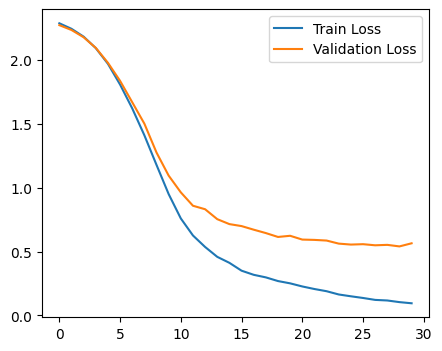

Training Loss vs. Validation Loss for the model trained on 20% of the training data


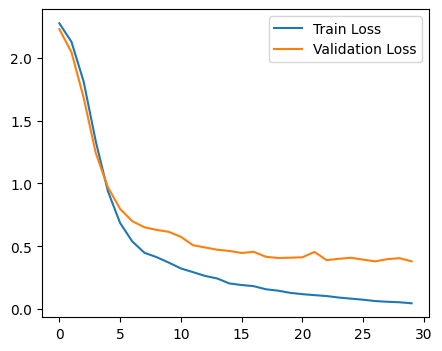

Training Loss vs. Validation Loss for the model trained on 30% of the training data


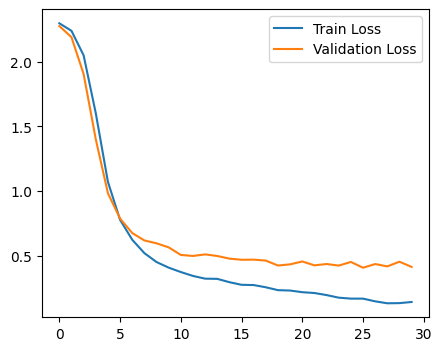

Training Loss vs. Validation Loss for the model trained on 40% of the training data


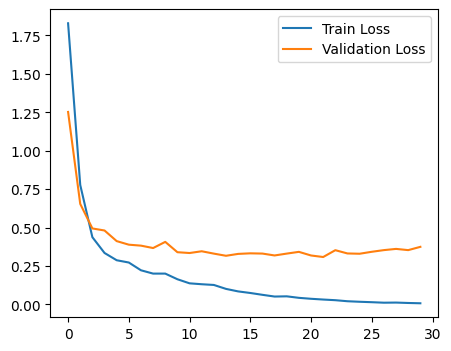

Training Loss vs. Validation Loss for the model trained on 50% of the training data


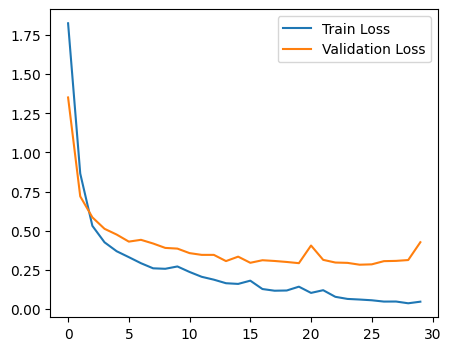

Training Loss vs. Validation Loss for the model trained on 60% of the training data


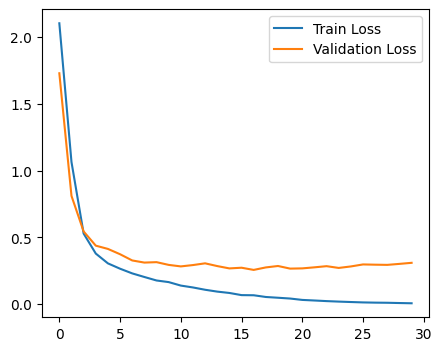

Training Loss vs. Validation Loss for the model trained on 70% of the training data


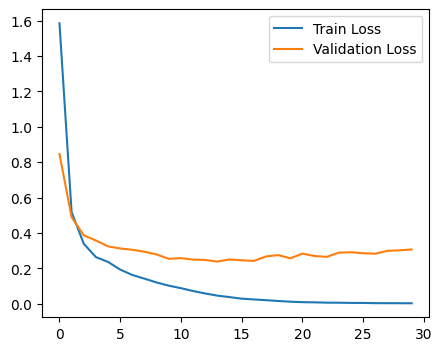

Training Loss vs. Validation Loss for the model trained on 80% of the training data


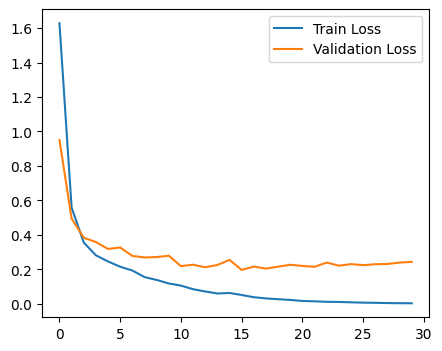

Training Loss vs. Validation Loss for the model trained on 90% of the training data


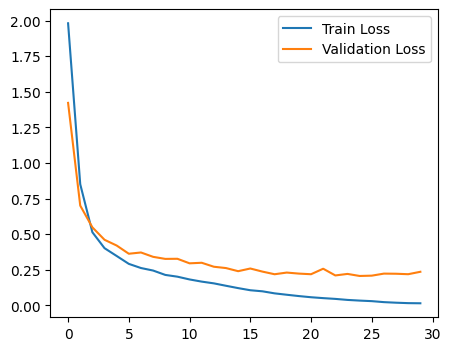

Training Loss vs. Validation Loss for the model trained on 100% of the training data


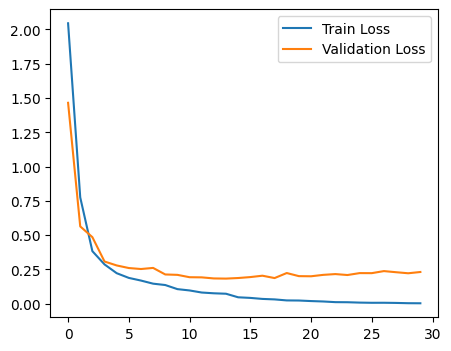

In [ ]:
portion = 10

for i in range(10):
    train_loss, _, val_loss, _ = histories[i]
    plt.figure(figsize=(5, 4))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    print(f'Training Loss vs. Validation Loss for the model trained on {portion}% of the training data')
    plt.show()

    portion += 10

As mentioned before, overfitting is prevelent throughout the training process. This can be validated by the the validation loss converging higher than the training loss.

Now, let's look at how the accuracies got improved over time.

Training Accuracy vs. Validation Accuracy for the model trained on 10% of the training data


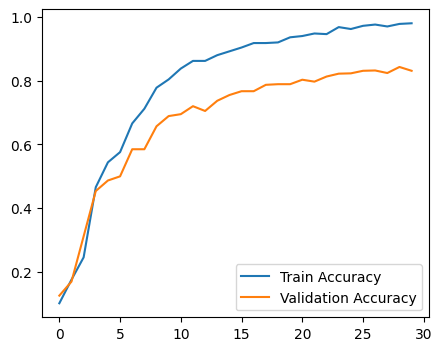

Training Accuracy vs. Validation Accuracy for the model trained on 20% of the training data


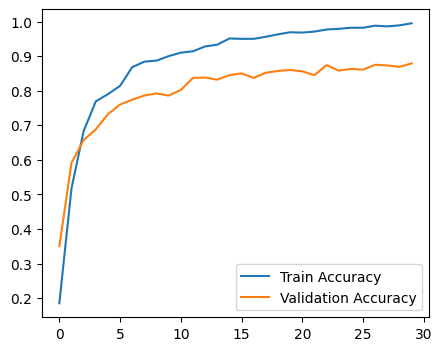

Training Accuracy vs. Validation Accuracy for the model trained on 30% of the training data


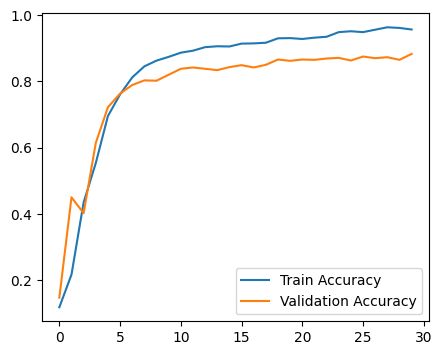

Training Accuracy vs. Validation Accuracy for the model trained on 40% of the training data


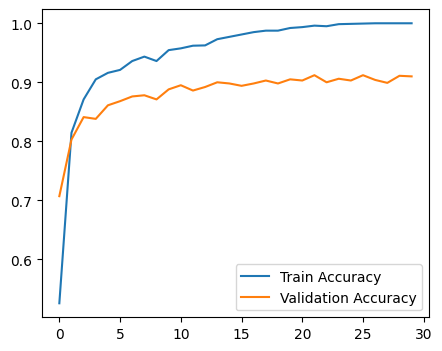

Training Accuracy vs. Validation Accuracy for the model trained on 50% of the training data


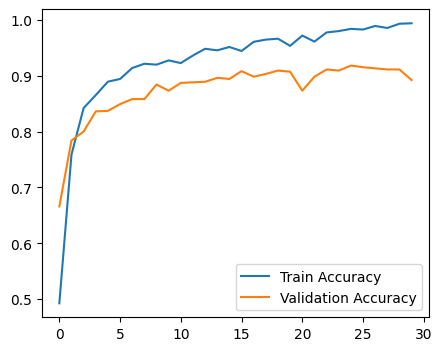

Training Accuracy vs. Validation Accuracy for the model trained on 60% of the training data


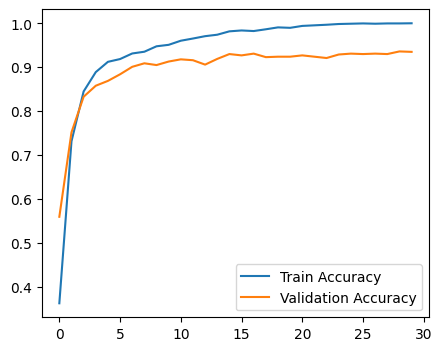

Training Accuracy vs. Validation Accuracy for the model trained on 70% of the training data


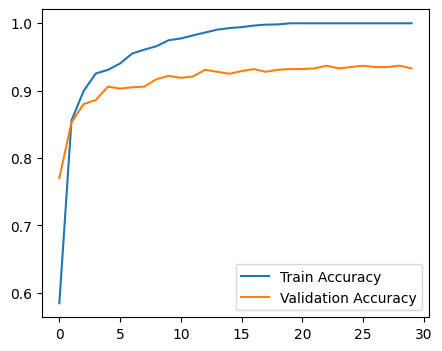

Training Accuracy vs. Validation Accuracy for the model trained on 80% of the training data


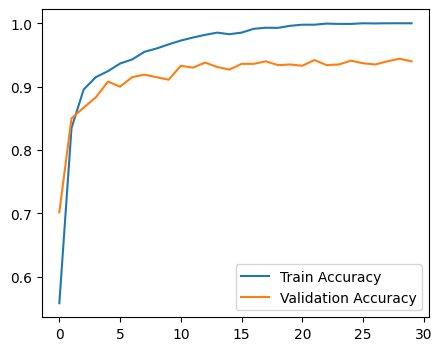

Training Accuracy vs. Validation Accuracy for the model trained on 90% of the training data


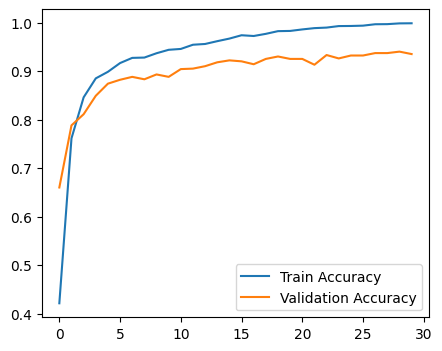

Training Accuracy vs. Validation Accuracy for the model trained on 100% of the training data


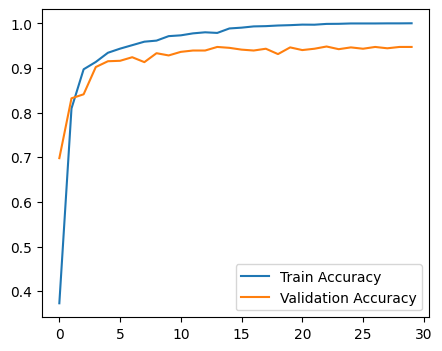

In [ ]:
portion = 10

for i in range(10):
    _, train_acc, _, val_acc = histories[i]
    plt.figure(figsize=(5, 4))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    print(f'Training Accuracy vs. Validation Accuracy for the model trained on {portion}% of the training data')
    plt.show()

    portion += 10

The following code evaluates the CNNs on the test set.

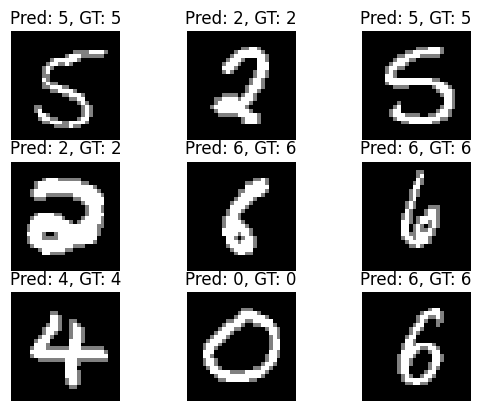

Classification report using the test set for the model trained on 10% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.90      0.91      0.91        90
           1       0.87      0.96      0.91       108
           2       0.79      0.83      0.81       103
           3       0.74      0.84      0.79       100
           4       0.82      0.74      0.78       107
           5       0.73      0.58      0.64        92
           6       0.82      0.85      0.83        91
           7       0.82      0.77      0.80       106
           8       0.76      0.53      0.63       103
           9       0.62      0.83      0.71       100

    accuracy                           0.78      1000
   macro avg       0.79      0.78      0.78      1000
weighted avg       0.79      0.78      0.78      1000



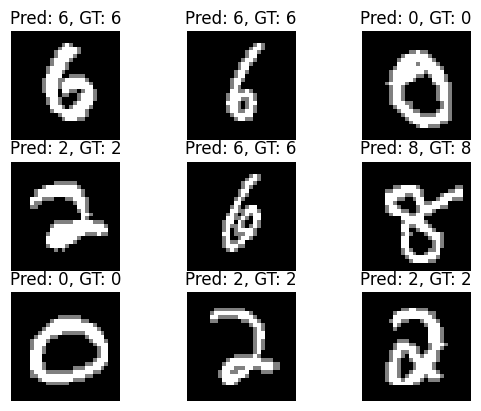

Classification report using the test set for the model trained on 20% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        90
           1       0.93      0.97      0.95       108
           2       0.81      0.92      0.86       103
           3       0.86      0.77      0.81       100
           4       0.90      0.88      0.89       107
           5       0.72      0.82      0.77        92
           6       0.84      0.89      0.86        91
           7       0.88      0.79      0.84       106
           8       0.85      0.66      0.74       103
           9       0.77      0.87      0.82       100

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



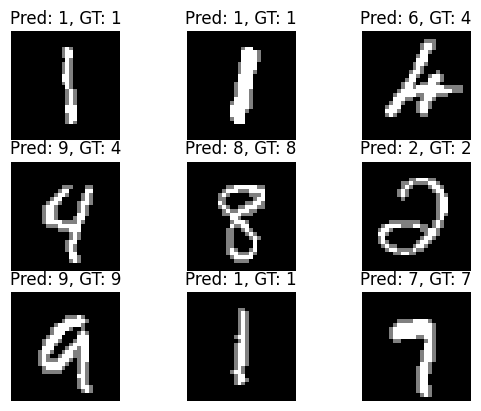

Classification report using the test set for the model trained on 30% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        90
           1       0.88      0.99      0.93       108
           2       0.87      0.83      0.85       103
           3       0.85      0.71      0.77       100
           4       0.86      0.88      0.87       107
           5       0.72      0.75      0.73        92
           6       0.79      0.89      0.84        91
           7       0.86      0.80      0.83       106
           8       0.89      0.74      0.81       103
           9       0.80      0.86      0.83       100

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



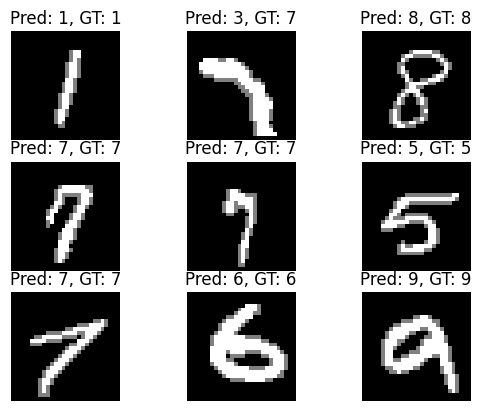

Classification report using the test set for the model trained on 40% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        90
           1       0.96      0.97      0.97       108
           2       0.87      0.93      0.90       103
           3       0.83      0.82      0.82       100
           4       0.87      0.88      0.87       107
           5       0.77      0.84      0.80        92
           6       0.84      0.85      0.84        91
           7       0.87      0.86      0.86       106
           8       0.89      0.71      0.79       103
           9       0.86      0.88      0.87       100

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



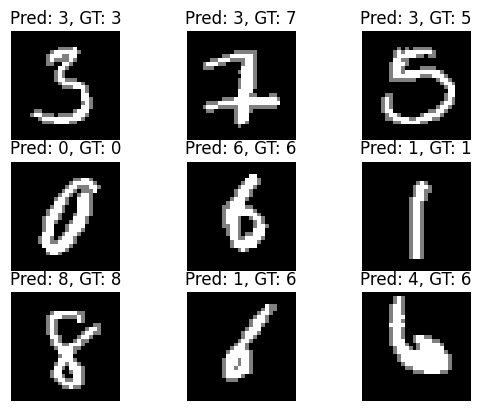

Classification report using the test set for the model trained on 50% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        90
           1       0.93      0.99      0.96       108
           2       0.90      0.94      0.92       103
           3       0.70      0.87      0.77       100
           4       0.87      0.86      0.86       107
           5       0.80      0.80      0.80        92
           6       0.88      0.88      0.88        91
           7       0.84      0.86      0.85       106
           8       0.98      0.49      0.65       103
           9       0.79      0.88      0.83       100

    accuracy                           0.85      1000
   macro avg       0.86      0.85      0.85      1000
weighted avg       0.86      0.85      0.85      1000



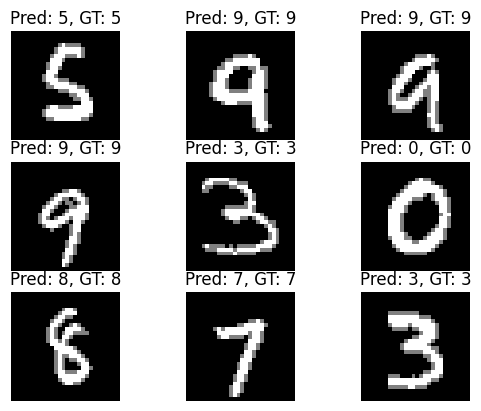

Classification report using the test set for the model trained on 60% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        90
           1       0.95      0.99      0.97       108
           2       0.92      0.95      0.93       103
           3       0.85      0.90      0.87       100
           4       0.88      0.93      0.90       107
           5       0.89      0.91      0.90        92
           6       0.93      0.90      0.92        91
           7       0.91      0.85      0.88       106
           8       0.92      0.80      0.85       103
           9       0.87      0.87      0.87       100

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



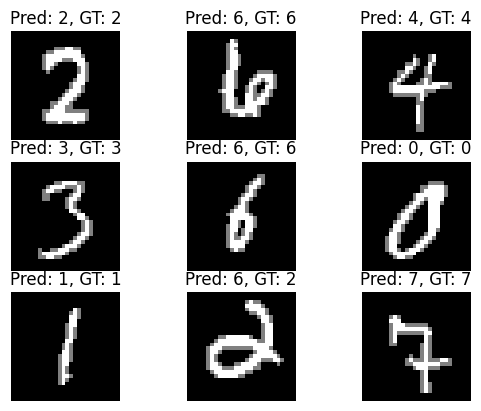

Classification report using the test set for the model trained on 70% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        90
           1       0.95      0.98      0.96       108
           2       0.92      0.95      0.94       103
           3       0.94      0.89      0.91       100
           4       0.86      0.95      0.90       107
           5       0.89      0.98      0.93        92
           6       0.92      0.92      0.92        91
           7       0.93      0.86      0.89       106
           8       0.96      0.83      0.89       103
           9       0.89      0.88      0.88       100

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



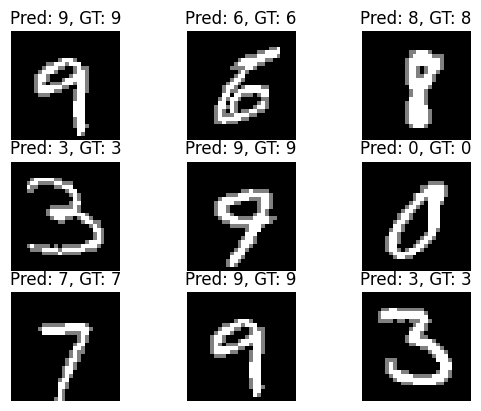

Classification report using the test set for the model trained on 80% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        90
           1       0.96      0.99      0.98       108
           2       0.92      0.95      0.94       103
           3       0.89      0.90      0.90       100
           4       0.94      0.94      0.94       107
           5       0.89      0.91      0.90        92
           6       0.89      0.92      0.91        91
           7       0.91      0.84      0.87       106
           8       0.95      0.87      0.91       103
           9       0.88      0.89      0.89       100

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



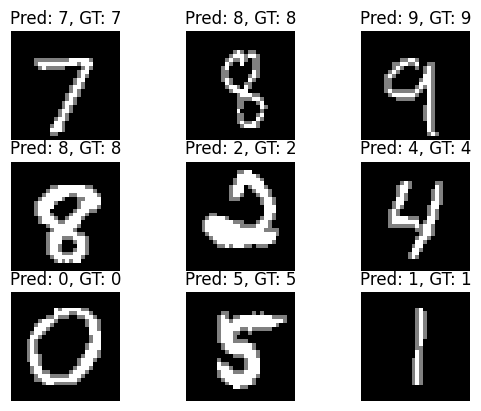

Classification report using the test set for the model trained on 90% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        90
           1       0.94      0.99      0.96       108
           2       0.96      0.93      0.95       103
           3       0.92      0.89      0.90       100
           4       0.93      0.93      0.93       107
           5       0.88      0.95      0.91        92
           6       0.89      0.93      0.91        91
           7       0.93      0.89      0.91       106
           8       0.91      0.81      0.86       103
           9       0.88      0.91      0.89       100

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



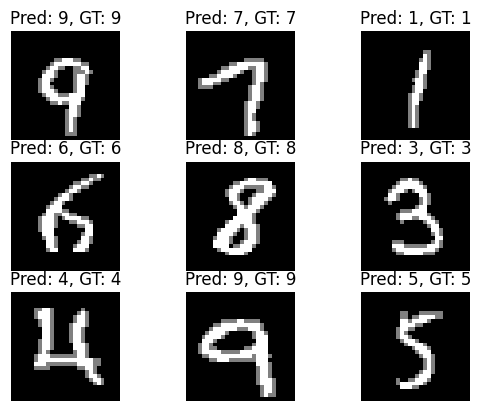

Classification report using the test set for the model trained on 100% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        90
           1       0.96      0.99      0.98       108
           2       0.93      0.97      0.95       103
           3       0.94      0.95      0.95       100
           4       0.94      0.94      0.94       107
           5       0.90      0.92      0.91        92
           6       0.95      0.91      0.93        91
           7       0.88      0.89      0.88       106
           8       0.94      0.87      0.90       103
           9       0.93      0.90      0.91       100

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [ ]:
portion = 10
cms = []

for model in cnnModels:
    fig, ax = plt.subplots(3, 3)
    ids = np.random.randint(size=9, low=0, high=len(digits_test_ds))
    imgs, labels = digits_test_ds[:]
    preds, acc, _, _, _, cm = evaluate(model, digits_test_ds, normalize=True)
    cms.append(cm)

    for i in range(9):
        j = np.random.randint(low=0, high=len(digits_test_ds))
        ax[i // 3, i % 3].imshow(imgs[ids[i]], cmap='gray')
        ax[i // 3, i % 3].set_title(f'Pred: {preds[ids[i]]}, GT: {labels[ids[i]]}')
        ax[i // 3, i % 3].axis('off')
    plt.show()

    print(f'Classification report using the test set for the model trained on {portion}% of the training data:')
    print('###########################################################################################')
    print(classification_report(labels, preds))

    portion += 10

Confusion matrix for the model trained on 10% of the training data:


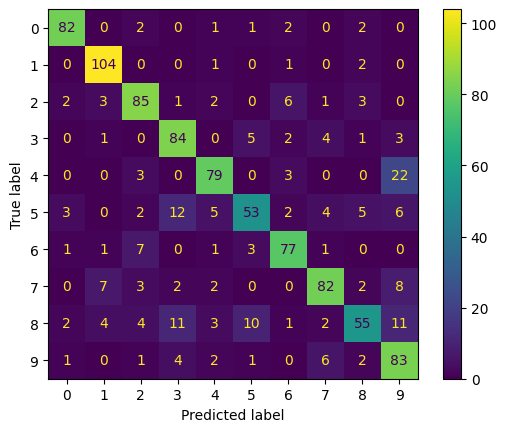

Confusion matrix for the model trained on 20% of the training data:


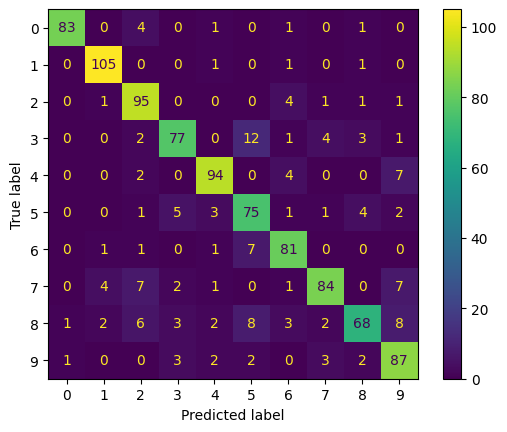

Confusion matrix for the model trained on 30% of the training data:


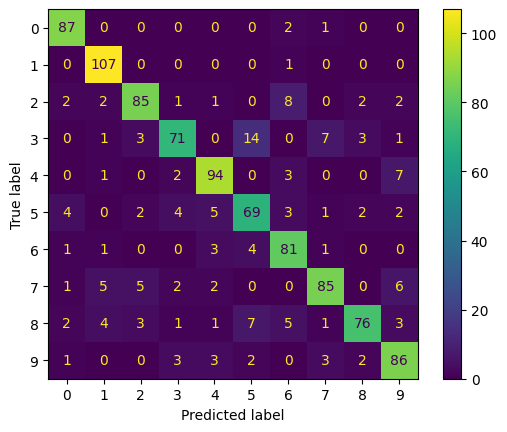

Confusion matrix for the model trained on 40% of the training data:


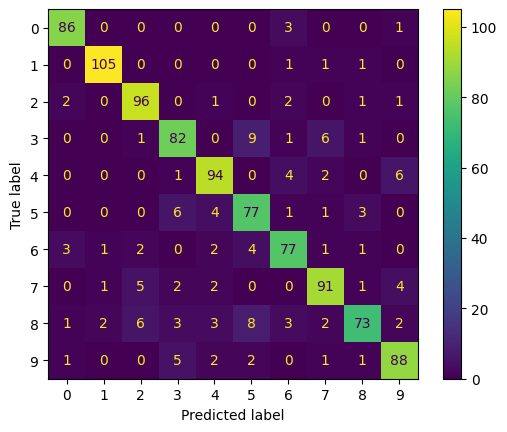

Confusion matrix for the model trained on 50% of the training data:


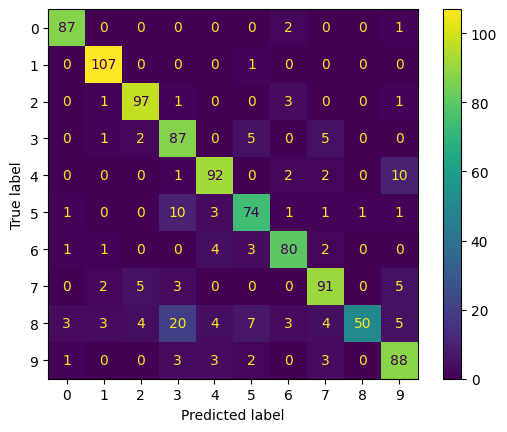

Confusion matrix for the model trained on 60% of the training data:


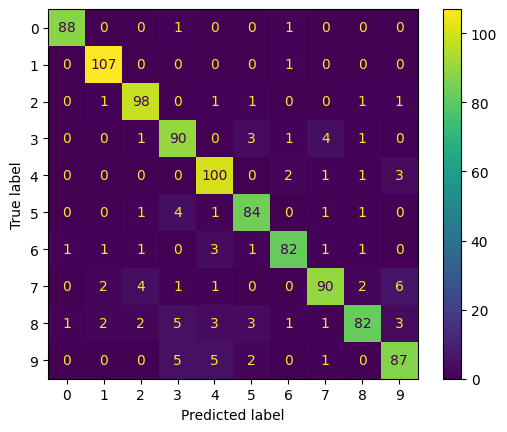

Confusion matrix for the model trained on 70% of the training data:


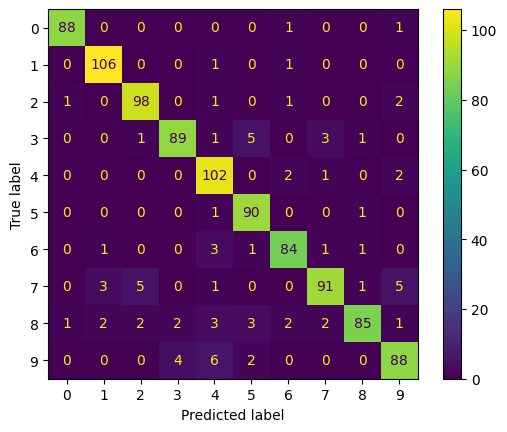

Confusion matrix for the model trained on 80% of the training data:


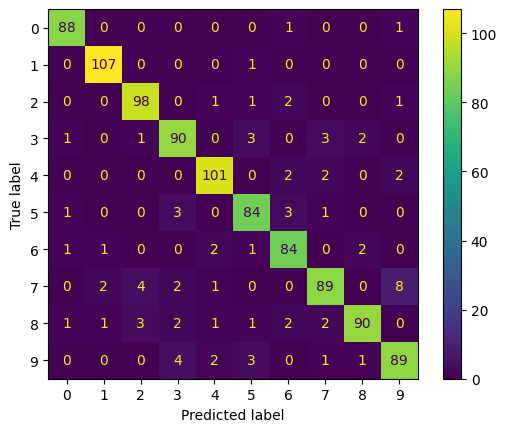

Confusion matrix for the model trained on 90% of the training data:


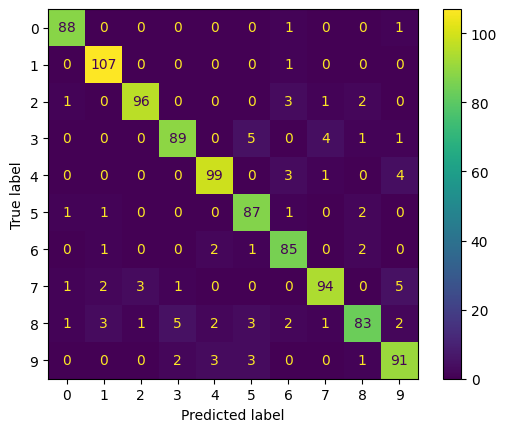

Confusion matrix for the model trained on 100% of the training data:


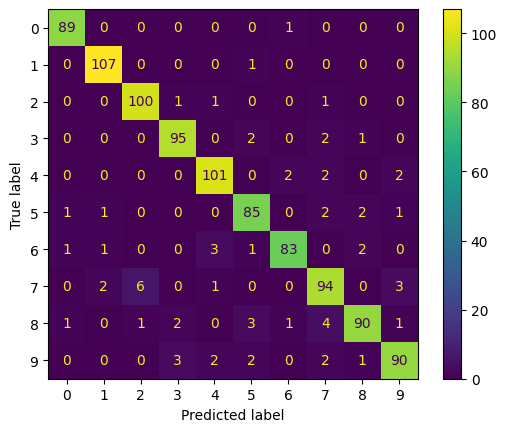

In [ ]:
portion = 10

for cm in cms:
    print(f'Confusion matrix for the model trained on {portion}% of the training data:')
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.show()
    portion += 10

The highest accuracy achieved on the test dataset was 93%, which was trained on 100% of the train dataset.

#### Training and Testing with the Faces Dataset

The dataset is normalized. The CNN classifier class works with any datasat, as long as image size is inputted during model instantiation.

In [ ]:
faces_train_ds = TextDataset('./data/facedata/facedatatrain',
                             './data/facedata/facedatatrainlabels',
                             './data/facedata/train_data',
                             image_size=(70, 60),
                             transforms=transforms.Compose([
                              #   RandomRotate(prob=0.4, degrees=(-45, 45)),
                                Normalize()
                            ]))
faces_val_ds = TextDataset('./data/facedata/facedatavalidation',
                           './data/facedata/facedatavalidationlabels',
                           './data/facedata/val_data',
                           image_size=(70, 60),
                           transforms=transforms.Compose([
                                Normalize()
                           ]))

faces_val_dataloader = DataLoader(faces_val_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)




num_epochs = 30
learning_rate = 2.0e-4
portion = 0.1
cnnModels = []
histories = []

for i in range(10):
    faces_train_dataloader = DataLoader(torch.utils.data.Subset(faces_train_ds, list(range(int(len(faces_train_ds) * portion)))),
                                         batch_size=min(BATCH_SIZE, int(len(faces_train_ds) * portion)),
                                         shuffle=True,
                                         #num_workers=os.cpu_count(),
                                         drop_last=False)

    m = CNNClassifier(70*60, 2, device).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(m.parameters(), lr=learning_rate)
    # print(m)
    # t = np.array(digits_test_ds[0])
    # print(t[1])
    # print(t.shape)
    # print(m.forward(t))
    histories.append(m.trainCNN(faces_train_dataloader, criterion, optimizer, num_epochs, faces_val_dataloader, verbose=False))
    cnnModels.append(m)
    portion = portion + 0.1
    #histories.append(m.trainCNN(digits_train_dataloader, criterion, optimizer, num_epochs, val_loader=digits_val_dataloader, verbose=False))


Epoch [30/30]
1/1 [==============================] - 0s 491ms/step - loss: 0.0205 - acc: 1.0000 - val_loss: 0.6089 - val_acc: 0.6179
Epoch [30/30]
2/2 [==============================] - 1s 408ms/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.2891 - val_acc: 0.8970
Epoch [30/30]
3/3 [==============================] - 1s 360ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.2327 - val_acc: 0.9336
Epoch [30/30]
3/3 [==============================] - 1s 376ms/step - loss: 5.6283e-04 - acc: 1.0000 - val_loss: 0.1786 - val_acc: 0.9468
Epoch [30/30]
4/4 [==============================] - 1s 375ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.1888 - val_acc: 0.9236
Epoch [30/30]
5/5 [==============================] - 2s 374ms/step - loss: 4.0897e-04 - acc: 1.0000 - val_loss: 0.1334 - val_acc: 0.9535
Epoch [30/30]
5/5 [==============================] - 2s 380ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.1346 - val_acc: 0.9535
Epoch [30/30]
6/6 [==============================] - 2s 376ms

Overfitting, once again, is noticed throughout the training. From 20% of the dataset onwards, the models display a high validation accuracy. The highest validatoin accuracy achieved was 96.4%, which was trained on 100% of the training data.

Training Loss vs. Validation Loss for the model trained on 10% of the training data


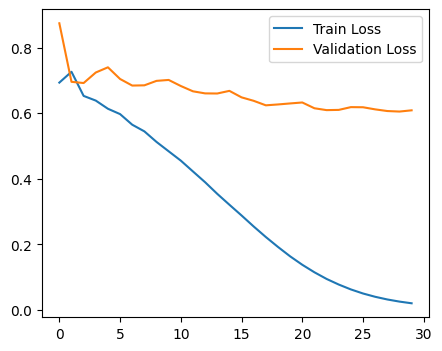

Training Loss vs. Validation Loss for the model trained on 20% of the training data


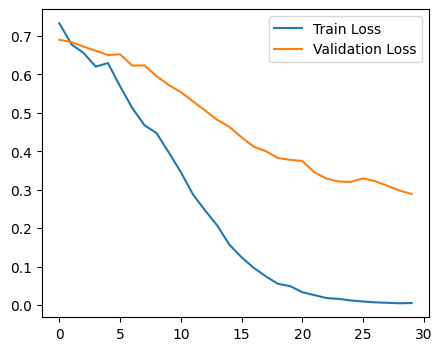

Training Loss vs. Validation Loss for the model trained on 30% of the training data


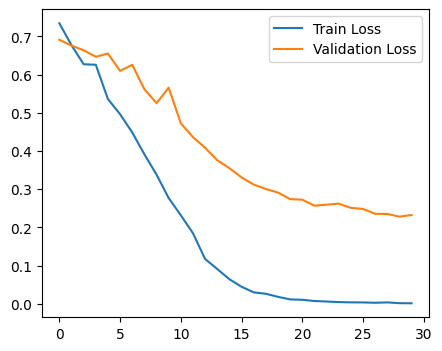

Training Loss vs. Validation Loss for the model trained on 40% of the training data


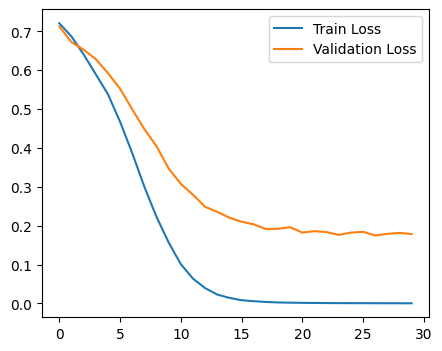

Training Loss vs. Validation Loss for the model trained on 50% of the training data


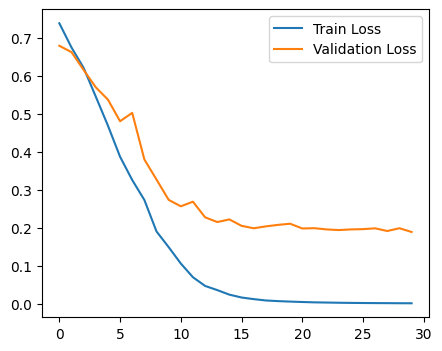

Training Loss vs. Validation Loss for the model trained on 60% of the training data


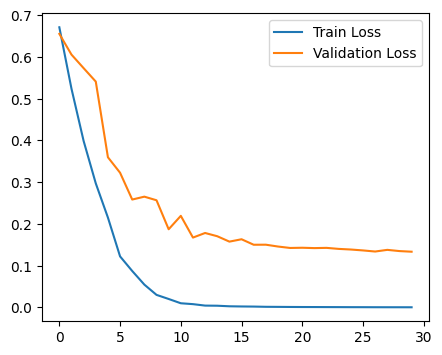

Training Loss vs. Validation Loss for the model trained on 70% of the training data


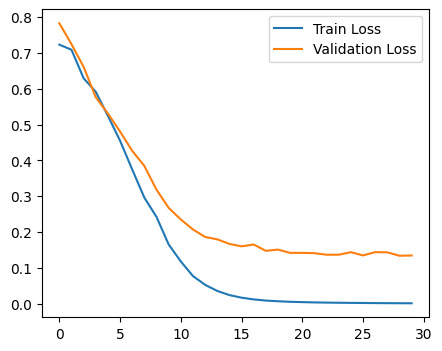

Training Loss vs. Validation Loss for the model trained on 80% of the training data


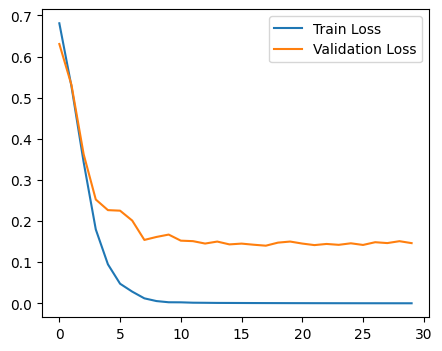

Training Loss vs. Validation Loss for the model trained on 90% of the training data


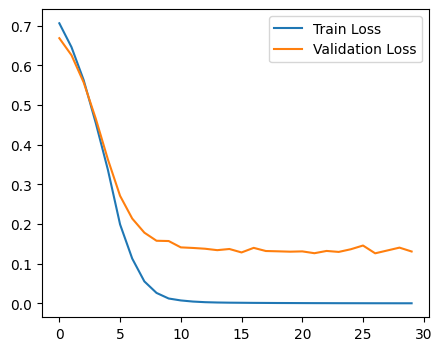

Training Loss vs. Validation Loss for the model trained on 100% of the training data


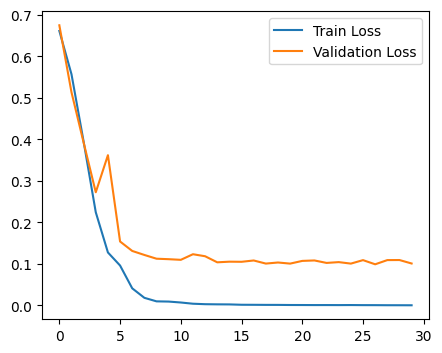

In [ ]:
portion = 10

for i in range(10):
    train_loss, _, val_loss, _ = histories[i]
    plt.figure(figsize=(5, 4))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    print(f'Training Loss vs. Validation Loss for the model trained on {portion}% of the training data')
    plt.show()

    portion += 10

Overfitting is observed as the validation loss is higher than the training loss.

Now, let's look at how the accuracies got improved over time.

Training Accuracy vs. Validation Accuracy for the model trained on 10% of the training data


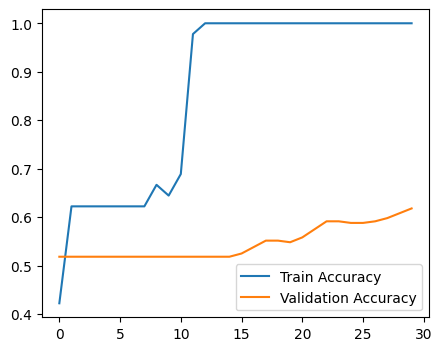

Training Accuracy vs. Validation Accuracy for the model trained on 20% of the training data


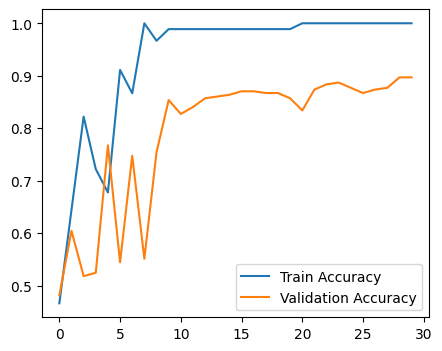

Training Accuracy vs. Validation Accuracy for the model trained on 30% of the training data


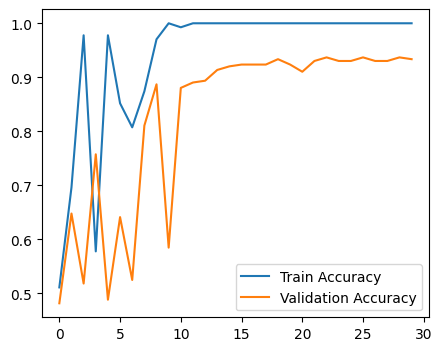

Training Accuracy vs. Validation Accuracy for the model trained on 40% of the training data


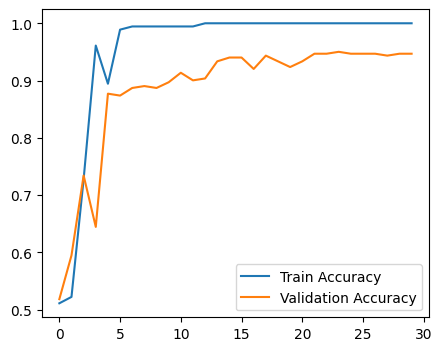

Training Accuracy vs. Validation Accuracy for the model trained on 50% of the training data


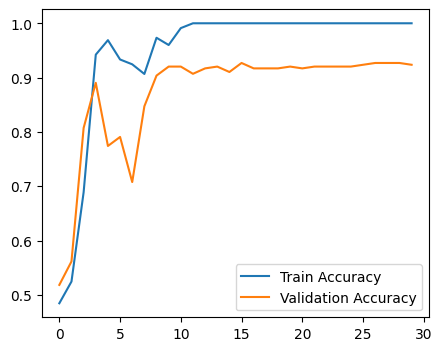

Training Accuracy vs. Validation Accuracy for the model trained on 60% of the training data


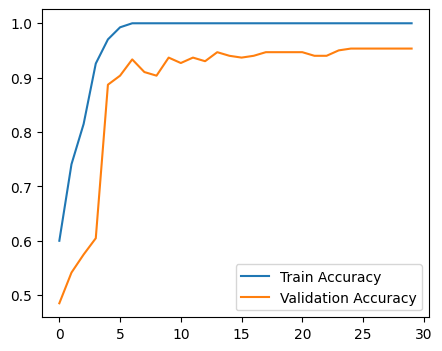

Training Accuracy vs. Validation Accuracy for the model trained on 70% of the training data


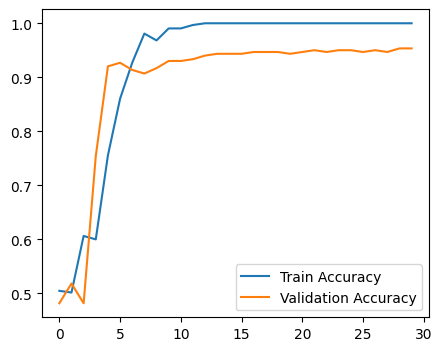

Training Accuracy vs. Validation Accuracy for the model trained on 80% of the training data


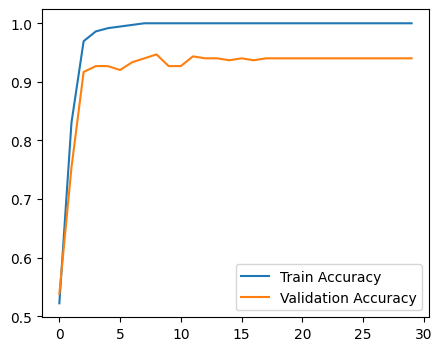

Training Accuracy vs. Validation Accuracy for the model trained on 90% of the training data


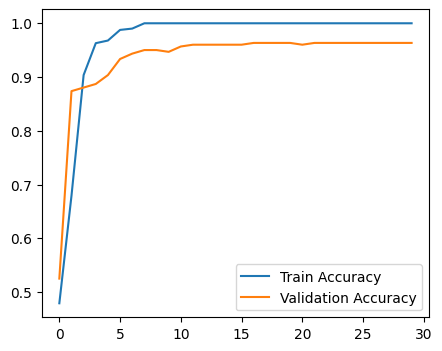

Training Accuracy vs. Validation Accuracy for the model trained on 100% of the training data


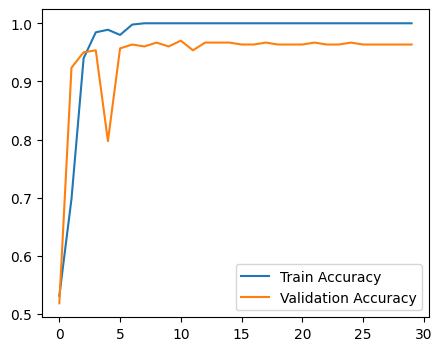

In [ ]:
portion = 10

for i in range(10):
    _, train_acc, _, val_acc = histories[i]
    plt.figure(figsize=(5, 4))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    print(f'Training Accuracy vs. Validation Accuracy for the model trained on {portion}% of the training data')
    plt.show()

    portion += 10

The following code evaluates the CNNs on the test set.

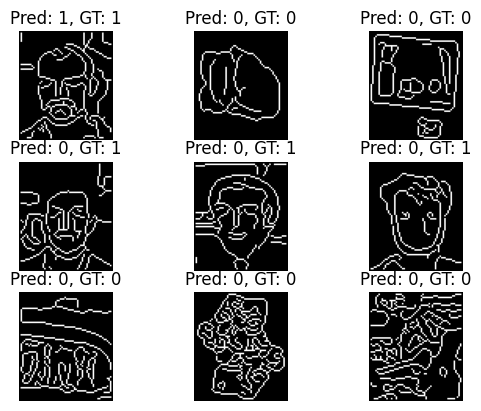

Classification report using the test set for the model trained on 10% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        77
           1       1.00      0.12      0.22        73

    accuracy                           0.57       150
   macro avg       0.77      0.56      0.46       150
weighted avg       0.77      0.57      0.47       150



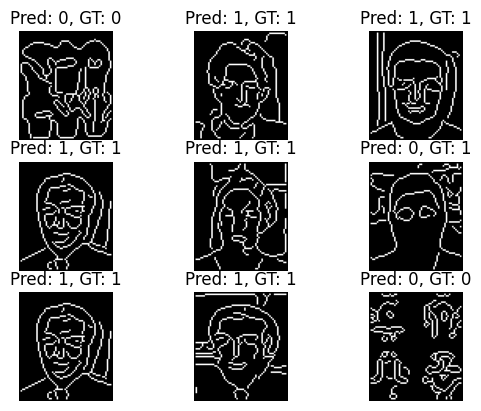

Classification report using the test set for the model trained on 20% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.81      0.96      0.88        77
           1       0.95      0.77      0.85        73

    accuracy                           0.87       150
   macro avg       0.88      0.86      0.86       150
weighted avg       0.88      0.87      0.87       150



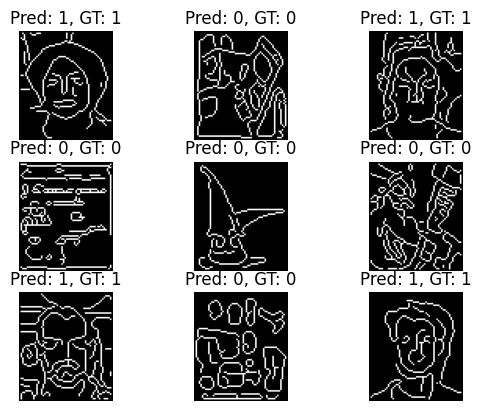

Classification report using the test set for the model trained on 30% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.90      0.97      0.94        77
           1       0.97      0.89      0.93        73

    accuracy                           0.93       150
   macro avg       0.94      0.93      0.93       150
weighted avg       0.94      0.93      0.93       150



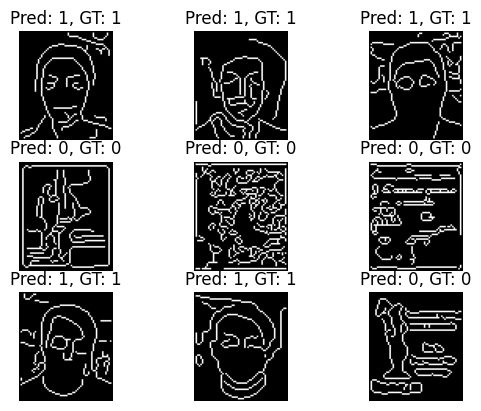

Classification report using the test set for the model trained on 40% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.92      0.95      0.94        77
           1       0.94      0.92      0.93        73

    accuracy                           0.93       150
   macro avg       0.93      0.93      0.93       150
weighted avg       0.93      0.93      0.93       150



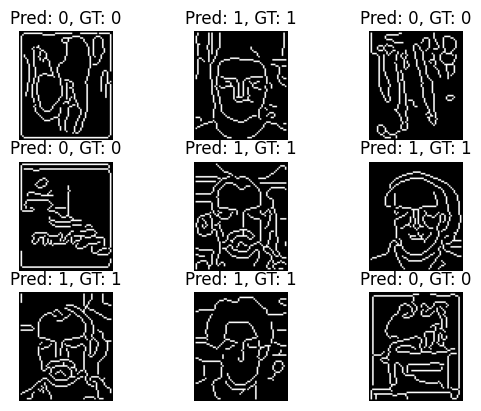

Classification report using the test set for the model trained on 50% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.96      0.95      0.95        77
           1       0.95      0.96      0.95        73

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150



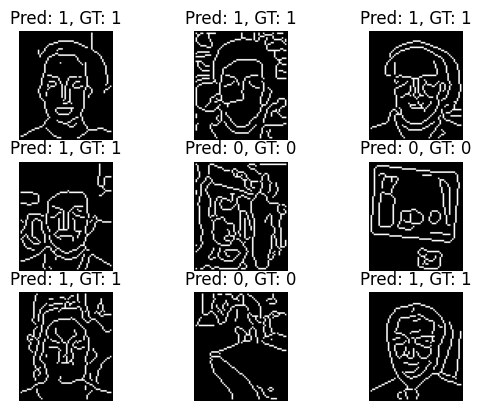

Classification report using the test set for the model trained on 60% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.91      0.96      0.94        77
           1       0.96      0.90      0.93        73

    accuracy                           0.93       150
   macro avg       0.94      0.93      0.93       150
weighted avg       0.93      0.93      0.93       150



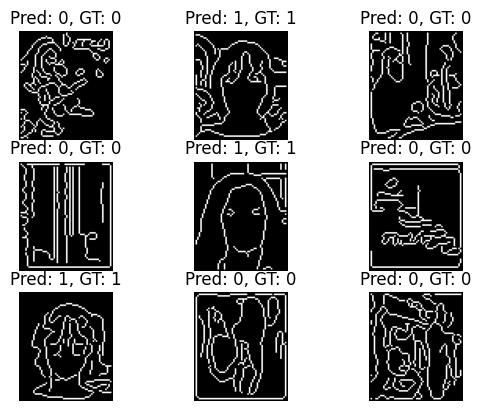

Classification report using the test set for the model trained on 70% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        77
           1       0.93      0.96      0.95        73

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150



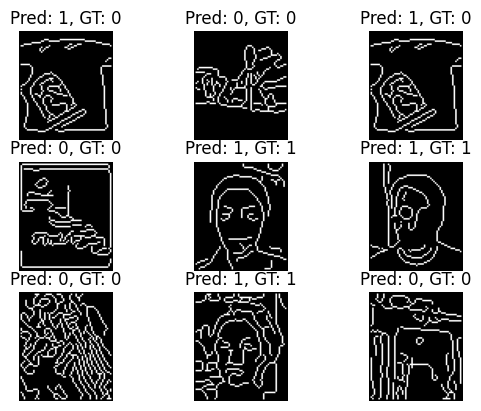

Classification report using the test set for the model trained on 80% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        77
           1       0.93      0.96      0.95        73

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150



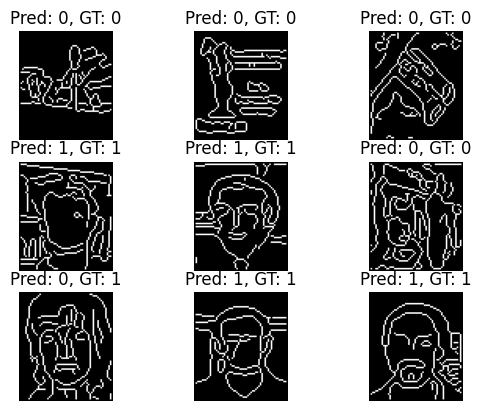

Classification report using the test set for the model trained on 90% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.97      0.96      0.97        77
           1       0.96      0.97      0.97        73

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



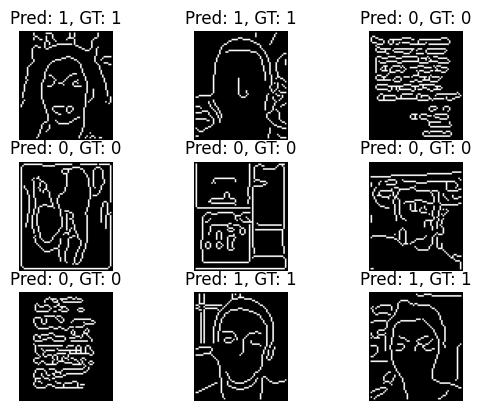

Classification report using the test set for the model trained on 100% of the training data:
###########################################################################################
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        77
           1       0.97      0.96      0.97        73

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



In [ ]:
portion = 10
cms = []

for model in cnnModels:
    fig, ax = plt.subplots(3, 3)
    ids = np.random.randint(size=9, low=0, high=len(faces_test_ds))
    imgs, labels = faces_test_ds[:]
    preds, acc, _, _, _, cm = evaluate(model, faces_test_ds, normalize=True)
    cms.append(cm)

    for i in range(9):
        j = np.random.randint(low=0, high=len(faces_test_ds))
        ax[i // 3, i % 3].imshow(imgs[ids[i]], cmap='gray')
        ax[i // 3, i % 3].set_title(f'Pred: {preds[ids[i]]}, GT: {labels[ids[i]]}')
        ax[i // 3, i % 3].axis('off')
    plt.show()

    print(f'Classification report using the test set for the model trained on {portion}% of the training data:')
    print('###########################################################################################')
    print(classification_report(labels, preds))

    portion += 10

Confusion matrix for the model trained on 10% of the training data:


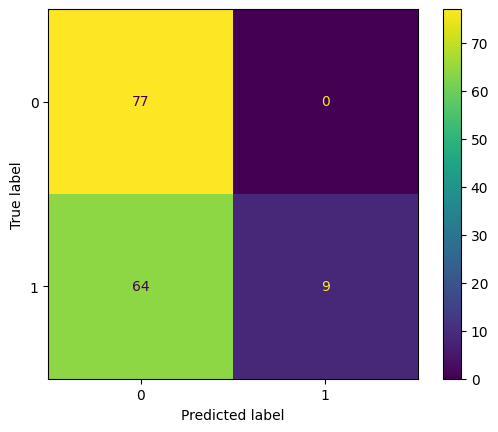

Confusion matrix for the model trained on 20% of the training data:


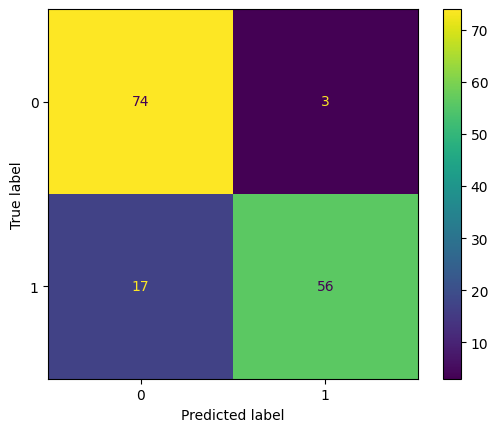

Confusion matrix for the model trained on 30% of the training data:


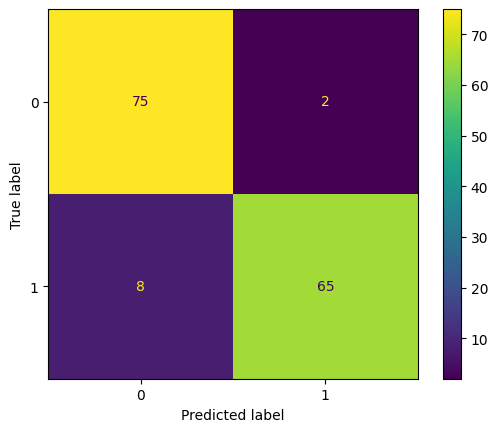

Confusion matrix for the model trained on 40% of the training data:


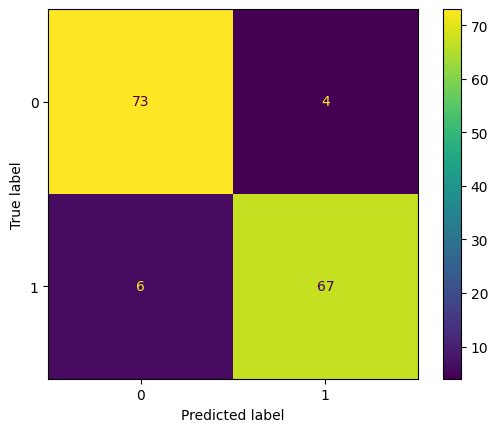

Confusion matrix for the model trained on 50% of the training data:


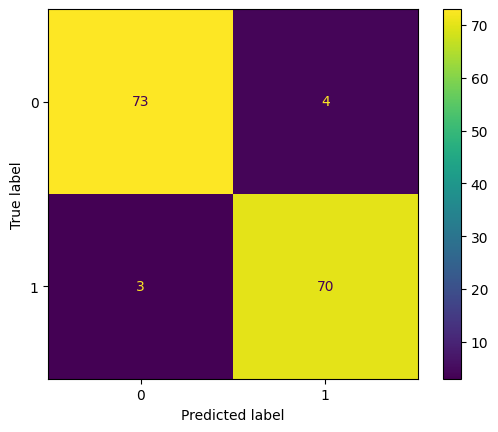

Confusion matrix for the model trained on 60% of the training data:


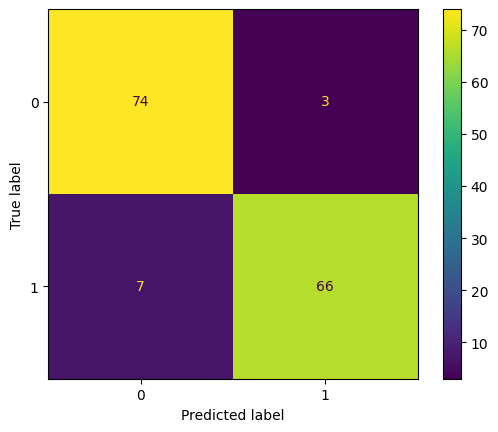

Confusion matrix for the model trained on 70% of the training data:


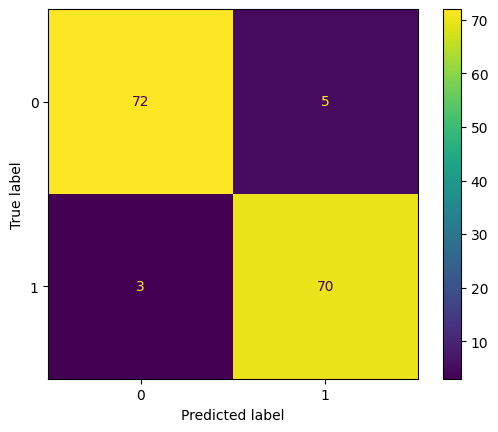

Confusion matrix for the model trained on 80% of the training data:


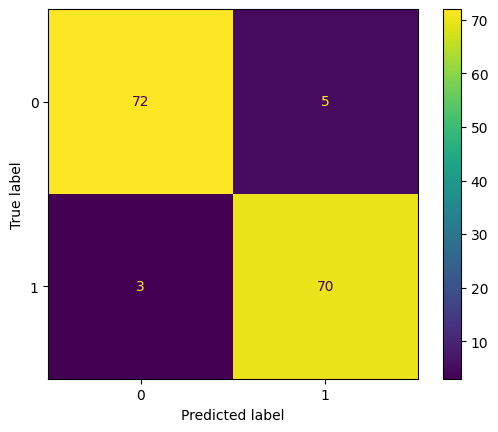

Confusion matrix for the model trained on 90% of the training data:


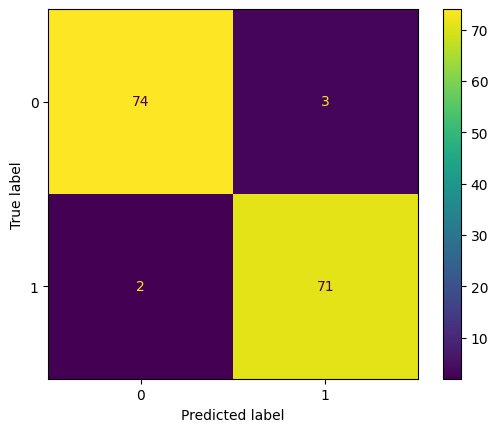

Confusion matrix for the model trained on 100% of the training data:


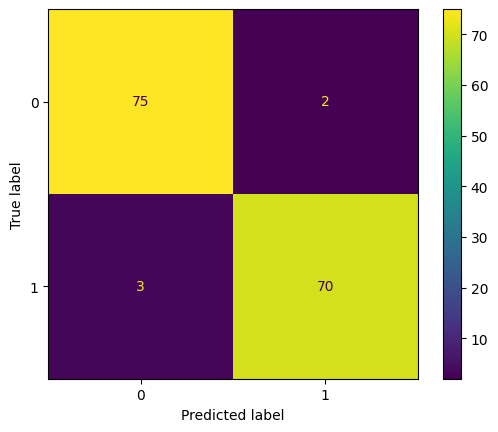

In [ ]:
portion = 10

for cm in cms:
    print(f'Confusion matrix for the model trained on {portion}% of the training data:')
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.show()
    portion += 10

The highest testing accuracy reached was 97%, which was done by the model trained on 100% of the data.

For both datasets, the model overfit on the train dataset at nearly every portion size as the training accuracy converged at 100%. However, the testing accuracy achieved was greater than the 2 other model types. This is a strong indicator that the datasets themselves are flawed and that they don't contain a wide variety of "scenarios".